# Perform Principal component analysis and perform clustering

+ Clustering analysis is an unsupervised learning method that separates the data points into several specific bunches or groups, such that the data points in the same groups have similar properties and data points in different groups have different properties in some sense.

+ It comprises of many different methods based on different distance measures. E.g. K-Means (distance between points), Affinity propagation (graph distance), Mean-shift (distance between points), DBSCAN (distance between nearest points), Gaussian mixtures (Mahalanobis distance to centers), Spectral clustering (graph distance), etc.

+ Centrally, all clustering methods use the same approach i.e. first we calculate similarities and then we use it to cluster the data points into groups or batches. Here we will focus on the Density-based spatial clustering of applications with noise (DBSCAN) clustering method.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score as sil, calinski_harabasz_score as chs, silhouette_samples

In [2]:
# Supressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data display customization

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

## 1. Case Summary
### Perform Principal component analysis and perform clustering using first 3 principal component scores (both <font color='red'>Heirarchical and k mean clustering</font>(scree plot or elbow curve) and obtain optimum number of clusters and check whether we have obtained same number of clusters with the original data (class column we have ignored at the begining who shows it has 3 clusters)

In [4]:
# Importing dataset
data = pd.read_csv('Wine.csv')
data.head()

Type  Alcohol  Malic   Ash  Alcalinity  Magnesium  Phenols  Flavanoids  \
0  1     14.23    1.71   2.43  15.6        127        2.80     3.06         
1  1     13.20    1.78   2.14  11.2        100        2.65     2.76         
2  1     13.16    2.36   2.67  18.6        101        2.80     3.24         
3  1     14.37    1.95   2.50  16.8        113        3.85     3.49         
4  1     13.24    2.59   2.87  21.0        118        2.80     2.69         

   Nonflavanoids  Proanthocyanins  Color   Hue  Dilution  Proline  
0  0.28           2.29             5.64   1.04  3.92      1065     
1  0.26           1.28             4.38   1.05  3.40      1050     
2  0.30           2.81             5.68   1.03  3.17      1185     
3  0.24           2.18             7.80   0.86  3.45      1480     
4  0.39           1.82             4.32   1.04  2.93      735

## 2. Data Exploration <a class="anchor" id="2"></a>

In [5]:
data['Type'].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3], dtype=int64)

In [6]:
data.Type.unique()

array([1, 2, 3], dtype=int64)

In [7]:
data.Type.value_counts()

2    71
1    59
3    48
Name: Type, dtype: int64

##### Dropping Type Feature as it is a classifier that we have three types of wines which we need to find in clustering by keeping it will affect our inferences and further analysis

In [8]:
data['ID'] = range(1, 179, 1)
data

Type  Alcohol  Malic   Ash  Alcalinity  Magnesium  Phenols  Flavanoids  \
0    1     14.23    1.71   2.43  15.6        127        2.80     3.06         
1    1     13.20    1.78   2.14  11.2        100        2.65     2.76         
2    1     13.16    2.36   2.67  18.6        101        2.80     3.24         
3    1     14.37    1.95   2.50  16.8        113        3.85     3.49         
4    1     13.24    2.59   2.87  21.0        118        2.80     2.69         
..  ..       ...     ...    ...   ...        ...         ...      ...         
173  3     13.71    5.65   2.45  20.5        95         1.68     0.61         
174  3     13.40    3.91   2.48  23.0        102        1.80     0.75         
175  3     13.27    4.28   2.26  20.0        120        1.59     0.69         
176  3     13.17    2.59   2.37  20.0        120        1.65     0.68         
177  3     14.13    4.10   2.74  24.5        96         2.05     0.76         

     Nonflavanoids  Proanthocyanins  Color   Hue  Dilution  Proline   ID  
0    0.28           2.29             5.64   1.04  3.92      1065     1    
1    0.26           1.28             4.38   1.05  3.40      1050     2    
2    0.30           2.81             5.68   1.03  3.17      1185     3    
3    0.24           2.18             7.80   0.86  3.45      1480     4    
4    0.39           1.82             4.32   1.04  2.93      735      5    
..    ...            ...              ...    ...   ...      ...     ..    
173  0.52           1.06             7.70   0.64  1.74      740      174  
174  0.43           1.41             7.30   0.70  1.56      750      175  
175  0.43           1.35             10.20  0.59  1.56      835      176  
176  0.53           1.46             9.30   0.60  1.62      840      177  
177  0.56           1.35             9.20   0.61  1.60      560      178  

[178 rows x 15 columns]

In [9]:
df = data.drop('Type',axis=1)

#### Descriptive Statistics

In [10]:
df.describe()

Alcohol       Malic         Ash  Alcalinity   Magnesium     Phenols  \
count  178.000000  178.000000  178.000000  178.000000  178.000000  178.000000   
mean   13.000618   2.336348    2.366517    19.494944   99.741573   2.295112     
std    0.811827    1.117146    0.274344    3.339564    14.282484   0.625851     
min    11.030000   0.740000    1.360000    10.600000   70.000000   0.980000     
25%    12.362500   1.602500    2.210000    17.200000   88.000000   1.742500     
50%    13.050000   1.865000    2.360000    19.500000   98.000000   2.355000     
75%    13.677500   3.082500    2.557500    21.500000   107.000000  2.800000     
max    14.830000   5.800000    3.230000    30.000000   162.000000  3.880000     

       Flavanoids  Nonflavanoids  Proanthocyanins       Color         Hue  \
count  178.000000  178.000000     178.000000       178.000000  178.000000   
mean   2.029270    0.361854       1.590899         5.058090    0.957449     
std    0.998859    0.124453       0.572359         2.318286    0.228572     
min    0.340000    0.130000       0.410000         1.280000    0.480000     
25%    1.205000    0.270000       1.250000         3.220000    0.782500     
50%    2.135000    0.340000       1.555000         4.690000    0.965000     
75%    2.875000    0.437500       1.950000         6.200000    1.120000     
max    5.080000    0.660000       3.580000         13.000000   1.710000     

         Dilution      Proline          ID  
count  178.000000  178.000000   178.000000  
mean   2.611685    746.893258   89.500000   
std    0.709990    314.907474   51.528309   
min    1.270000    278.000000   1.000000    
25%    1.937500    500.500000   45.250000   
50%    2.780000    673.500000   89.500000   
75%    3.170000    985.000000   133.750000  
max    4.000000    1680.000000  178.000000

##### Looking for some statistical information about each feature, we can see that the features have very diferrent scales

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Alcohol          178 non-null    float64
 1   Malic            178 non-null    float64
 2   Ash              178 non-null    float64
 3   Alcalinity       178 non-null    float64
 4   Magnesium        178 non-null    int64  
 5   Phenols          178 non-null    float64
 6   Flavanoids       178 non-null    float64
 7   Nonflavanoids    178 non-null    float64
 8   Proanthocyanins  178 non-null    float64
 9   Color            178 non-null    float64
 10  Hue              178 non-null    float64
 11  Dilution         178 non-null    float64
 12  Proline          178 non-null    int64  
 13  ID               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


### 2.1 Missing Values <a class="anchor" id="2.1"></a>

In [12]:
# As a part of the Data cleansing we check the data for any missing/ na values
# null count for columns

null_count_col = df.isnull().sum().value_counts(ascending=False)

# null percentage for columns

null_percent_col = (df.isnull().sum() * 100 / len(df)).value_counts(ascending=False)

print("Null Count for Columns:\n\n", null_count_col, "\n")
print("Null Percentage for Columns:\n\n", null_percent_col)

Null Count for Columns:

 0    14
dtype: int64 

Null Percentage for Columns:

 0.0    14
dtype: int64


In [13]:
# null count for rows

null_count_row = df.isnull().sum(axis=1).value_counts(ascending=False)

# null percentage for rows

null_percent_row = (df.isnull().sum(axis=1) * 100 / len(df)).value_counts(ascending=False)

print("Null Count for Rows:\n\n", null_count_row, "\n")
print("Null Percentage for Rows:\n\n", null_percent_row)

Null Count for Rows:

 0    178
dtype: int64 

Null Percentage for Rows:

 0.0    178
dtype: int64


### Duplicated Values

#### print the duplicated rows

In [14]:
# Additionally we check the data for any duplicate values, now this can be an optional check depending on the data being used
df.duplicated().sum()

0

In [15]:
df[df.duplicated()]

Empty DataFrame
Columns: [Alcohol, Malic, Ash, Alcalinity, Magnesium, Phenols, Flavanoids, Nonflavanoids, Proanthocyanins, Color, Hue, Dilution, Proline, ID]
Index: []

#### There are no missing / Null and Duplicated  values  either in columns or rows, so we can move on to the next step, which is Exploratory Data Analysis.

## 3. Exploratory Data Analysis<a class="anchor" id="3"></a>

[Table of Content](#0.1)

#### Checking the skewness of our dataset.
+ A normally distribuited data has a skewness close to zero.
+ Skewness greather than zero means that there is more weight in the left side of the data.
+ In another hand, skewness smaller than 0 means that there is more weight in the right side of the data
![Filter Method](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Negative_and_positive_skew_diagrams_%28English%29.svg/446px-Negative_and_positive_skew_diagrams_%28English%29.svg.png)

In [16]:
df.skew()

Alcohol           -0.051482
Malic              1.039651
Ash               -0.176699
Alcalinity         0.213047
Magnesium          1.098191
Phenols            0.086639
Flavanoids         0.025344
Nonflavanoids      0.450151
Proanthocyanins    0.517137
Color              0.868585
Hue                0.021091
Dilution          -0.307285
Proline            0.767822
ID                 0.000000
dtype: float64

### Plotting the histogram of each numerical variable (in this case, all features), the main idea here is to visualize the data distribution for each feature. This method can bring fast insights as:
+ Check the kind of each feature distribution
+ Check data symmetry
+ Verify features frequency
+ Identify outliers

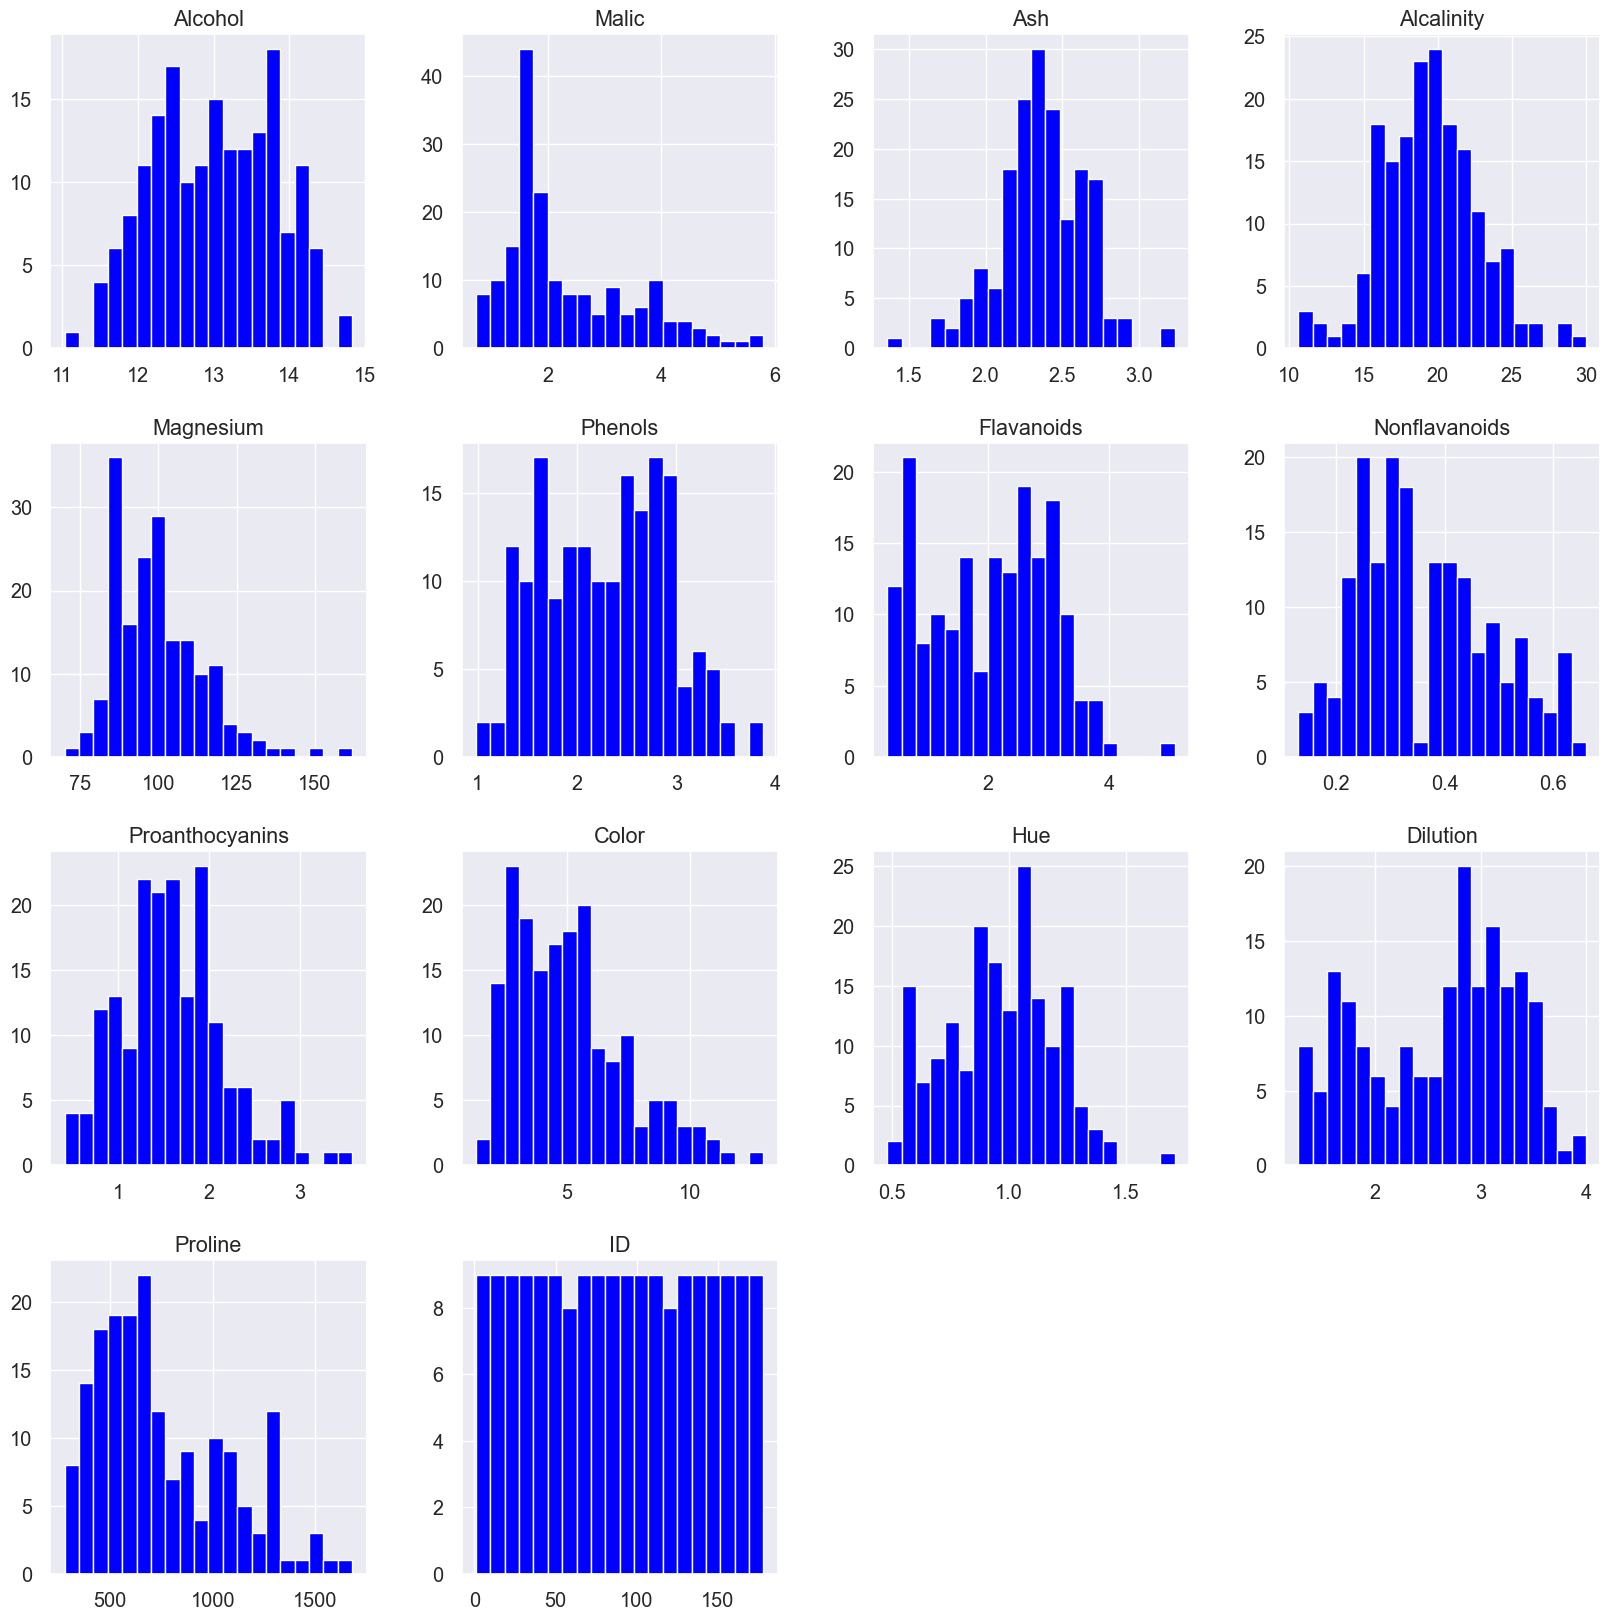

In [17]:
sns.set(style='dark',font_scale=1.3, rc={'figure.figsize':(20,20)})
ax=df.hist(bins=20,color='blue' )

### 3.1 Outliers Detection<a class="anchor" id="3.1"></a>

To reinforce our insights about the data symmetry and their outliers, we can da plot some boxplots:


"A box plot is a method for graphically depicting groups of numerical data through their quartiles. The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2). The whiskers extend from the edges of box to show the range of the data. The position of the whiskers is set by default to 1.5*IQR (IQR = Q3 - Q1) from the edges of the box. Outlier points are those past the end of the whiskers."

In [18]:
df.columns

Index(['Alcohol', 'Malic', 'Ash', 'Alcalinity', 'Magnesium', 'Phenols',
       'Flavanoids', 'Nonflavanoids', 'Proanthocyanins', 'Color', 'Hue',
       'Dilution', 'Proline', 'ID'],
      dtype='object')

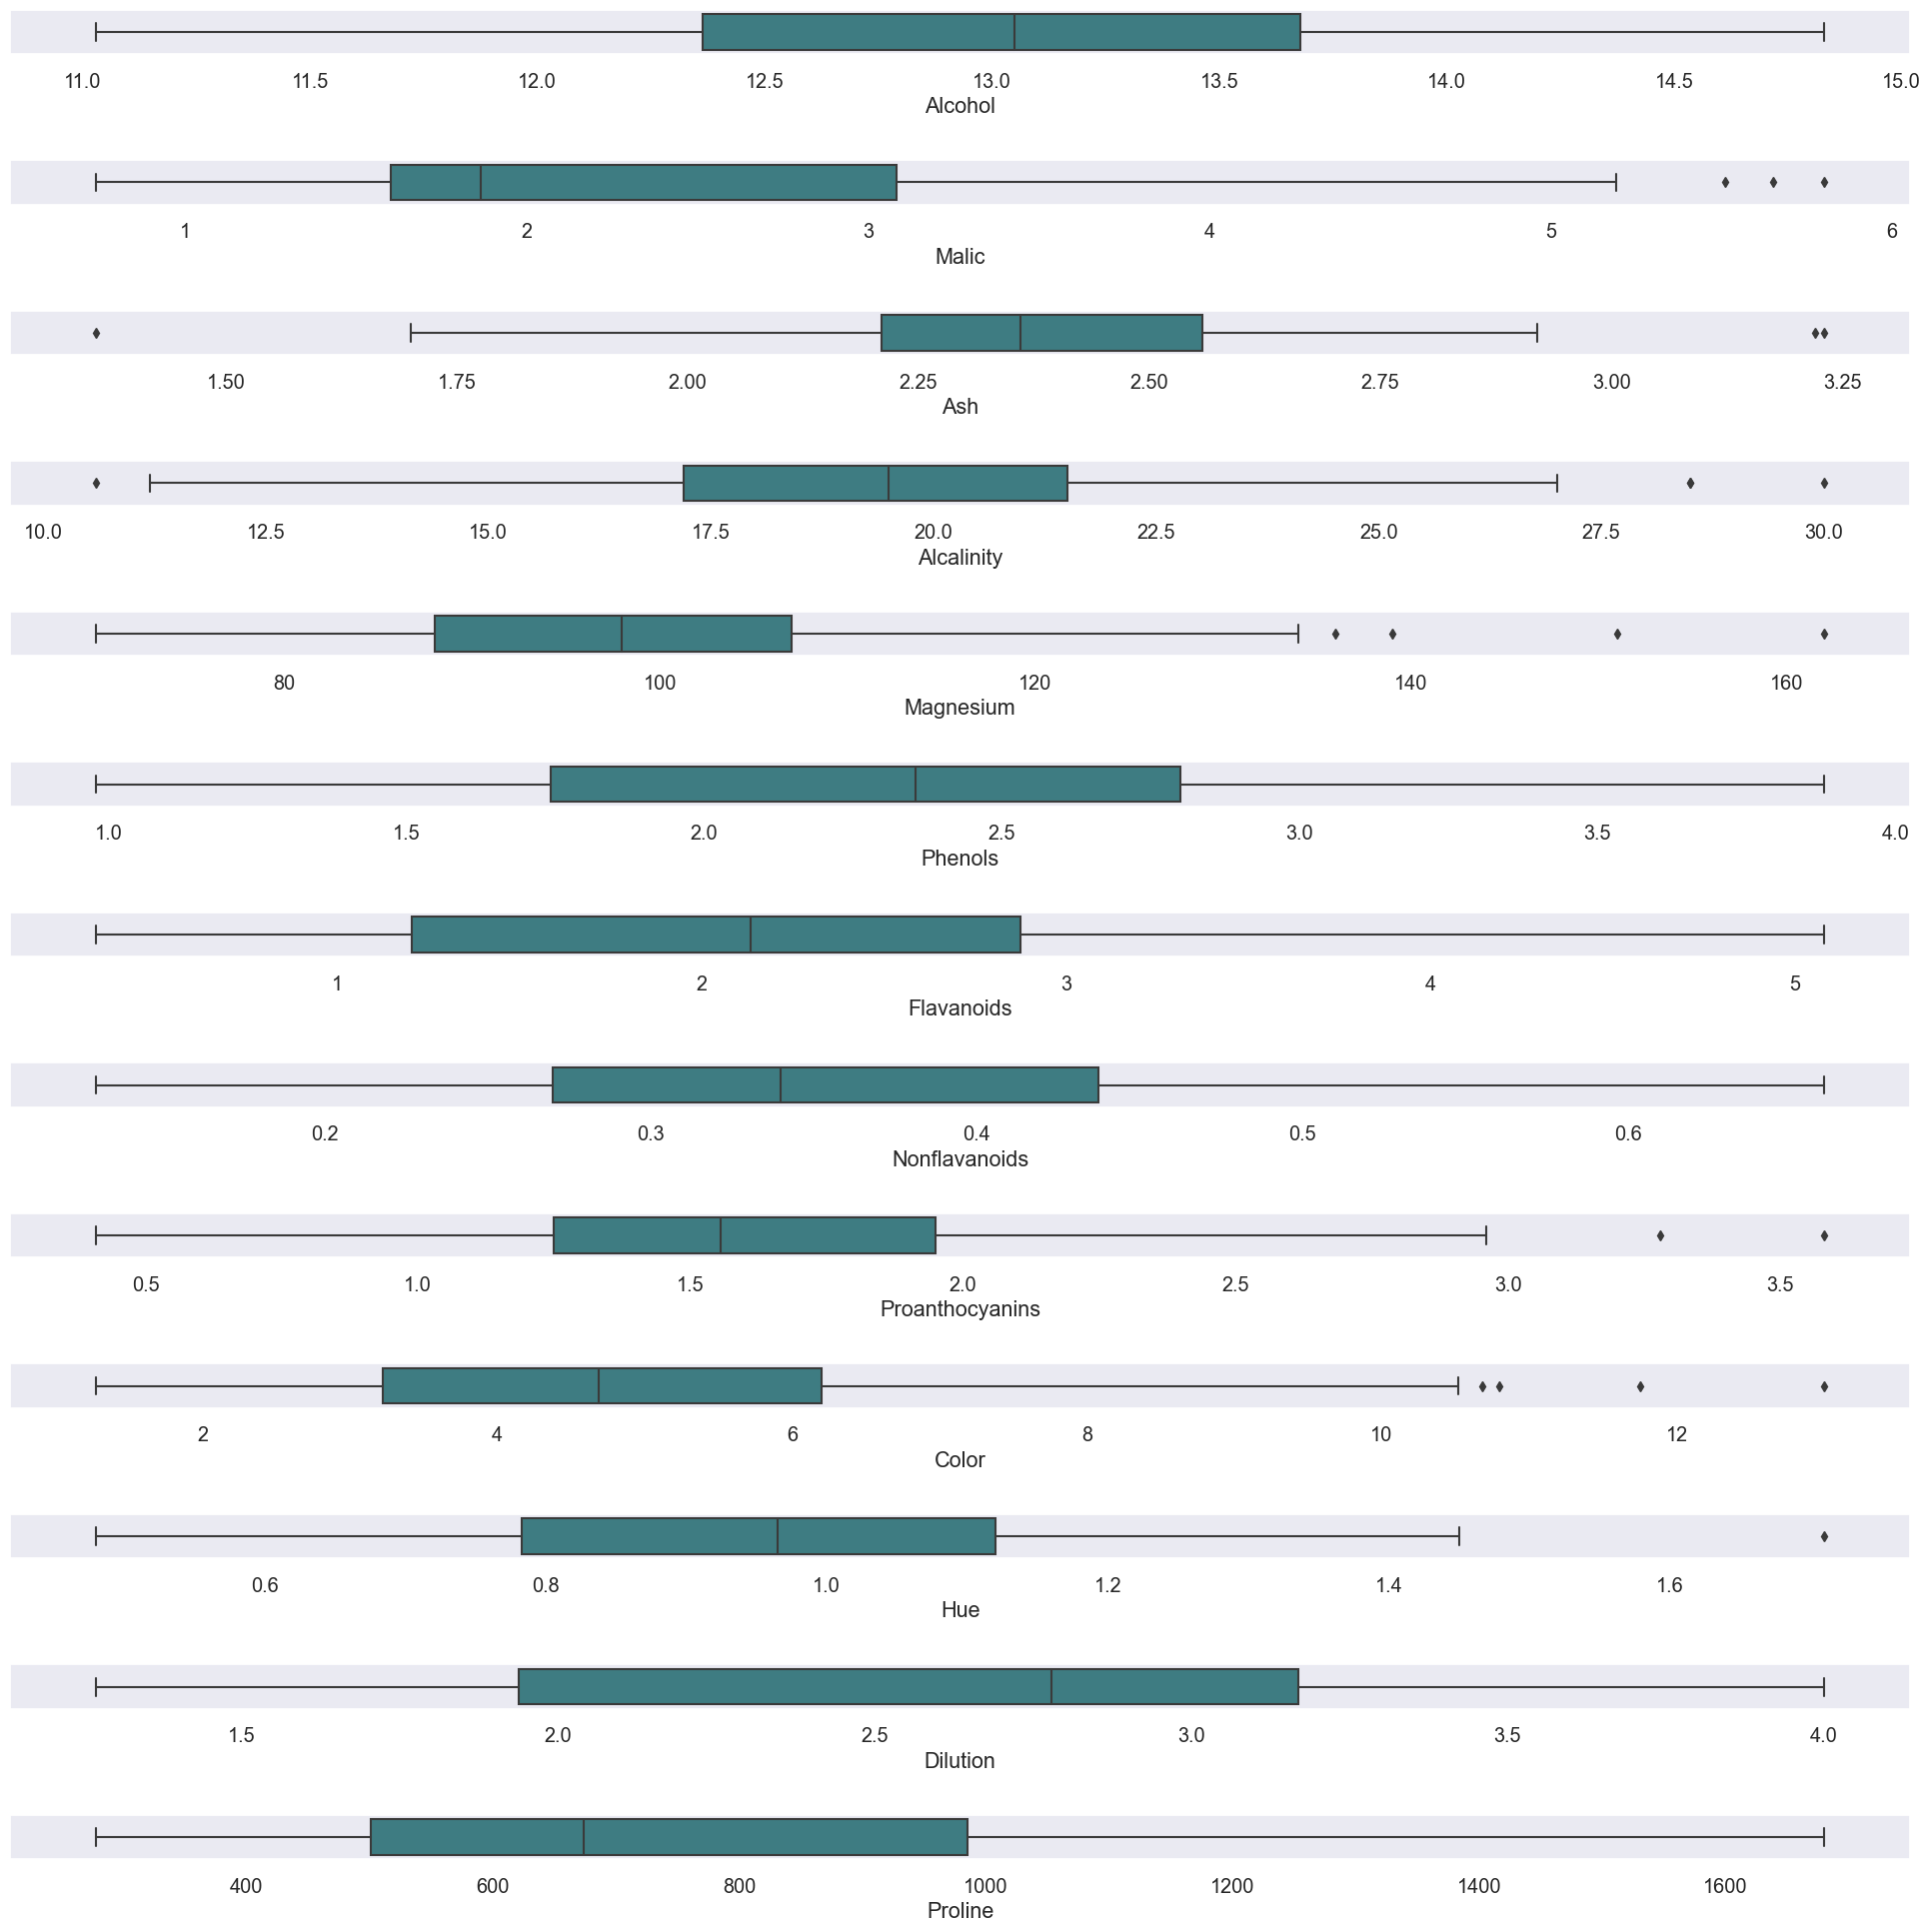

In [19]:
ot=df.copy() 
fig, axes=plt.subplots(13,1,figsize=(20,20),sharex=False,sharey=False)
sns.boxplot(x='Alcohol',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='Malic',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='Ash',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='Alcalinity',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='Magnesium',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='Phenols',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='Flavanoids',data=ot,palette='crest',ax=axes[6])
sns.boxplot(x='Nonflavanoids',data=ot,palette='crest',ax=axes[7])
sns.boxplot(x='Proanthocyanins',data=ot,palette='crest',ax=axes[8])
sns.boxplot(x='Color',data=ot,palette='crest',ax=axes[9])
sns.boxplot(x='Hue',data=ot,palette='crest',ax=axes[10])
sns.boxplot(x='Dilution',data=ot,palette='crest',ax=axes[11])
sns.boxplot(x='Proline',data=ot,palette='crest',ax=axes[12])
plt.tight_layout(pad=2.0)

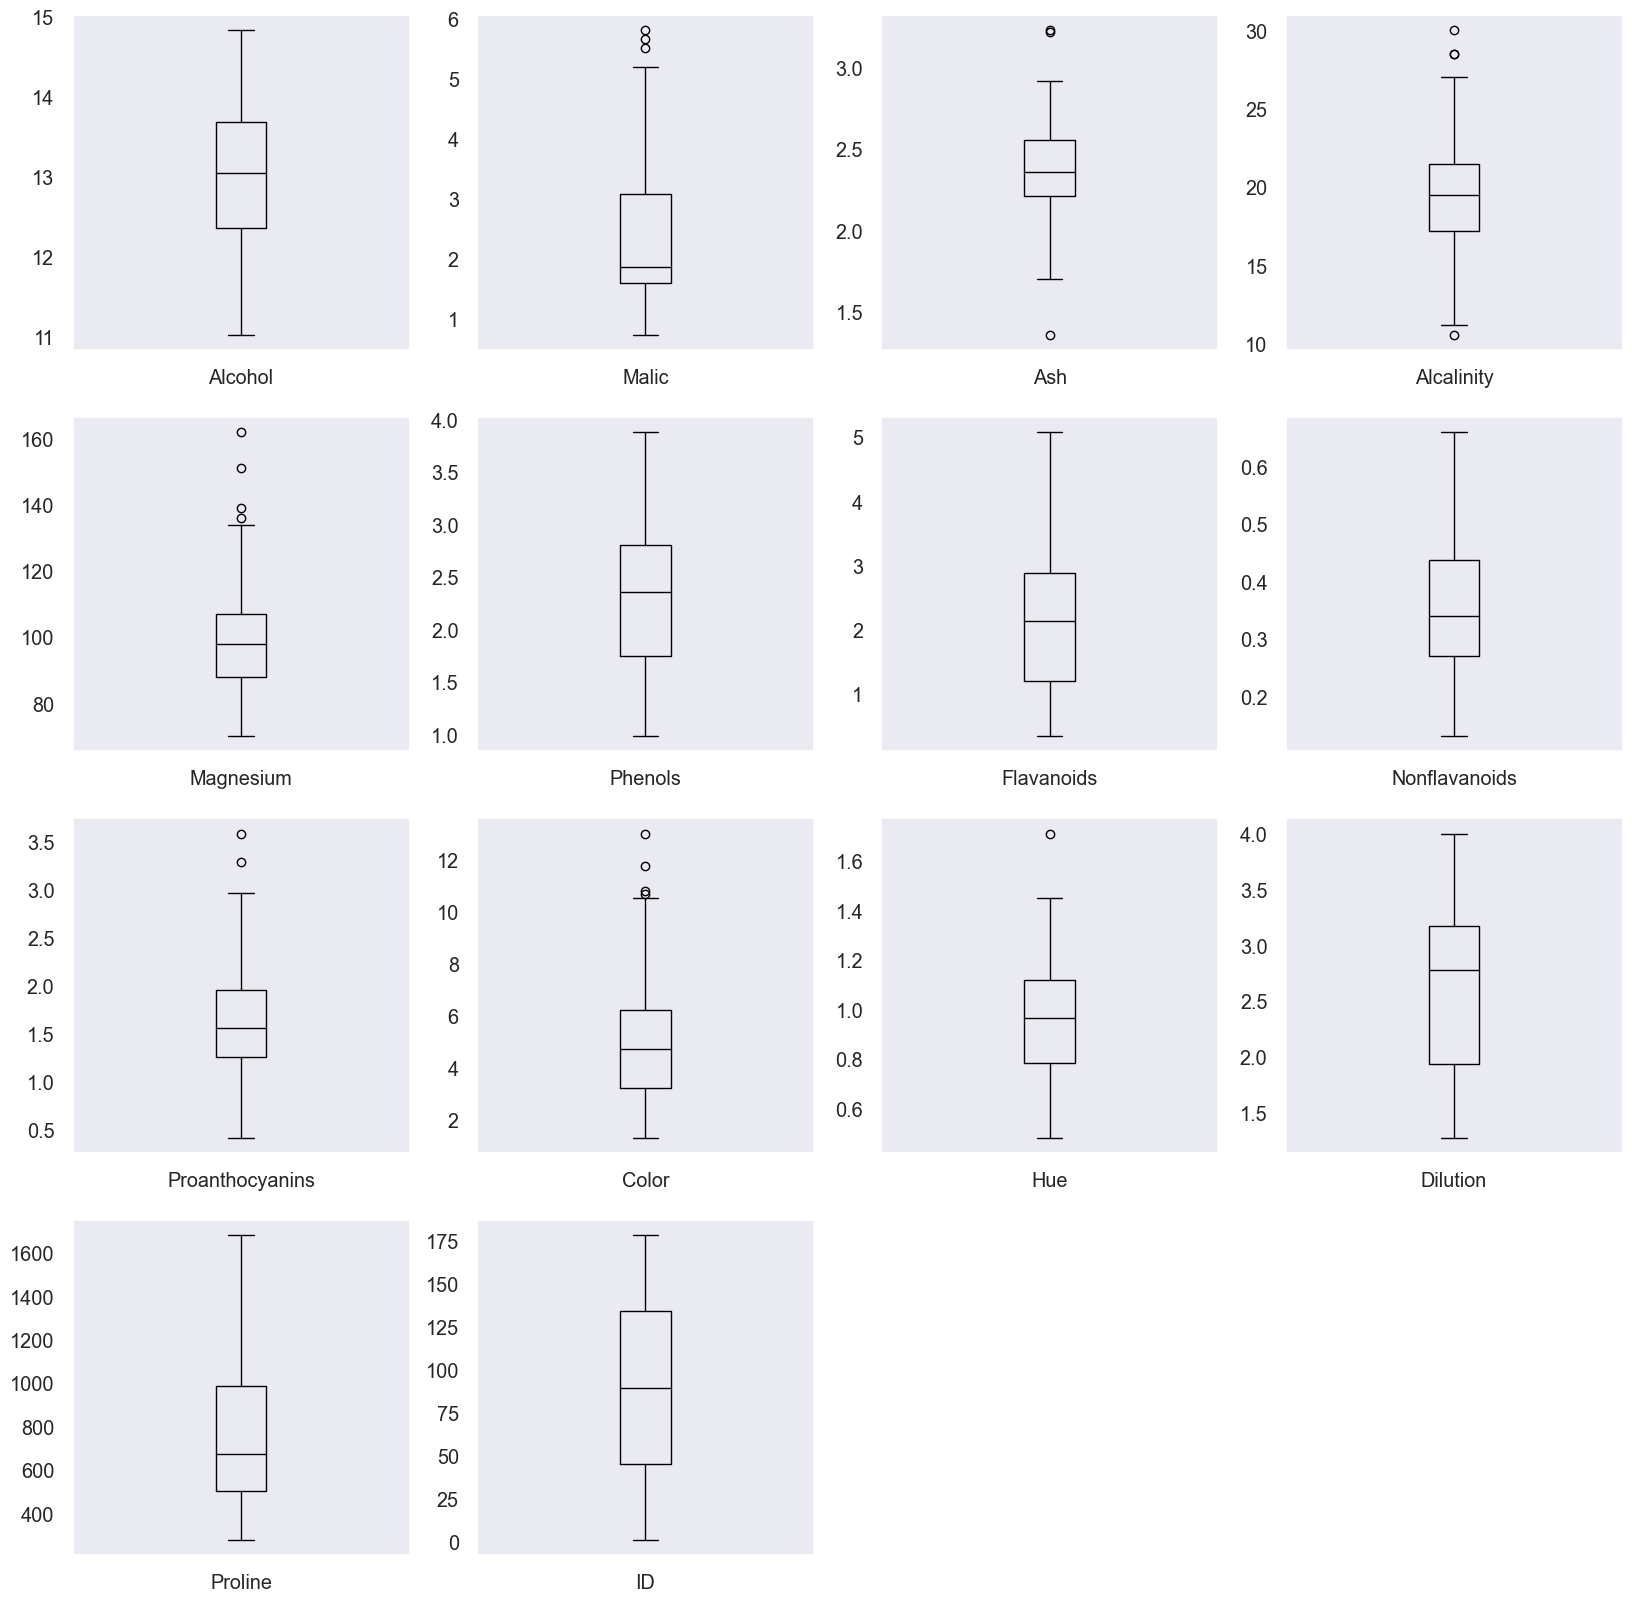

In [20]:
df.plot( kind = 'box', subplots = True, layout = (4,4), sharex = False, sharey = False,color='black')
plt.show()

## 4. Data Visualization<a class="anchor" id="4"></a>

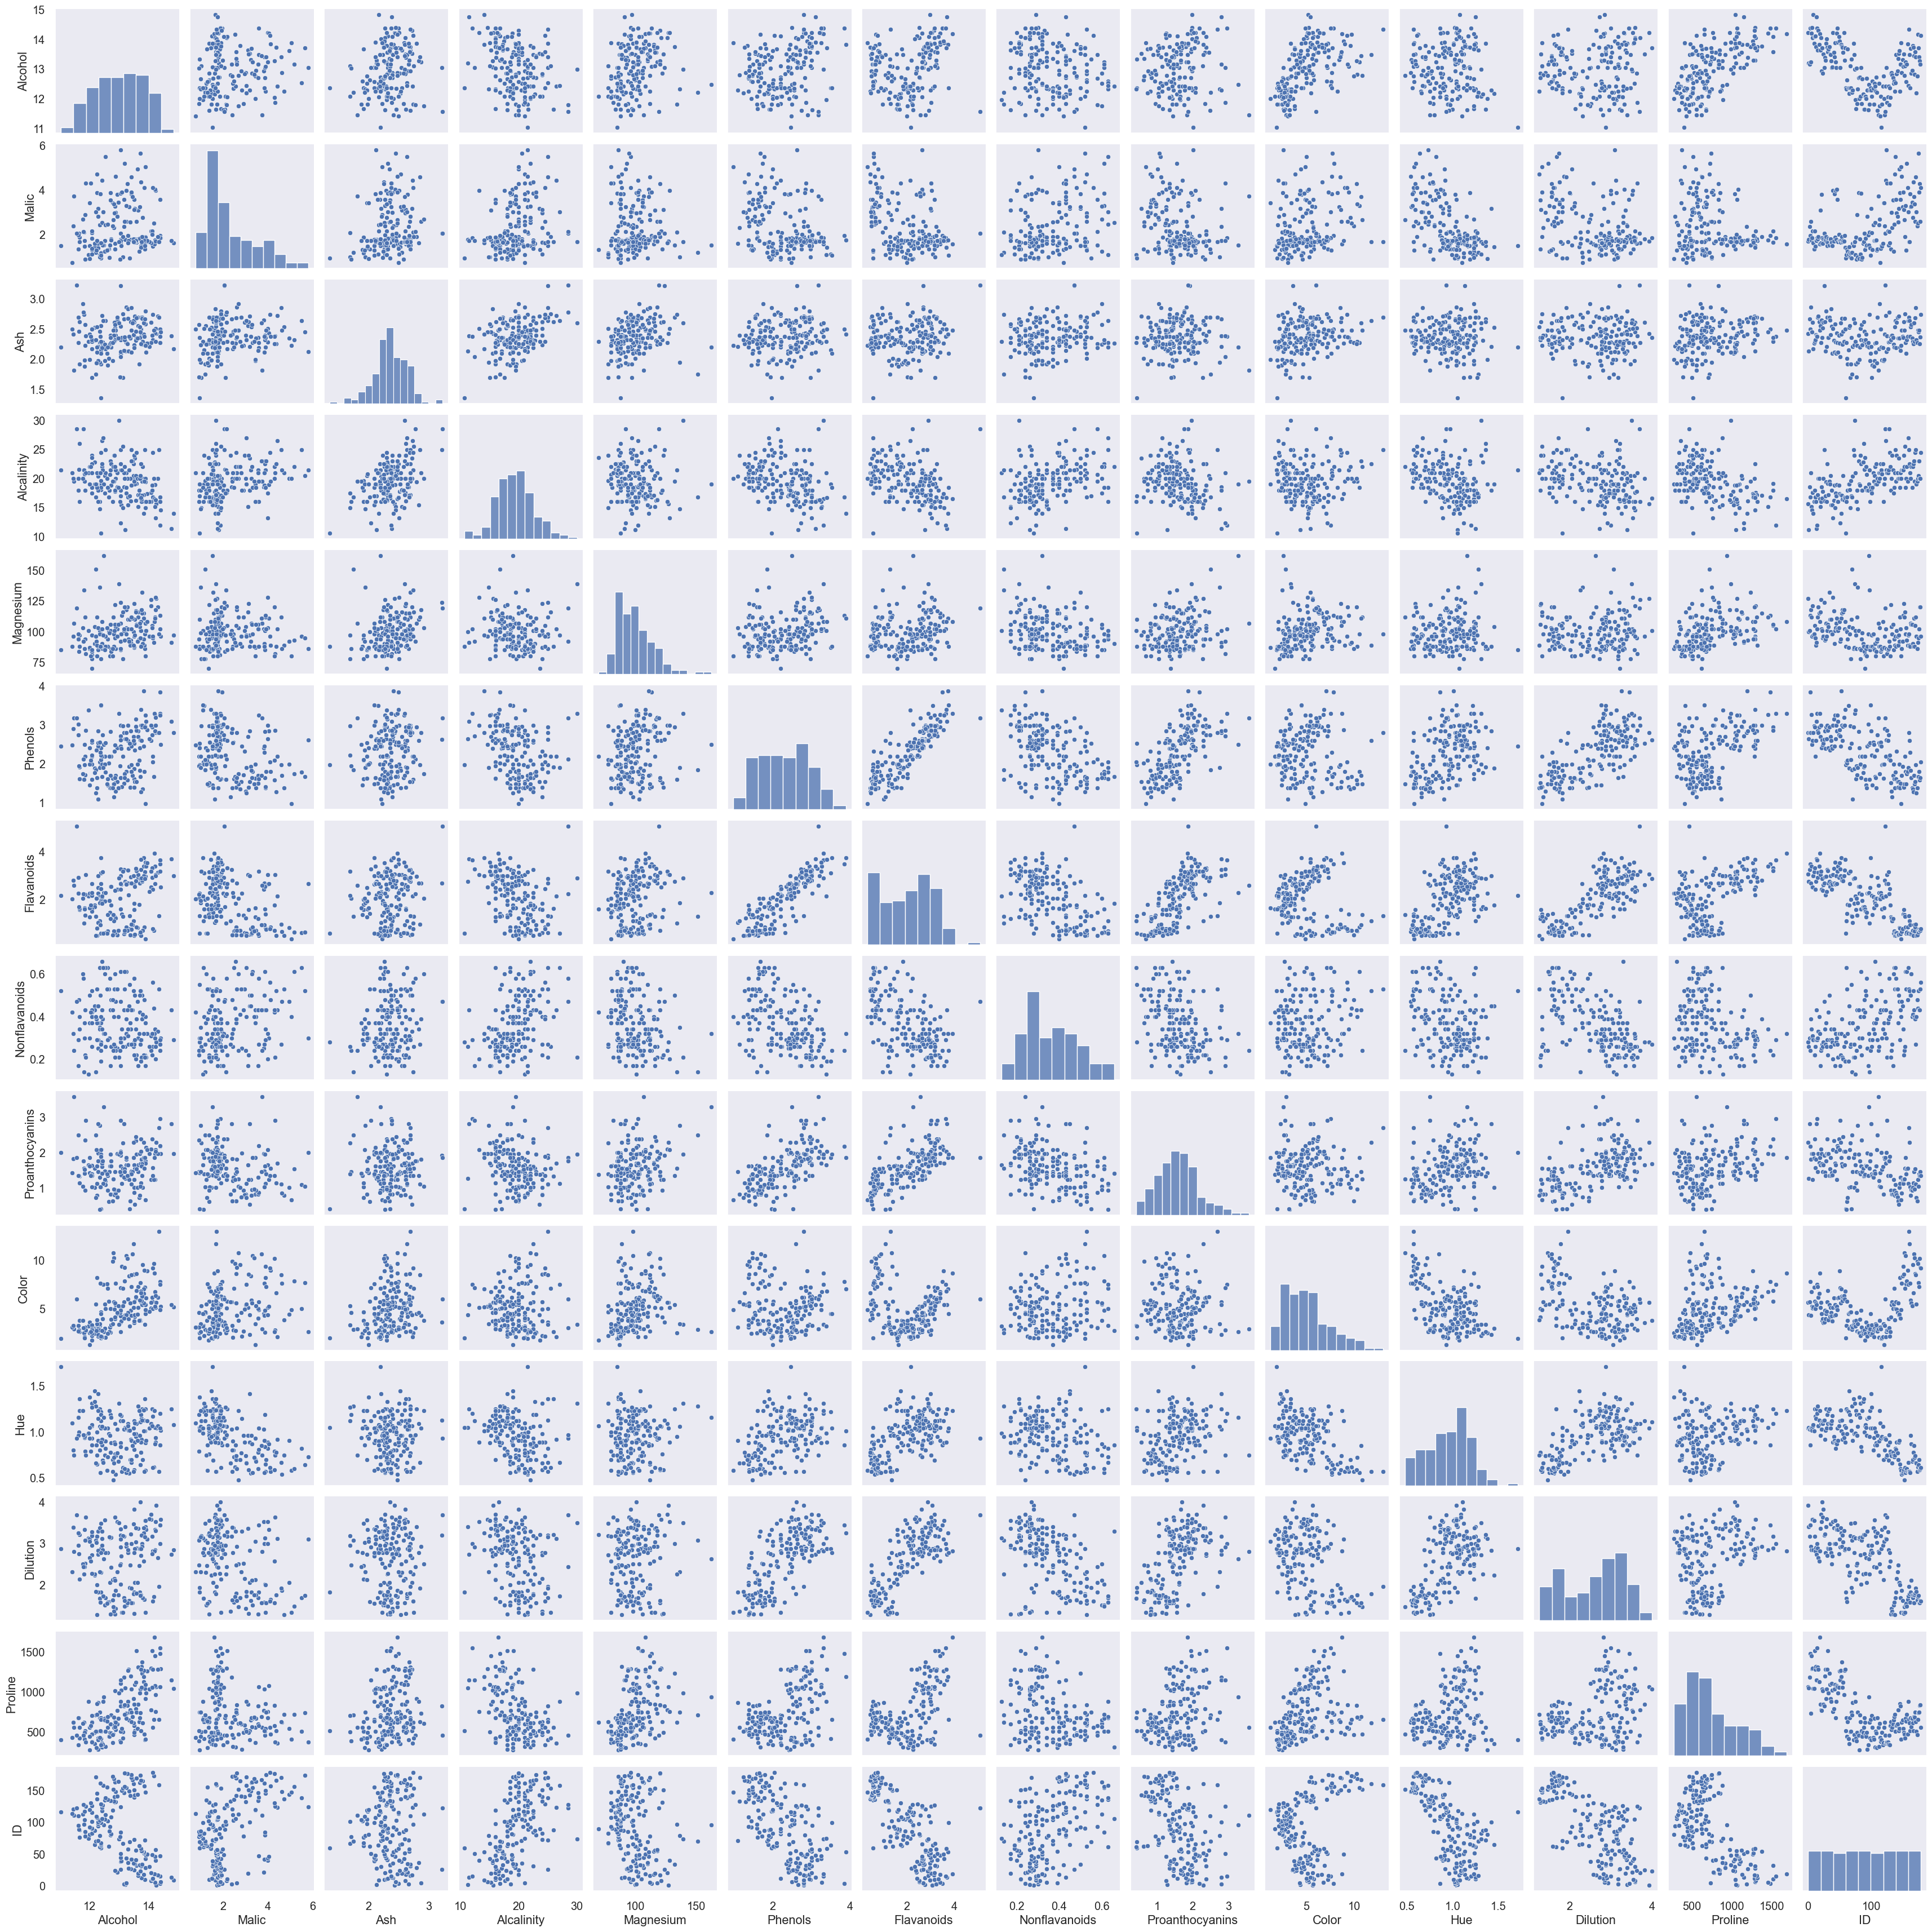

In [21]:
sns.pairplot(df,palette="dark")

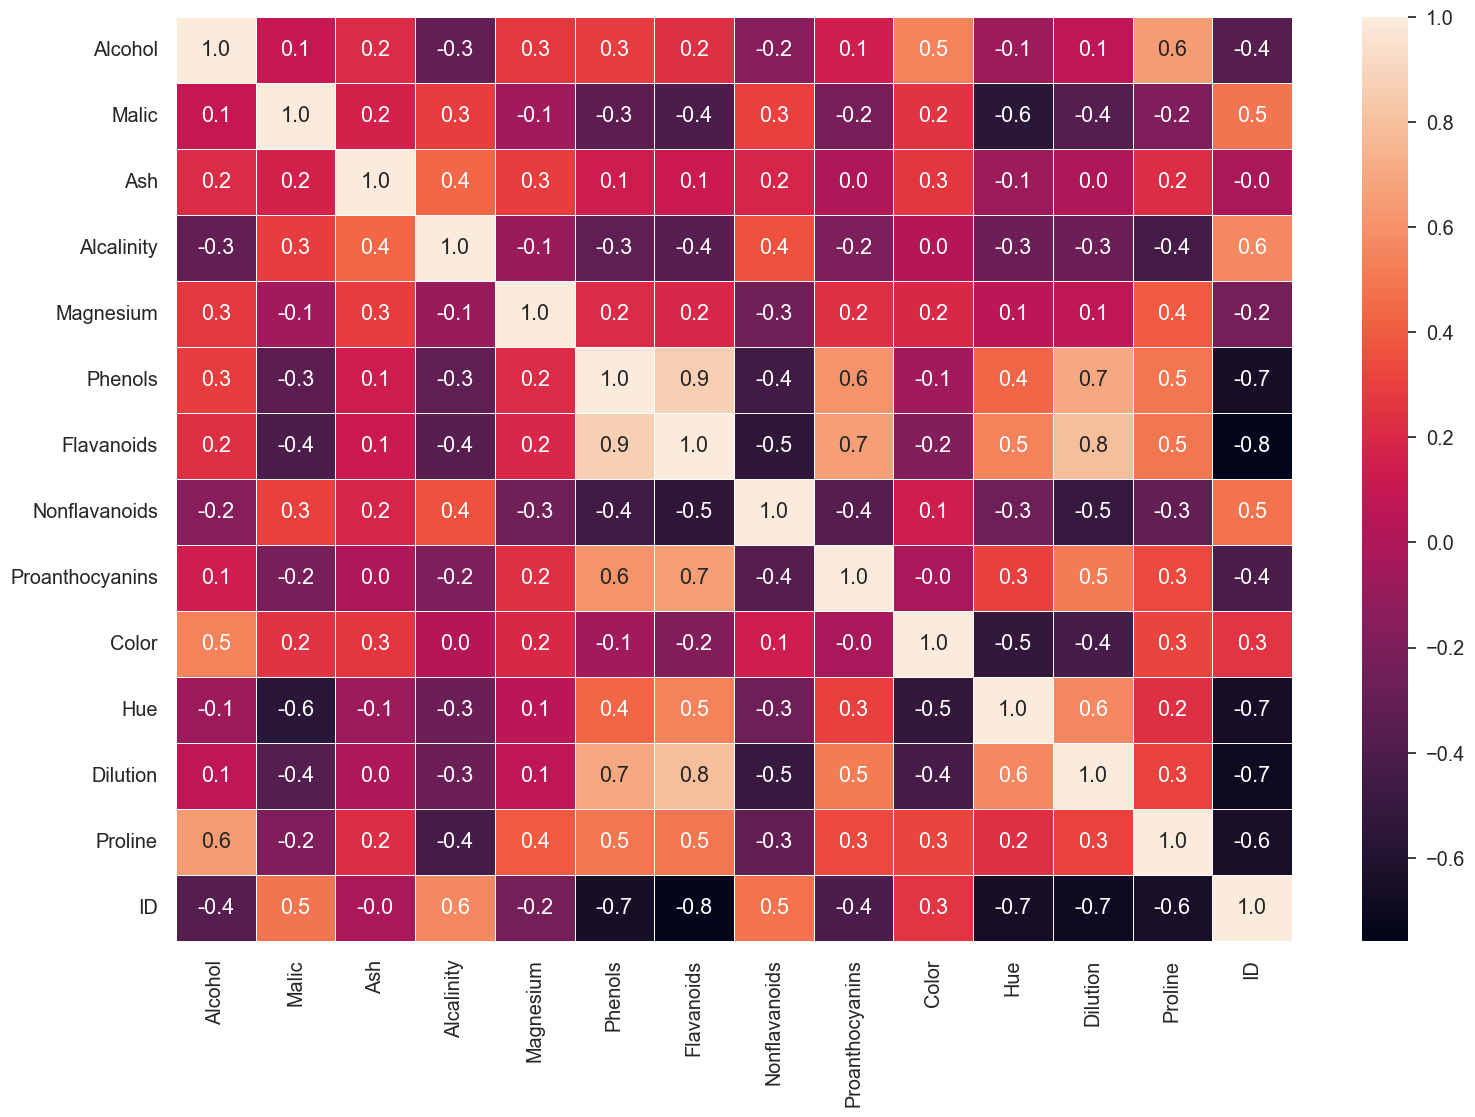

In [22]:
# correlation heatmap

f,ax = plt.subplots(figsize=(18,12))
sns.heatmap(df.corr(), annot=True, linewidths =.5, fmt ='.1f',ax=ax)
plt.show()

<b>Unique points in this correlation matrix:</b>

+ Phenols is positively correlated with Flavanoids, Dilution and Proanthocyanins
+ Flavanoids is positively correlated with Proanthocyanins and Dilution
+ Dilution is positively correlated with Hue
+ Alcohol is positively correlated with Proline

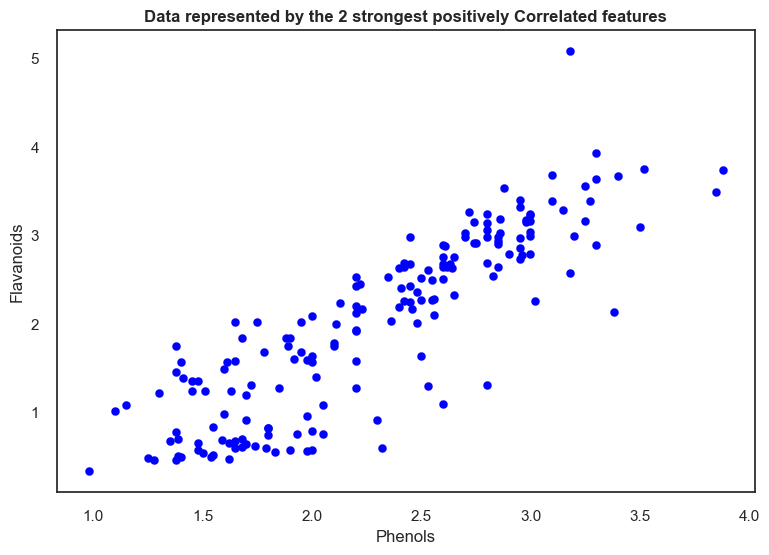

In [23]:
# Plotting frequent flying Phenols vs. Flavanoids  
sns.set(style='white', rc={'figure.figsize':(9,6)},font_scale=1)

plt.scatter(x=df['Phenols'], y=df['Flavanoids'], color='blue',lw=0.1)
plt.xlabel('Phenols')
plt.ylabel('Flavanoids')
plt.title('Data represented by the 2 strongest positively Correlated features',fontweight='bold')
plt.show()

## 5. Data Preprocessing<a class="anchor" id="5"></a>

### 5.1) Applying Standard Scaler on the Data<a class="anchor" id="5.1"></a>

[Table of Contents](#0.1)

In [24]:
standard_scaler = StandardScaler()
std_df = standard_scaler.fit_transform(df)
std_df.shape

(178, 14)

### 5.2) Applying MinMax Scaler on Dataset<a class="anchor" id="5.2"></a>

In [25]:
# Using Minmaxscaler for accuracy result comparison

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

minmax_df = minmax.fit_transform(df)
minmax_df.shape

(178, 14)

## 6. PCA<a class="anchor" id="6"></a>
<b>Principal Component Analysis (PCA)</b> was the first dimensionality reduction technique discovered (by Karl Pearson - yes, the guy from Pearson's correlation coefficient) and dates back to as early as <b>1901</b>. It is very popular because it is <b>fast, easy to implement and easy to interpret.

PCA works by finding a low dimensional subspace that <b>maximises the variance</b> of the data in that subspace and performing a <b>linear projection.</b> This basically means the data will be as <b>spread out</b> as possible, without changing the relationship between the data points. This allows us to find patterns or indentify clusters if any exist.

### Principal Component Analysis
Let's discuss PCA! Since this isn't exactly a full machine learning algorithm, but instead an unsupervised learning algorithm.

#### PCA Review

# ![Filter Method](https://github.com/krishnaik06/Dimesnsionality-Reduction/raw/67a479eaaac811803a7a00bf182062e888d3fd8b//PCA.png)

### 6.1 PCA on Standard Scaled Dataset<a class="anchor" id="6.1"></a>

[Table of Contents](#0.1)

##### Explained variance

Explained variance shows how much of the variance/spread of the data is captured in each dimension, i.e. how important each additional principal component is to the original data representation.

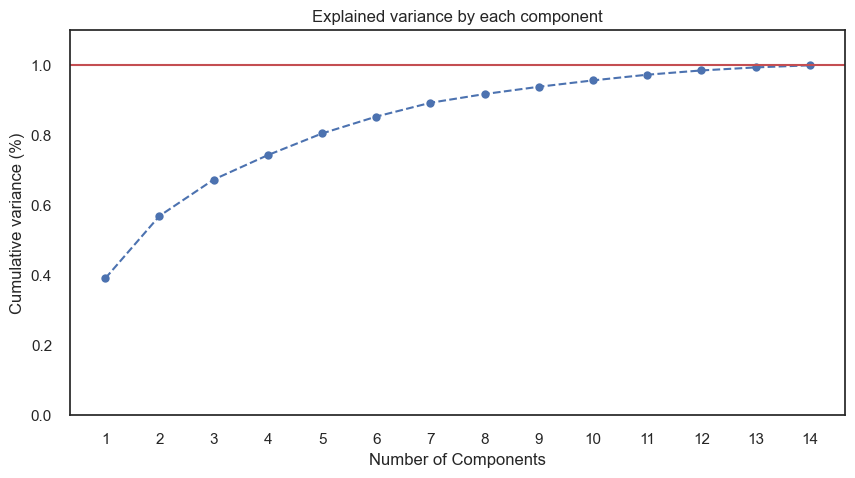

In [26]:
# PCA
pca_var = PCA()
pca_var.fit(std_df)

# Plot
plt.figure(figsize=(10,5))
xi = np.arange(1, 1+std_df.shape[1], step=1)
yi = np.cumsum(pca_var.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

# Aesthetics
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+std_df.shape[1], step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.gca().xaxis.grid(False)

In [27]:
# the amount of variance that each PCA explains is 
var = pca_var.explained_variance_ratio_
var 

array([0.39129819, 0.17835849, 0.10392085, 0.06990396, 0.06183992,
       0.04819035, 0.03948381, 0.02490743, 0.02078919, 0.01822808,
       0.01621756, 0.01222483, 0.00864803, 0.0059893 ])

Text(0.5, 1.0, 'Explained variance by each component')

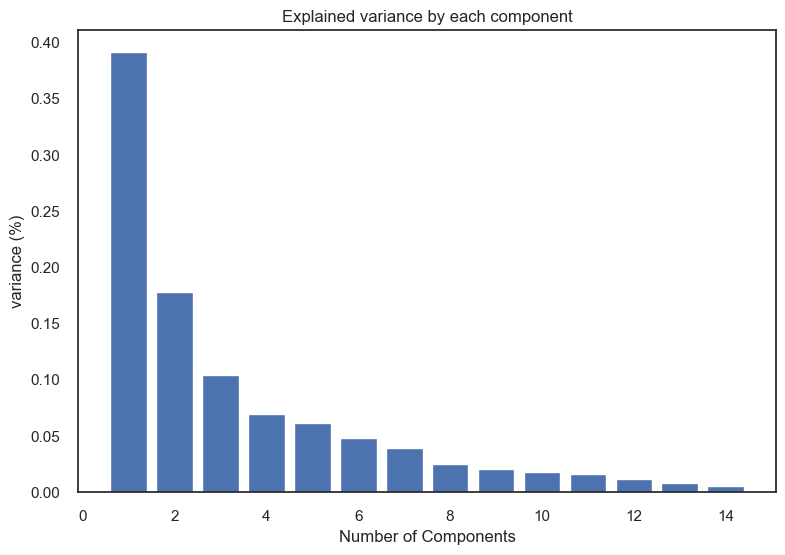

In [28]:
plt.bar(range(1, len(var)+1),var)
plt.xlabel('Number of Components')
plt.ylabel('variance (%)')
plt.title('Explained variance by each component')

In [29]:
# Cumulative Variance
var1 = np.cumsum(np.round(var,decimals = 4)*100)
var1

array([39.13, 56.97, 67.36, 74.35, 80.53, 85.35, 89.3 , 91.79, 93.87,
       95.69, 97.31, 98.53, 99.39, 99.99])

In [30]:
# PCA
pca = PCA(n_components=3)
pca_std = pca.fit_transform(std_df)

# Convert to data frame
pca_std_df = pd.DataFrame(data = pca_std, columns = ['PC1', 'PC2','PC3'])

# Shape and preview
print(pca_std_df.shape)
pca_std_df.head()

(178, 3)


PC1       PC2       PC3
0  3.723816 -1.447476 -0.153274
1  2.734987  0.334166 -2.079717
2  2.944840 -1.033583  0.979570
3  4.094144 -2.762344 -0.123541
4  1.550429 -0.867267  1.915570

#### PCA plot in 2D

Text(0, 0.5, 'PC2')

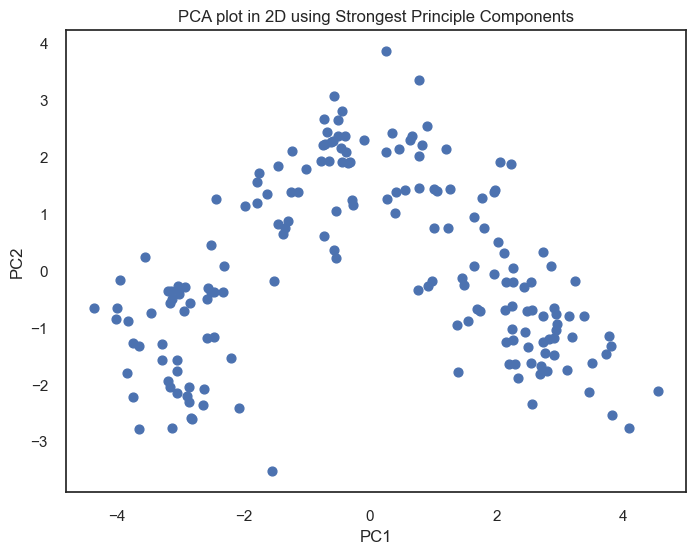

In [31]:
# Figure size
plt.figure(figsize=(8,6))

# Scatterplot
plt.scatter(pca_std_df.iloc[:,0], pca_std_df.iloc[:,1], s=40)

# Aesthetics
plt.title('PCA plot in 2D using Strongest Principle Components')
plt.xlabel('PC1')
plt.ylabel('PC2')

### 6.2 PCA on MinMax Scaled Dataset<a class="anchor" id="6.2"></a>

[Table of Contents](#0.1)

##### Explained variance

Explained variance shows how much of the variance/spread of the data is captured in each dimension, i.e. how important each additional principal component is to the original data representation.

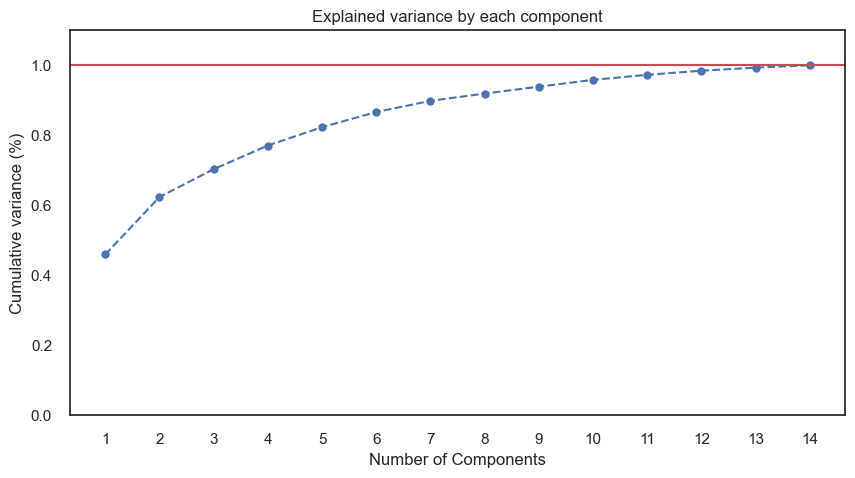

In [32]:
# PCA
pca_var = PCA()
pca_var.fit(minmax_df)

# Plot
plt.figure(figsize=(10,5))
xi = np.arange(1, 1+minmax_df.shape[1], step=1)
yi = np.cumsum(pca_var.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

# Aesthetics
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+minmax_df.shape[1], step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.gca().xaxis.grid(False)

It is interesting to see that with just 2 components we capture over 50% of the variance. And by moving up to 3 components, we get 2 thirds of the variance.

For this reason, sometimes PCA is used for feature selection. For very big datasets with hundreds of features, it can take a long time to train models with some features not adding much value. A solution is to reduce the number of columns by using principal components from PCA. The number of components is normally chosen by looking at the explained variance graph (e.g. a minimum of 60% might be required).

In [33]:
# the amount of variance that each PCA explains is 
var = pca_var.explained_variance_ratio_
var 

array([0.459506  , 0.16420046, 0.07951977, 0.06762289, 0.05235124,
       0.04342315, 0.03180871, 0.02082412, 0.01966956, 0.01951889,
       0.01435926, 0.01185743, 0.0086919 , 0.0066466 ])

Text(0.5, 1.0, 'Explained variance by each component')

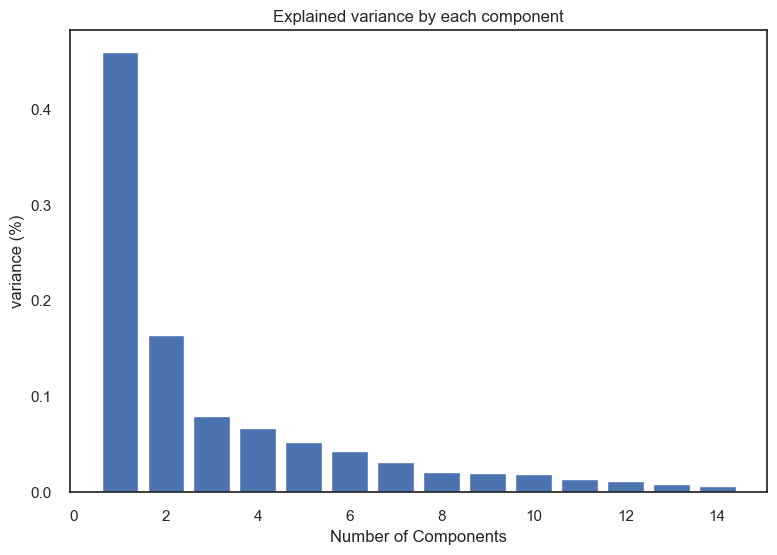

In [34]:
plt.bar(range(1, len(var)+1),var)
plt.xlabel('Number of Components')
plt.ylabel('variance (%)')
plt.title('Explained variance by each component')

In [35]:
# Cumulative Variance
var1 = np.cumsum(np.round(var,decimals = 4)*100)
var1

array([ 45.95,  62.37,  70.32,  77.08,  82.32,  86.66,  89.84,  91.92,
        93.89,  95.84,  97.28,  98.47,  99.34, 100.  ])

In [36]:
# PCA
pca = PCA(n_components=3)
pca_minmax = pca.fit_transform(minmax_df)

# Convert to data frame
pca_minmax_df = pd.DataFrame(data = pca_minmax, columns = ['PC1', 'PC2','PC3'])

# Shape and preview
print(pca_minmax_df.shape)
pca_minmax_df.head()

(178, 3)


PC1       PC2       PC3
0  0.864955 -0.246505  0.012715
1  0.676158 -0.011751 -0.306279
2  0.692172 -0.186686  0.139093
3  0.955057 -0.568299  0.123337
4  0.411640 -0.067685  0.118278

##### The new columns are called Principal Components (PC's) and give the coordinates of the data in the new smaller space

#### PCA plot in 2D

Text(0, 0.5, 'PC2')

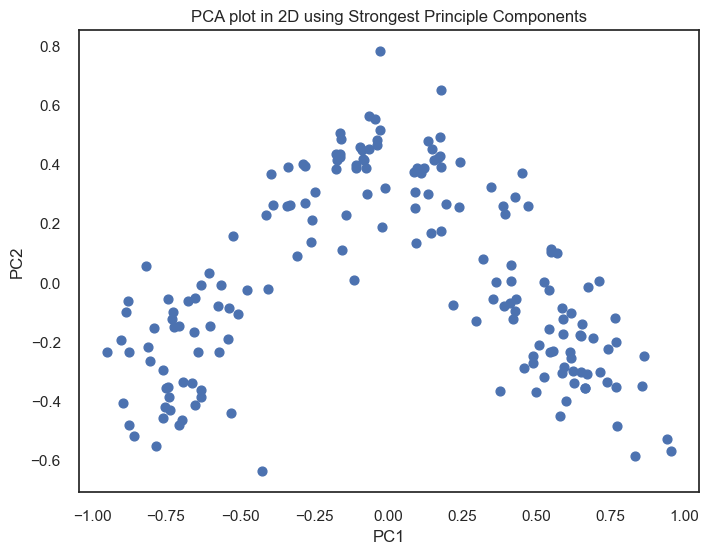

In [37]:
# Figure size
plt.figure(figsize=(8,6))

# Scatterplot
plt.scatter(pca_minmax_df.iloc[:,0], pca_minmax_df.iloc[:,1], s=40)

# Aesthetics
plt.title('PCA plot in 2D using Strongest Principle Components')
plt.xlabel('PC1')
plt.ylabel('PC2')

##### Notes:

+ Notice how these points have <b>no colours</b> (yet) because we don't know what their classes are. This is what makes it an <b>unsupervised method.</b>
+ We know our dataset falls naturally into 3 classes (3 types of wine), so we assign colours by <b>clustering</b> the data into 3 groups using techniques such as <b>k-Means</b> and <b>Hierarchical</b>.

[Table of Contents](#0.1)

## 7. KMeans Clustering<a class="anchor" id="7"></a>
k-Means is an iterative clustering algorithm that works as follows:

Choose coordinates (e.g. randomly) for the locations of the k centroids. Group datapoints together by finding the nearest centroid. (There will always be k goups). Calculate the new centre of each centroid by taking the mean position of datapoints in each group. Iterative until the centroids stop moving by a significant amount. k-Means is popular because it is a reliable (always converges) and relatively fast algorithm. The main downside is that you have to decide what the value of k should be beforehand. (Although there are techniques to help with this).

After all the analyses we now start with the K-Means Clustering procedure

K-means is a centroid-based algorithm, or a distance-based algorithm, where we calculate the distances to assign a point to a cluster. In K-Means, each cluster is associated with a centroid.

The main objective of the K-Means algorithm is to minimize the sum of distances between the points and their respective cluster centroid. The first step in k-means is to pick the number of clusters, k. Then keep the iterations running until one of the below satisifes:

1. Centroids of newly formed clusters do not change
2. Points remain in the same cluster
3. Maximum number of iterations are reached

In K Means clustering we need to first assign the K number of clusters which can be taken up using the thumb rule of "Sqrt(n)/2" or plotting the Elbow curve, aka Scree plot.

### 7.1 Elbow Method for Determining Cluster Amount on PCA Standard Scaled Dataset<a class="anchor" id="7.1"></a>

In [38]:
inertia = []
for i in tqdm(range(2,10)):
    kmeans = KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(pca_std_df)
    inertia.append(kmeans.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 17.32it/s]


In [39]:
silhouette = {}
for i in tqdm(range(2,10)):
    kmeans = KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(pca_std_df)
    silhouette[i] = sil(pca_std_df, kmeans.labels_, metric='euclidean')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 17.40it/s]


<b>Internal measures for cluster validation

+ The goal of partitioning clustering algorithms is to split the data set into clusters of objects, such that:

the objects in the same cluster are similar as much as possible,
and the objects in different clusters are highly distinct
That is, we want the average distance within cluster to be as small as possible; and the average distance between clusters to be as large as possible.

Internal validation measures reflect often the compactness, the connectedness and the separation of the cluster partitions.

+ Compactness or cluster cohesion: Measures how close are the objects within the same cluster. A lower within-cluster variation is an indicator of a good compactness (i.e., a good clustering). The different indices for evaluating the compactness of clusters are base on distance measures such as the cluster-wise within average/median distances between observations.
+ Separation: Measures how well-separated a cluster is from other clusters. The indices used as separation measures include:
distances between cluster centers
the pairwise minimum distances between objects in different clusters
+ Connectivity: corresponds to what extent items are placed in the same cluster as their nearest neighbors in the data space. The connectivity has a value between 0 and infinity and should be minimized.
Generally most of the indices used for internal clustering validation combine compactness and separation measures as follow:

Index=(α×Separation)(β×Compactness)

Where α and β are weights.

In this section, we’ll describe the two commonly used indices for assessing the goodness of clustering: the silhouette width and the Dunn index. These internal measure can be used also to determine the optimal number of clusters in the data.



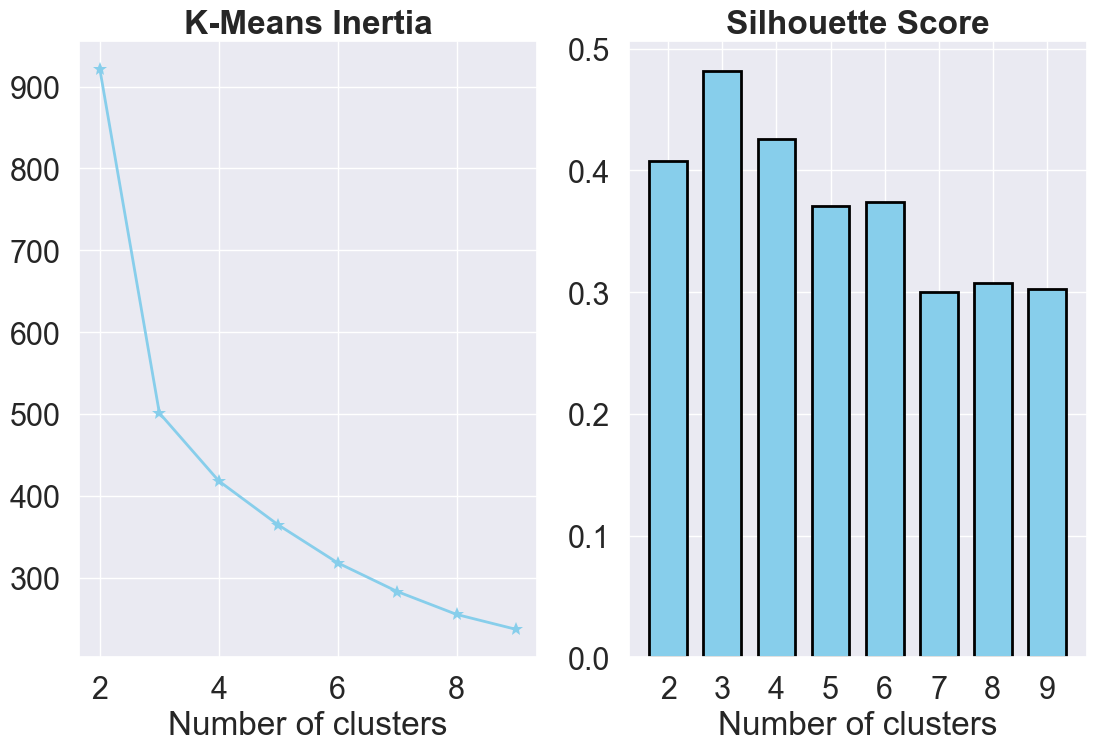

In [40]:
sns.set(style="darkgrid", rc={'figure.figsize':(13,8)}, font_scale=2)

plt.subplot(1,2,1)
plt.plot(range(2,len(inertia)+2), inertia, marker="*", lw=2, color="skyblue", ms=10)
plt.xlabel("Number of clusters")
plt.title("K-Means Inertia", fontweight='bold')

plt.subplot(1,2,2)
plt.bar(range(len(silhouette)), list(silhouette.values()), align='center', width=.7, edgecolor="black", lw=2, color="skyblue" )
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.xlabel("Number of clusters")
plt.title("Silhouette Score", fontweight='bold')

plt.show()

##### There is a clearly visible "elbow" . A choice of 3 clusters seems to be fair the maximum silhouette score also indicates that.

### 7.2 Silhouette Score<a class="anchor" id="7.2"></a>

<b>Silhouette coefficient

+ The silhouette analysis measures how well an observation is clustered and it estimates the average distance between clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters.

For each observation i, the silhouette width si is calculated as follows:

For each observation i, calculate the average dissimilarity ai between i and all other points of the cluster to which i belongs. \
For all other clusters C, to which i does not belong, calculate the average dissimilarity d(i,C) of i to all observations of C. The smallest of these d(i,C) is defined as bi=minCd(i,C). The value of bi can be seen as the dissimilarity between i and its “neighbor” cluster, i.e., the nearest one to which it does not belong.
    

+ Finally the silhouette width of the observation i is defined by the formula: Si=(bi−ai)/max(ai,bi).\
Silhouette width can be interpreted as follow:

Observations with a large Si (almost 1) are very well clustered.\
A small Si (around 0) means that the observation lies between two clusters.\
Observations with a negative Si are probably placed in the wrong cluster.

In [41]:
from sklearn.metrics import silhouette_score
n_clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
clusters_inertia = [] # inertia of clusters
s_scores = [] # silhouette scores

for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(pca_std_df)
    clusters_inertia.append(KM_est.inertia_)    # data for the elbow method
    silhouette_avg = silhouette_score(pca_std_df, KM_est.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

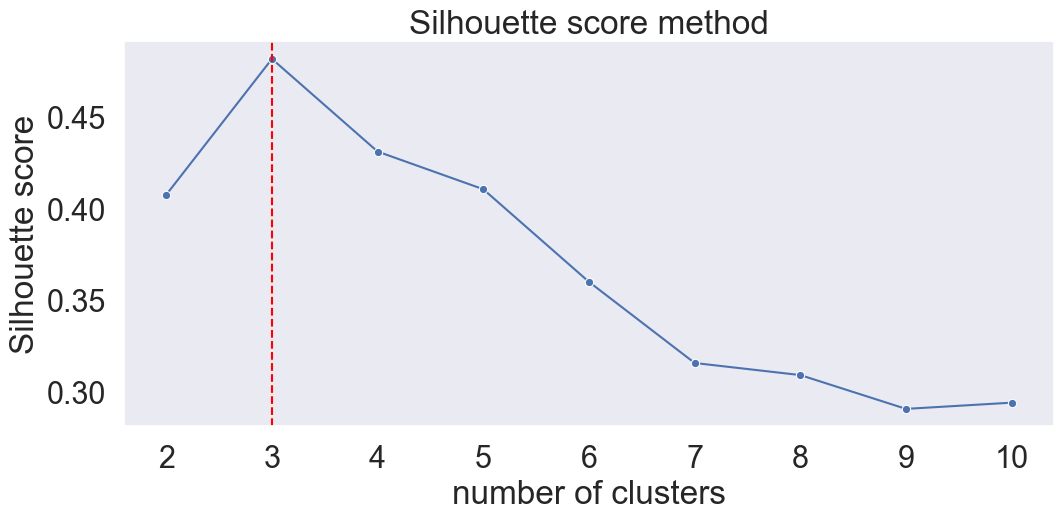

In [42]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=n_clusters, y=s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(3, ls="--", c="red")
plt.grid()
plt.show()

##### Silhouette score method indicates the best options would be respectively 3 clusters.

Elbow Plot for Standard Scaler data


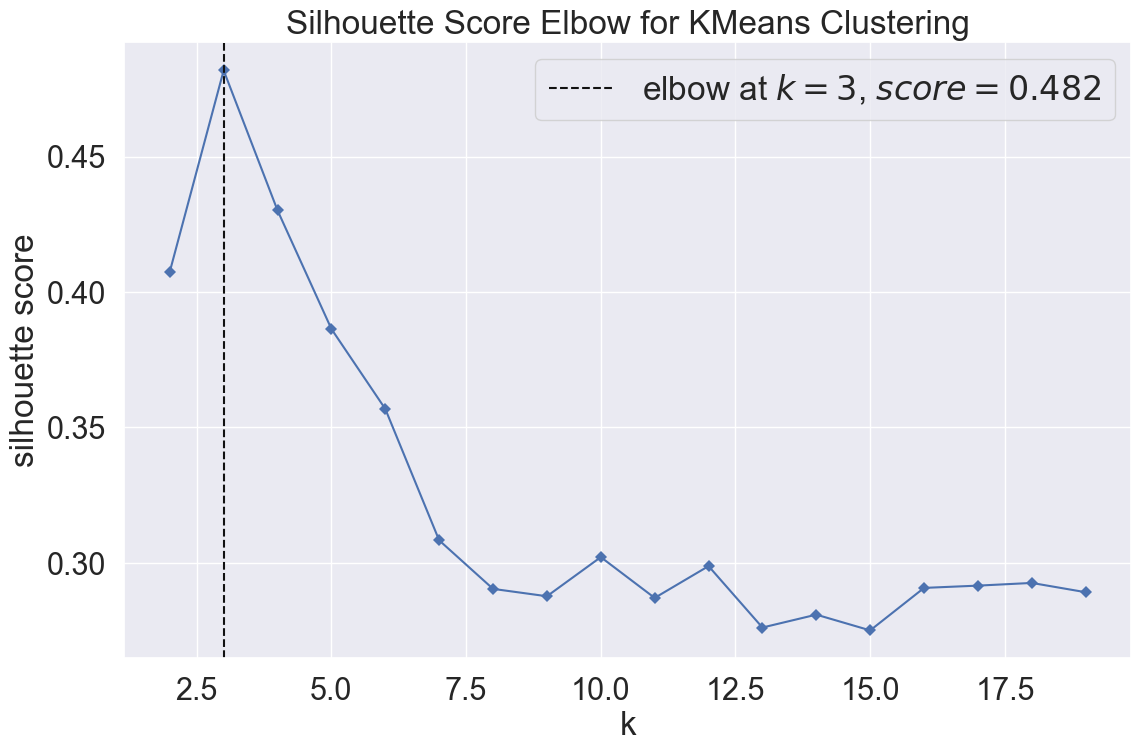

In [43]:
# 1. How many number of clusters? n_clusters?

# Since true labels are not known..we will use Silhouette Coefficient (Clustering performance evaluation)
# knee Elbow graph method


# Instantiate a scikit-learn K-Means model. we will check for two diff hyperparameters value effect.
model = KMeans(random_state=10, max_iter=500, init='k-means++')

# Instantiate the KElbowVisualizer with the number of clusters and the metric
visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette', timings=False)
# Fit the data and visualize
print('Elbow Plot for Standard Scaler data')
visualizer.fit(pca_std_df)    
visualizer.show()
plt.show()

In [44]:
# With the elbow method, the ideal number of clusters to use was 6.
# We will also use the Silhouette score to determine an optimal number.

clust_list = [2,3,4,5,6,7,8,9]

#  Silhouette score for stadardScaler applied on data.

for n_clusters in clust_list:
    clusterer1 = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels1 = clusterer1.fit_predict(pca_std_df)
    sil_score1= sil(pca_std_df, cluster_labels1)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", sil_score1)

For n_clusters = 2 The average silhouette_score is : 0.40748327911080984
For n_clusters = 3 The average silhouette_score is : 0.4817835370724268
For n_clusters = 4 The average silhouette_score is : 0.4310924081843296
For n_clusters = 5 The average silhouette_score is : 0.41489679453806744
For n_clusters = 6 The average silhouette_score is : 0.38372271476753916
For n_clusters = 7 The average silhouette_score is : 0.30996557235673217
For n_clusters = 8 The average silhouette_score is : 0.288629967284236
For n_clusters = 9 The average silhouette_score is : 0.29573468459768787


For n_clusters = 2 The average silhouette_score is : 0.40748327911080984
For n_clusters = 3 The average silhouette_score is : 0.4817835370724268
For n_clusters = 4 The average silhouette_score is : 0.4310924081843296
For n_clusters = 5 The average silhouette_score is : 0.41489679453806744
For n_clusters = 6 The average silhouette_score is : 0.38372271476753916
For n_clusters = 7 The average silhouette_score is : 0.30996557235673217
For n_clusters = 8 The average silhouette_score is : 0.288629967284236
For n_clusters = 9 The average silhouette_score is : 0.29573468459768787


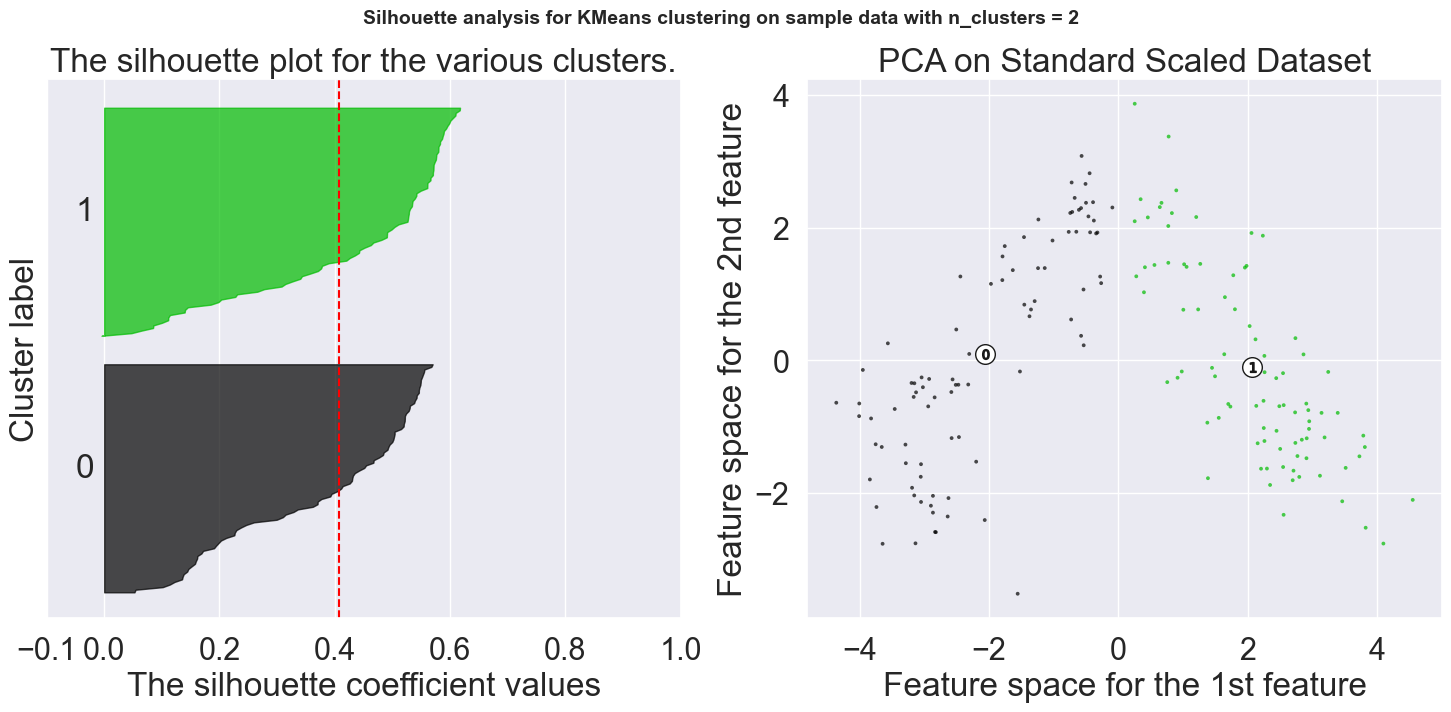

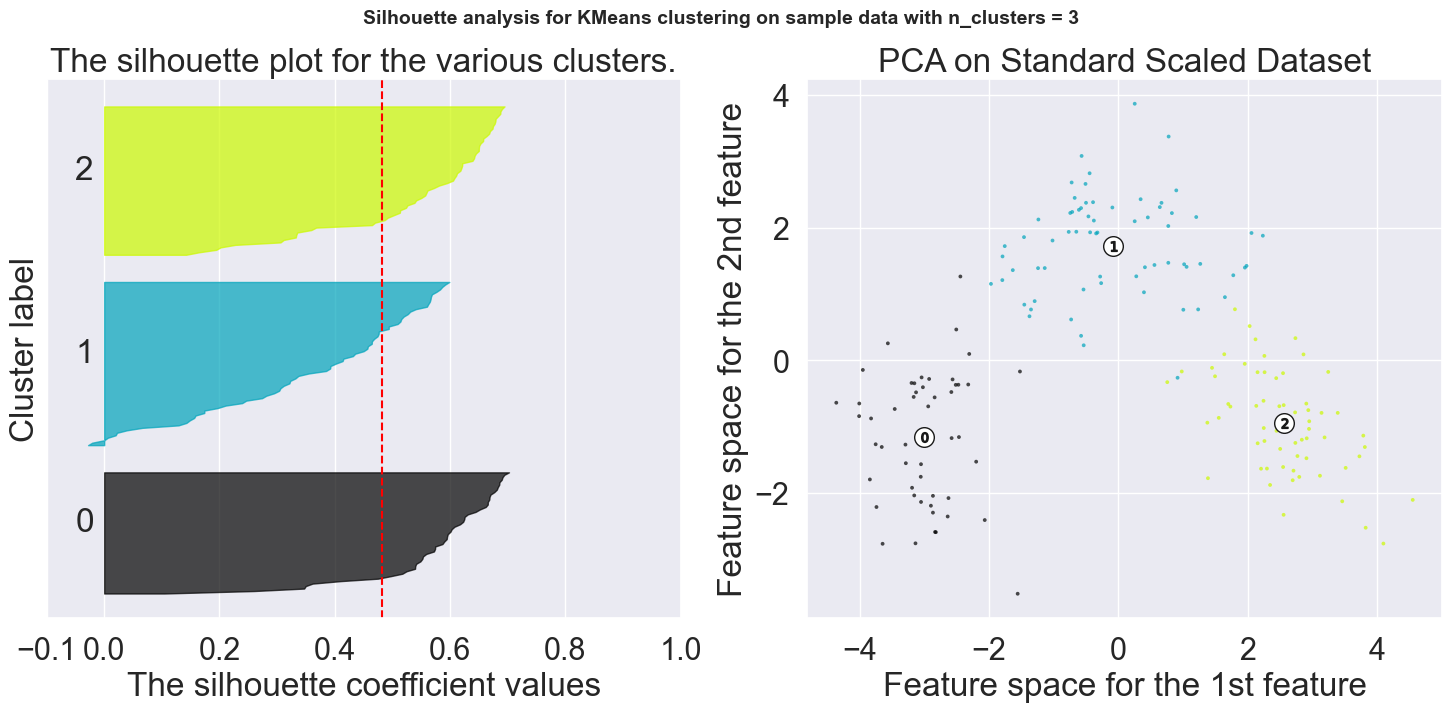

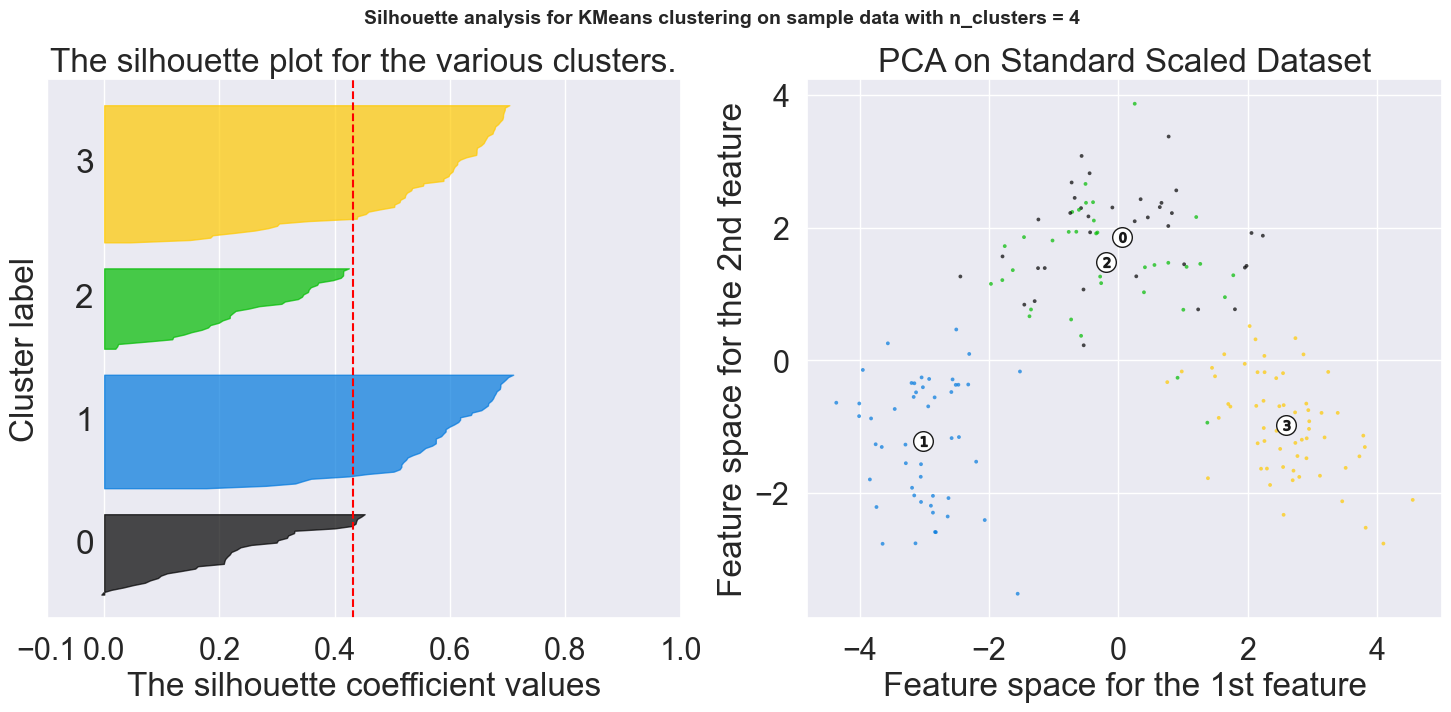

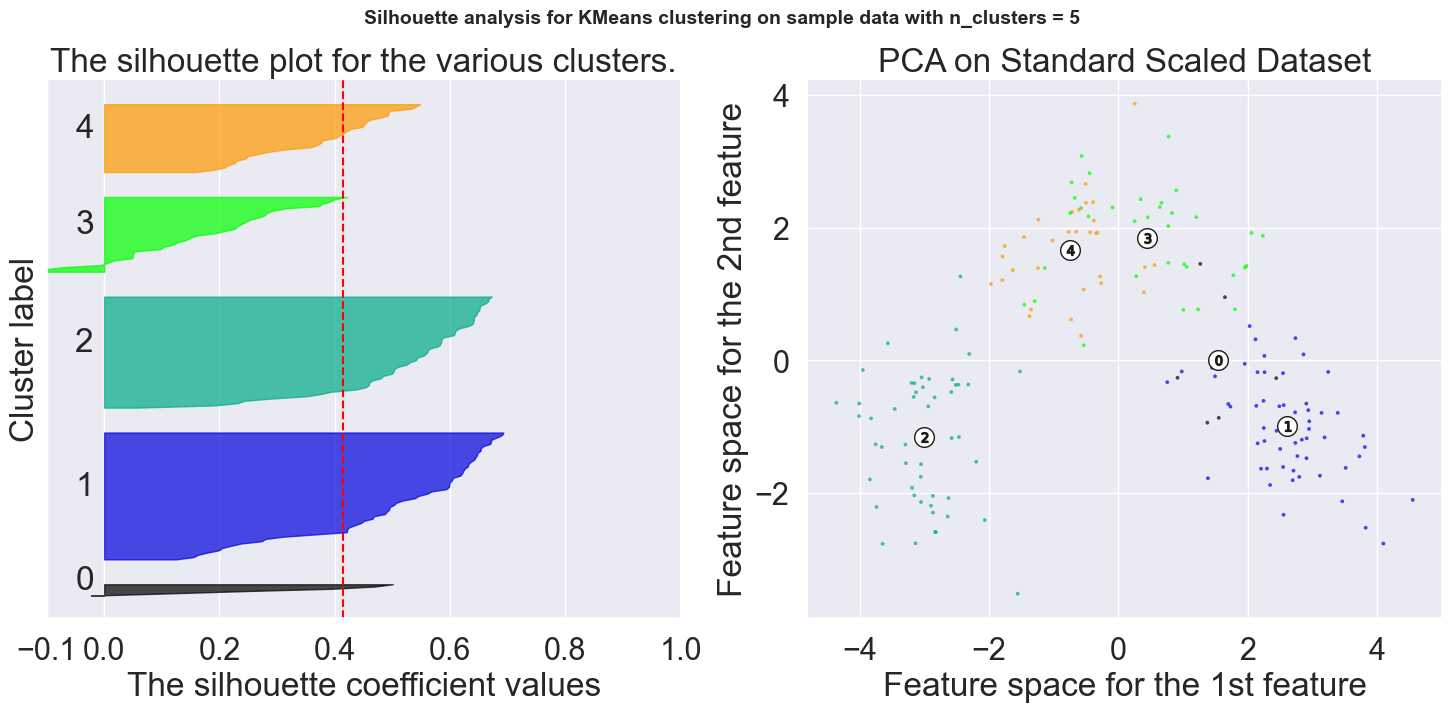

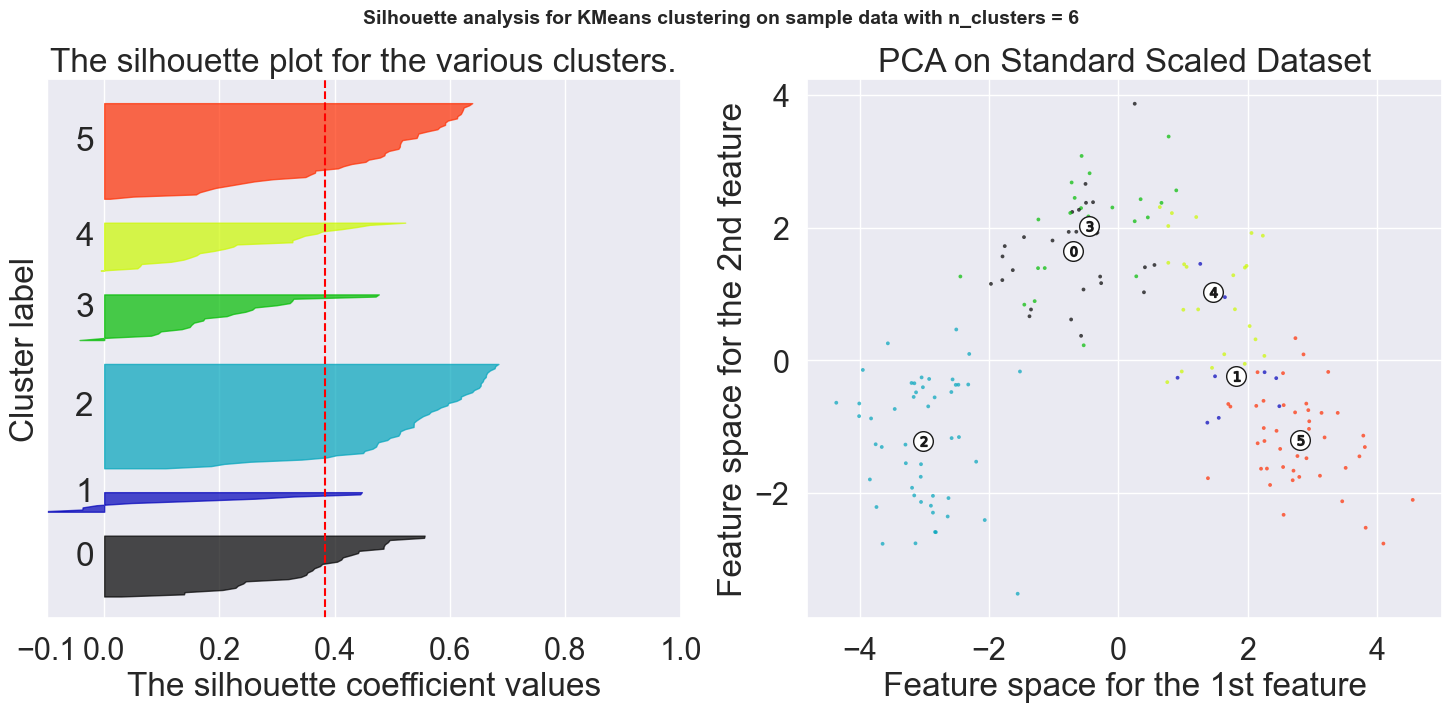

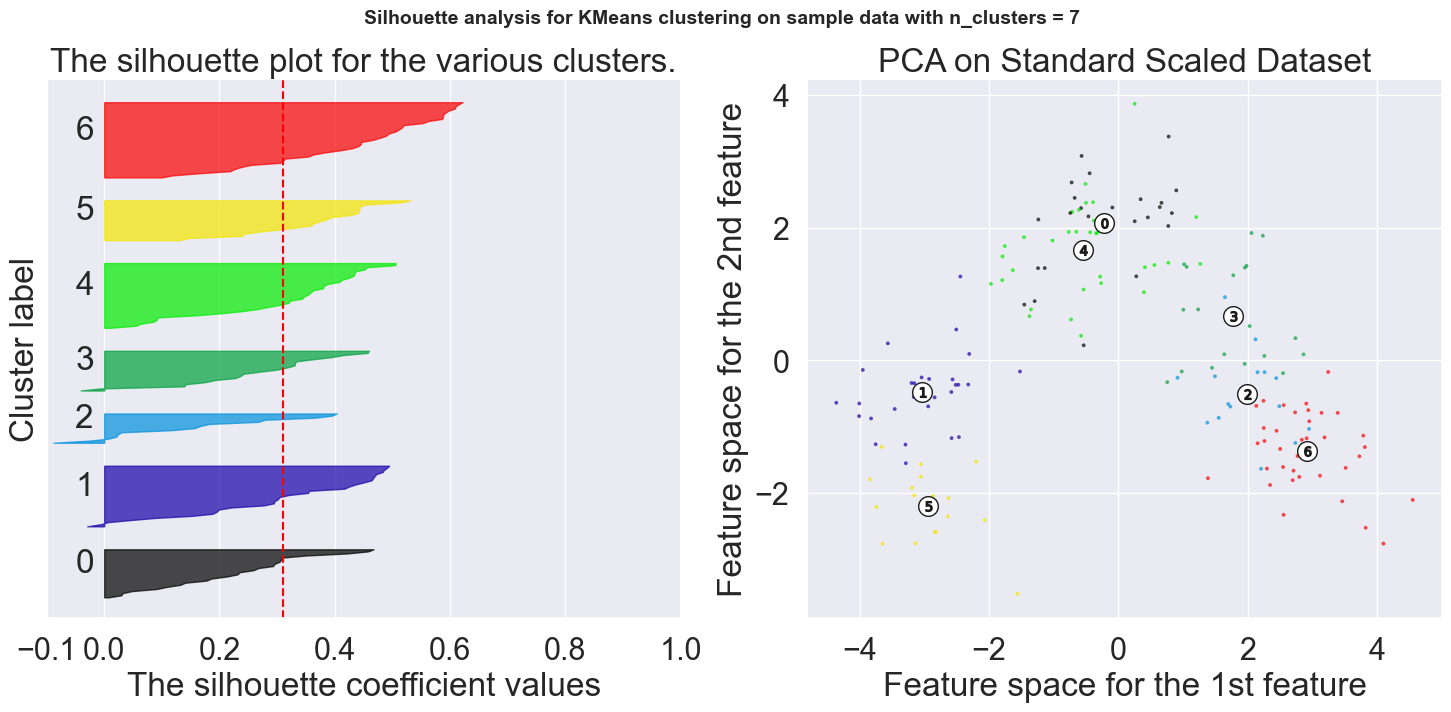

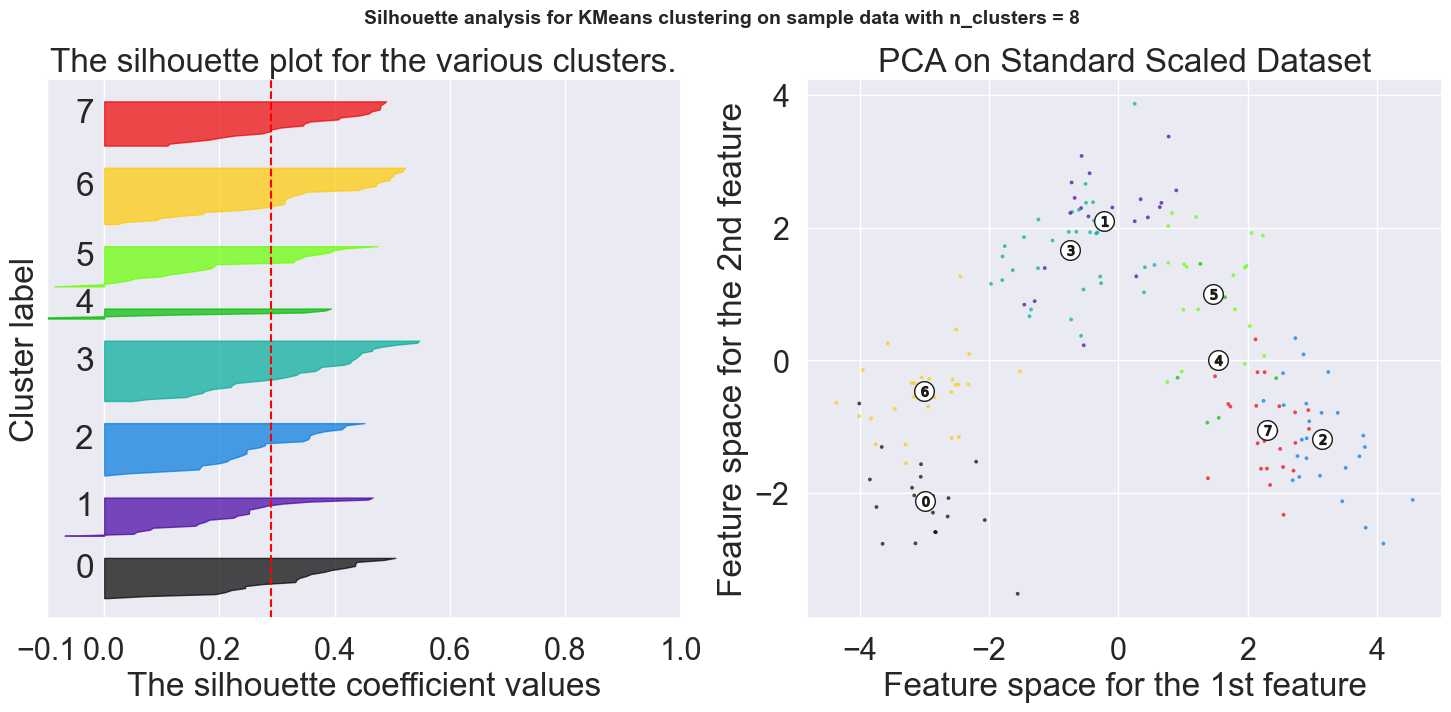

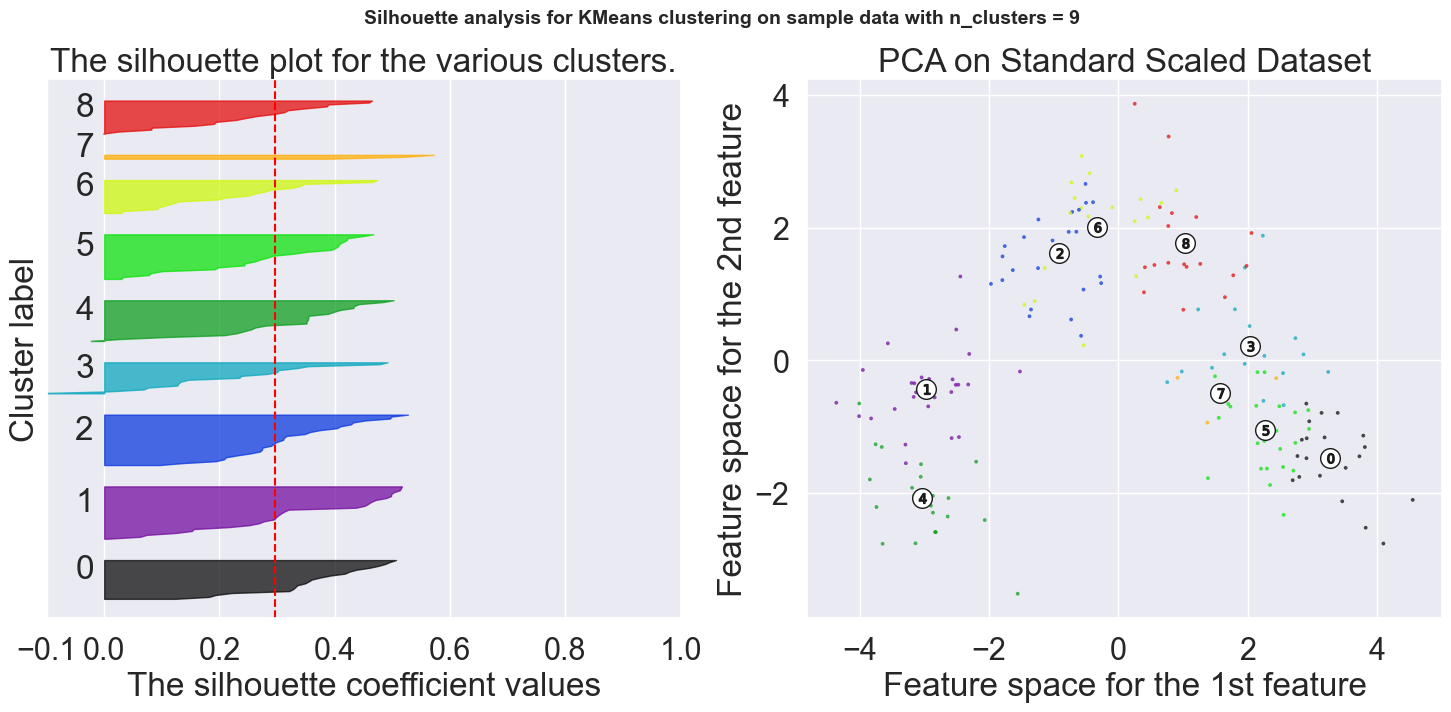

In [45]:
range_n_clusters = [2,3,4,5,6,7,8,9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pca_std_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(pca_std_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sil(pca_std_df, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pca_std_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(pca_std_df.iloc[:,0], pca_std_df.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:,0], centers[:,1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("PCA on Standard Scaled Dataset")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

####  Conclusion:
According the the silhouette score of:

The standardized data, the ideal <b>number of clusters is 3</b>, with a score higher than other options, of <b>0.48

## 7.3 Build KMeans Cluster algorithm using K=3 and PCA on Standard Scaler Applied Dataset <a class="anchor" id="7.3"></a>

[Table of Contents](#0.1)

In [46]:
# we have found good number of cluster = 3
# model building using cluster numbers = 3

model_kmeans = KMeans(n_clusters=3, random_state=0, init='k-means++')
y_predict_kmeans = model_kmeans.fit_predict(pca_std_df)
y_predict_kmeans.shape

(178,)

In [47]:
# these are nothing but cluster labels...

y_predict_kmeans

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [48]:
model_kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [49]:
# cluster centres associated with each lables

model_kmeans.cluster_centers_

array([[-3.00022931, -1.16059366, -0.23271123],
       [-0.08562687,  1.72743604,  0.24903744],
       [ 2.55325354, -0.9460415 , -0.08278602]])

In [50]:
# within-cluster sum of squared

# The lower values of inertia are better and zero is optimal.
# Inertia is the sum of squared error for each cluster. 
# Therefore the smaller the inertia the denser the cluster(closer together all the points are)

model_kmeans.inertia_

501.1748240053778

In [51]:
#Assign clusters to the data set
data['Kmeans_label'] = model_kmeans.labels_

In [52]:
# Group data by Clusters (K=6)
data.groupby('Kmeans_label').agg(['mean'])

Type    Alcohol     Malic       Ash Alcalinity   Magnesium  \
                  mean       mean      mean      mean       mean        mean   
Kmeans_label                                                                   
0             2.960000  13.144000  3.346200  2.425600  21.330000  98.640000    
1             2.000000  12.246418  1.891642  2.242985  20.140299  93.238806    
2             1.032787  13.711475  1.997049  2.453770  17.281967  107.786885   

               Phenols Flavanoids Nonflavanoids Proanthocyanins     Color  \
                  mean       mean          mean            mean      mean   
Kmeans_label                                                                
0             1.677200  0.807000   0.45040       1.156400        7.264400   
1             2.258209  2.085672   0.36194       1.612836        3.059701   
2             2.842131  2.969180   0.28918       1.922951        5.444590   

                   Hue  Dilution      Proline          ID  
                  mean      mean         mean        mean  
Kmeans_label                                               
0             0.686200  1.698800  622.440000   152.380000  
1             1.059493  2.798507  508.597015   95.104478   
2             1.067705  3.154754  1110.639344  31.803279

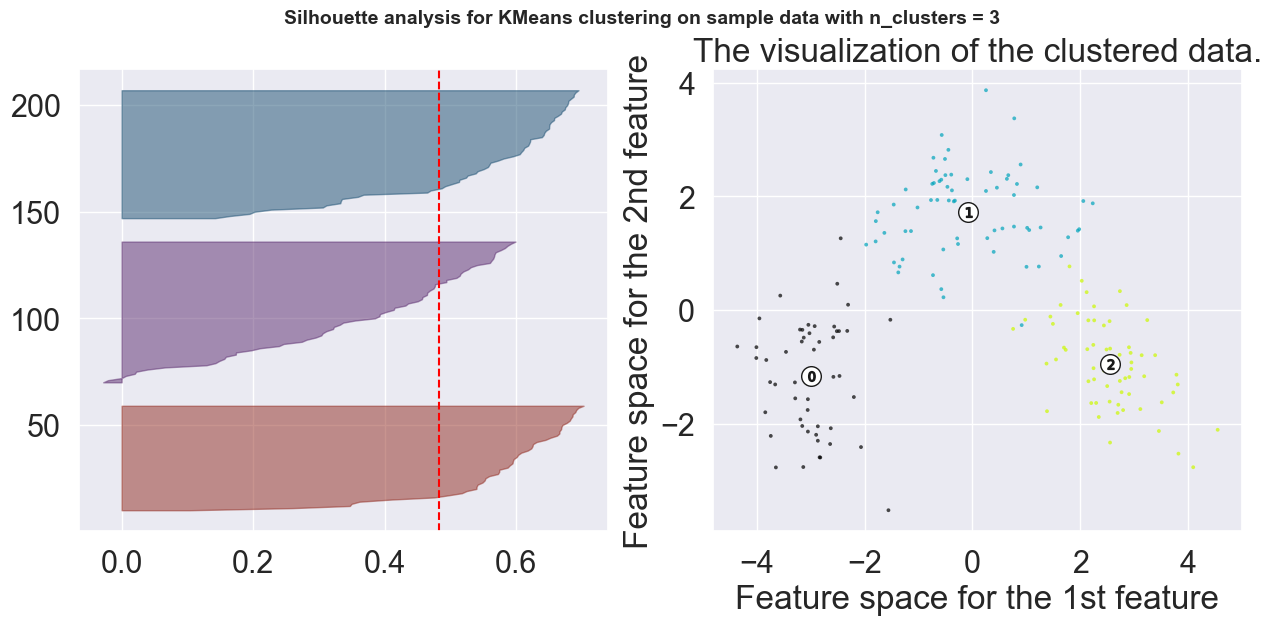

In [53]:
from yellowbrick.cluster import SilhouetteVisualizer

fig,(ax1,ax2) = plt.subplots(1,2,sharey=False)
fig.set_size_inches(15,6)



sil_visualizer1 = SilhouetteVisualizer(model_kmeans,ax= ax1, colors=['#922B21','#5B2C6F','#1B4F72'])
sil_visualizer1.fit(pca_std_df)


# 2nd Plot showing the actual clusters formed

import matplotlib.cm as cm
colors1 = cm.nipy_spectral(model_kmeans.labels_.astype(float) / 3) # 3 is number of clusters
ax2.scatter(pca_std_df.iloc[:, 0], pca_std_df.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors1, edgecolor='k')

# Labeling the clusters
centers1 = model_kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers1[:, 0], centers1[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers1):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')


ax2.set_title(label ="The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % 3),fontsize=14, fontweight='bold')

#sil_visualizer1.show()
plt.show()

### 7.4 Elbow Method and Silhouette Score on PCA MinMaxScaler Applied Data<a class="anchor" id="7.4"></a>

[Table of Contents](#0.1)

In [54]:
inertia = []
for i in tqdm(range(2,10)):
    kmeans = KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(pca_minmax_df)
    inertia.append(kmeans.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 16.56it/s]


In [55]:
silhouette = {}
for i in tqdm(range(2,10)):
    kmeans = KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(pca_minmax_df)
    silhouette[i] = sil(pca_minmax_df, kmeans.labels_, metric='euclidean')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.65it/s]


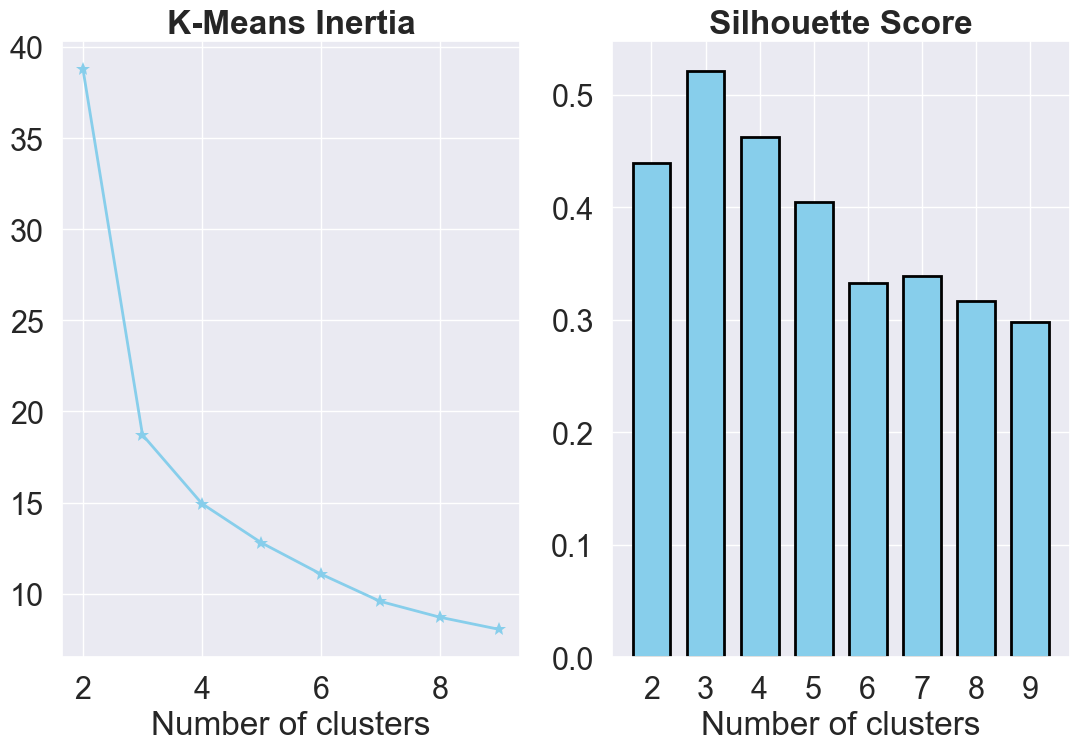

In [56]:
sns.set(style="darkgrid", rc={'figure.figsize':(13,8)}, font_scale=2)

plt.subplot(1,2,1)
plt.plot(range(2,len(inertia)+2), inertia, marker="*", lw=2, color="skyblue", ms=10)
plt.xlabel("Number of clusters")
plt.title("K-Means Inertia", fontweight='bold')

plt.subplot(1,2,2)
plt.bar(range(len(silhouette)), list(silhouette.values()), align='center', width=.7, edgecolor="black", lw=2, color="skyblue" )
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.xlabel("Number of clusters")
plt.title("Silhouette Score", fontweight='bold')

plt.show()

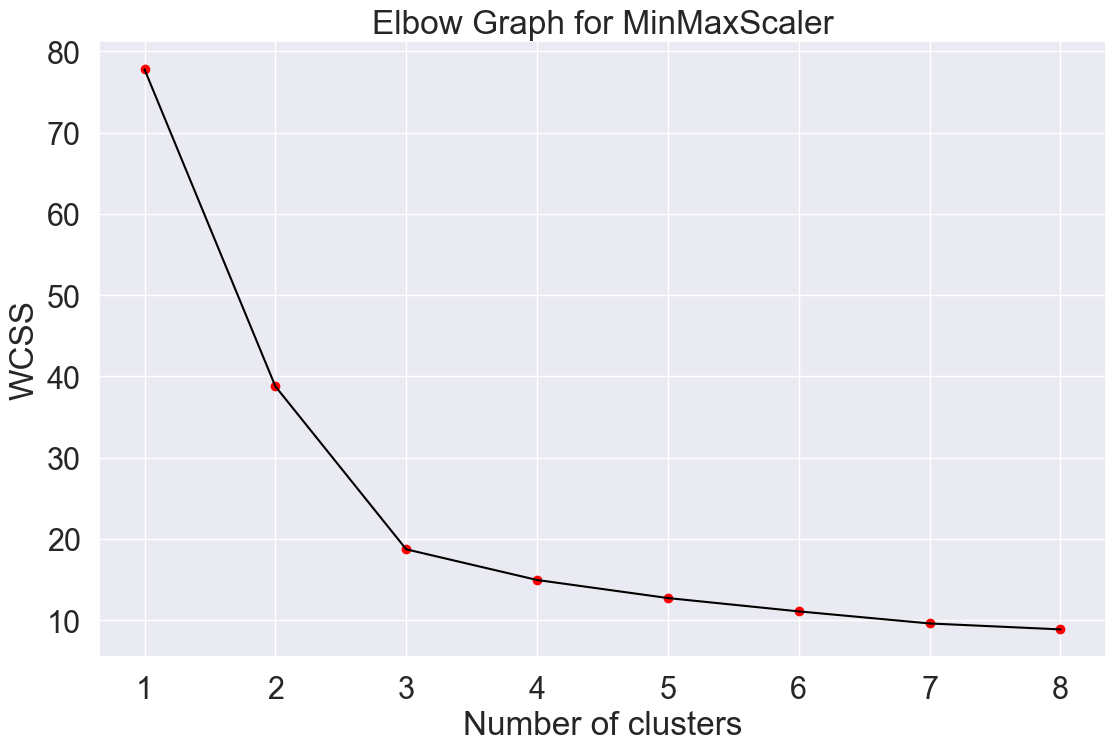

In [57]:
wcss=[]
for i in range (1,9):
    kmeans=KMeans(n_clusters=i,random_state=2)
    kmeans.fit(pca_minmax_df)
    wcss.append(kmeans.inertia_)
    
# Plot K values range vs WCSS to get Elbow graph for choosing K (no. of clusters)
plt.plot(range(1,9),wcss,color = 'black')
plt.scatter(range(1,9),wcss,color='red')
plt.title('Elbow Graph for MinMaxScaler')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

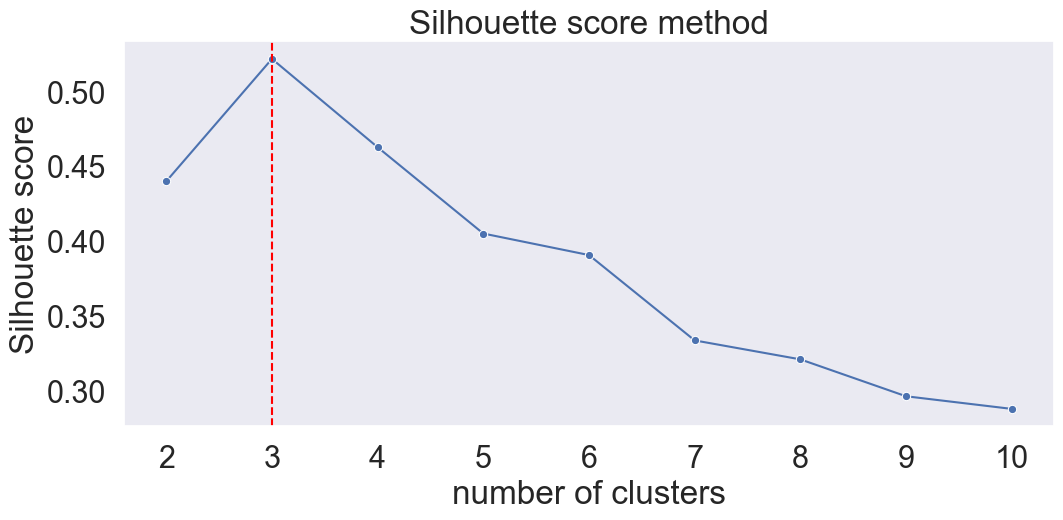

In [58]:
from sklearn.metrics import silhouette_score
n_clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
clusters_inertia = [] # inertia of clusters
s_scores = [] # silhouette scores

for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(pca_minmax_df)
    clusters_inertia.append(KM_est.inertia_)    # data for the elbow method
    silhouette_avg = silhouette_score(pca_minmax_df, KM_est.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=n_clusters, y=s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(3, ls="--", c="red")
plt.grid()
plt.show()

Elbow Plot for MinMaxScaler data


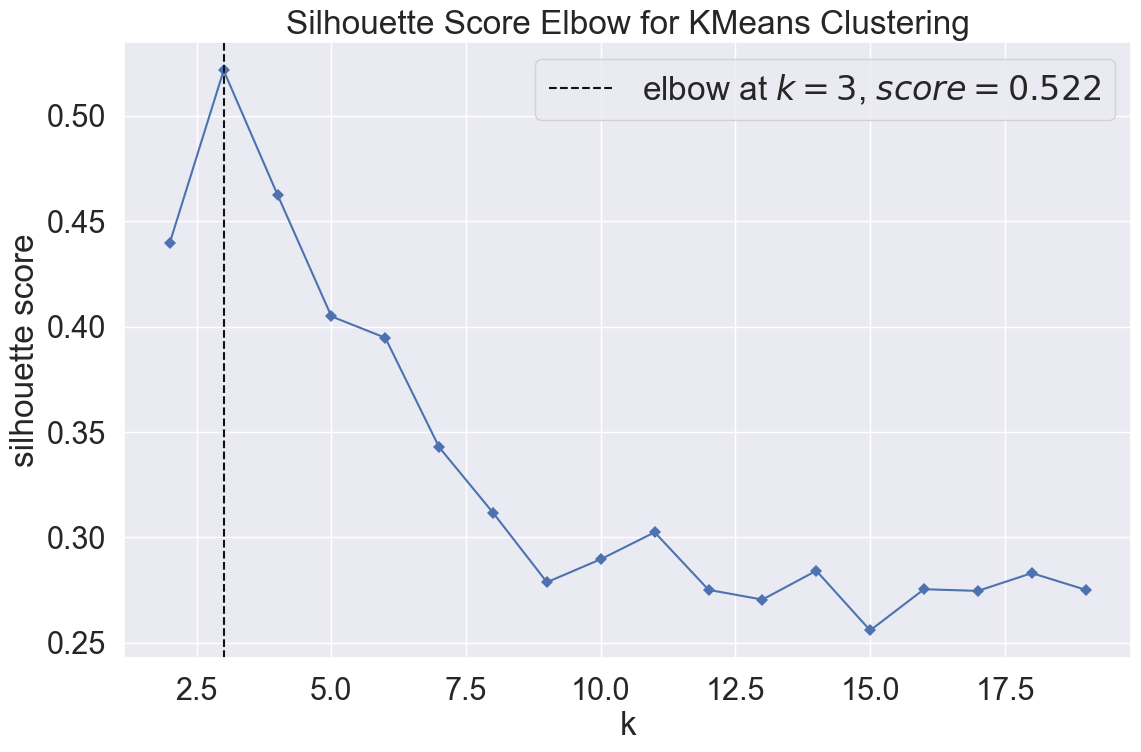

In [59]:
# Instantiate a scikit-learn K-Means model. we will check for two diff hyperparameters value effect.
model = KMeans(random_state=10, max_iter=500, init='k-means++')

# Instantiate the KElbowVisualizer with the number of clusters and the metric
visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette', timings=False)
# Fit the data and visualize
print('Elbow Plot for MinMaxScaler data')
visualizer.fit(pca_minmax_df)    
visualizer.show()
plt.show()

In [60]:
# With the elbow method, the ideal number of clusters to use was 6.
# We will also use the Silhouette score to determine an optimal number.

clust_list = [2,3,4,5,6,7,8,9]

#  Silhouette score for MinMaxScaler Applied on data .

for n_clusters in clust_list:
    clusterer1 = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels1 = clusterer1.fit_predict(pca_minmax_df)
    sil_score1= sil(pca_minmax_df, cluster_labels1)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", sil_score1)

For n_clusters = 2 The average silhouette_score is : 0.43975041589138875
For n_clusters = 3 The average silhouette_score is : 0.5215335527289146
For n_clusters = 4 The average silhouette_score is : 0.4625268425813934
For n_clusters = 5 The average silhouette_score is : 0.39825936654852967
For n_clusters = 6 The average silhouette_score is : 0.3947108989572141
For n_clusters = 7 The average silhouette_score is : 0.3289857388561521
For n_clusters = 8 The average silhouette_score is : 0.31172322269137365
For n_clusters = 9 The average silhouette_score is : 0.2997463078410952


For n_clusters = 2 The average silhouette_score is : 0.43975041589138875
For n_clusters = 3 The average silhouette_score is : 0.5215335527289146
For n_clusters = 4 The average silhouette_score is : 0.4625268425813934
For n_clusters = 5 The average silhouette_score is : 0.4048633645906421
For n_clusters = 6 The average silhouette_score is : 0.3947108989572141
For n_clusters = 7 The average silhouette_score is : 0.34279238396007666
For n_clusters = 8 The average silhouette_score is : 0.31172322269137365
For n_clusters = 9 The average silhouette_score is : 0.2787828910972606


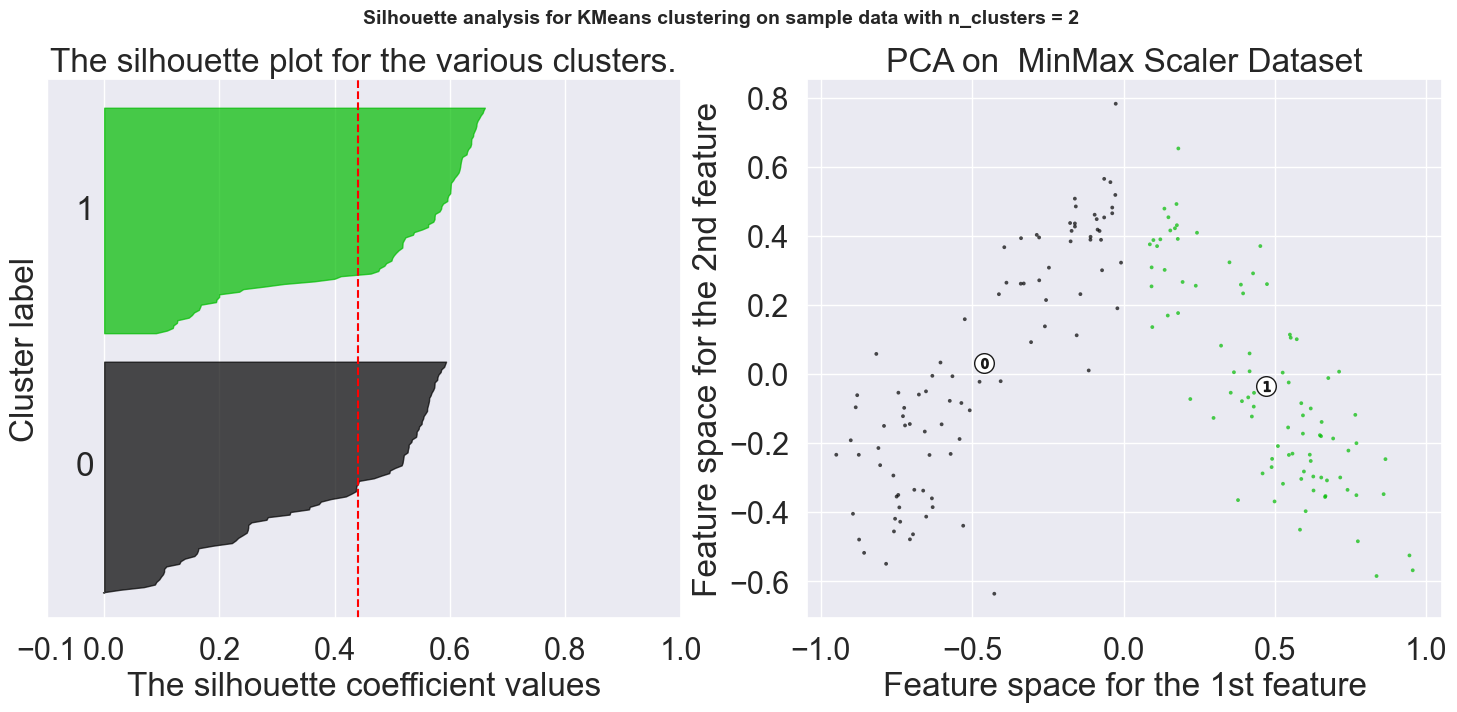

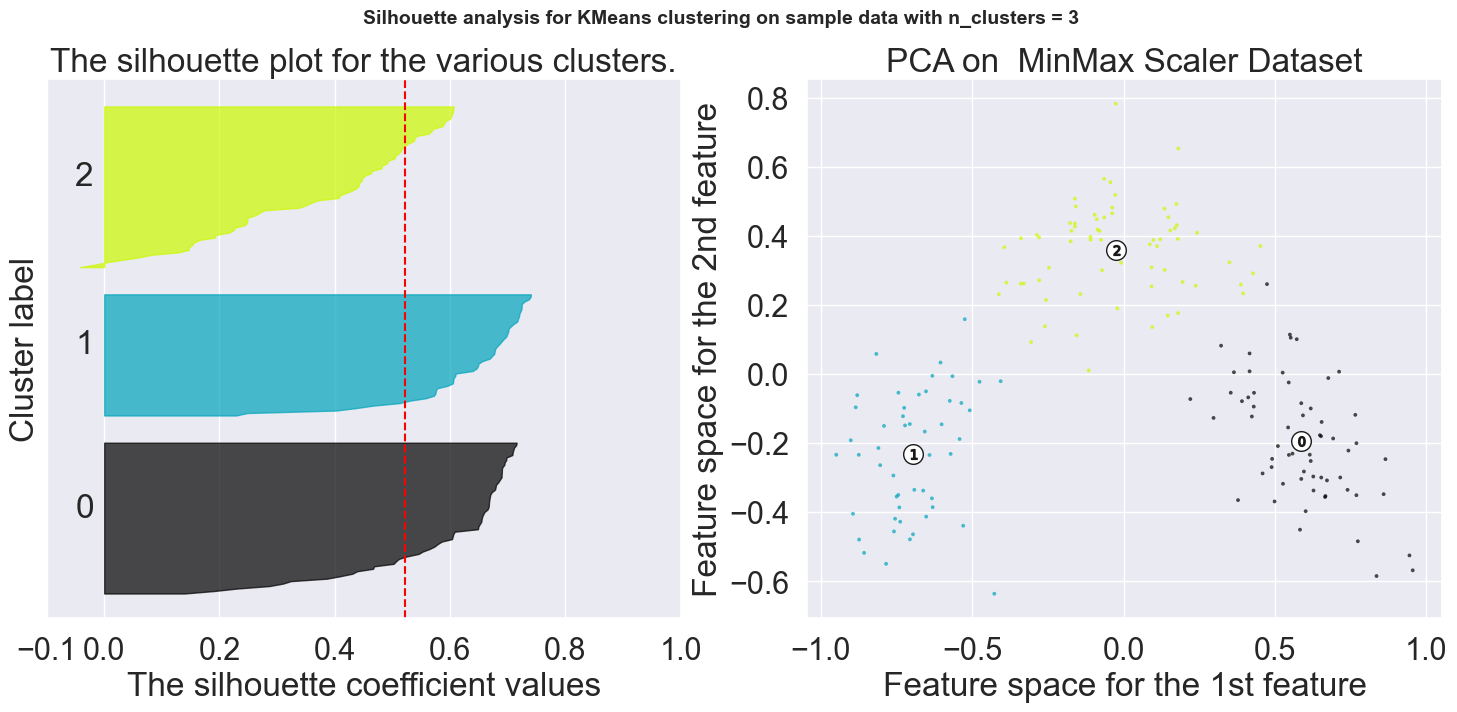

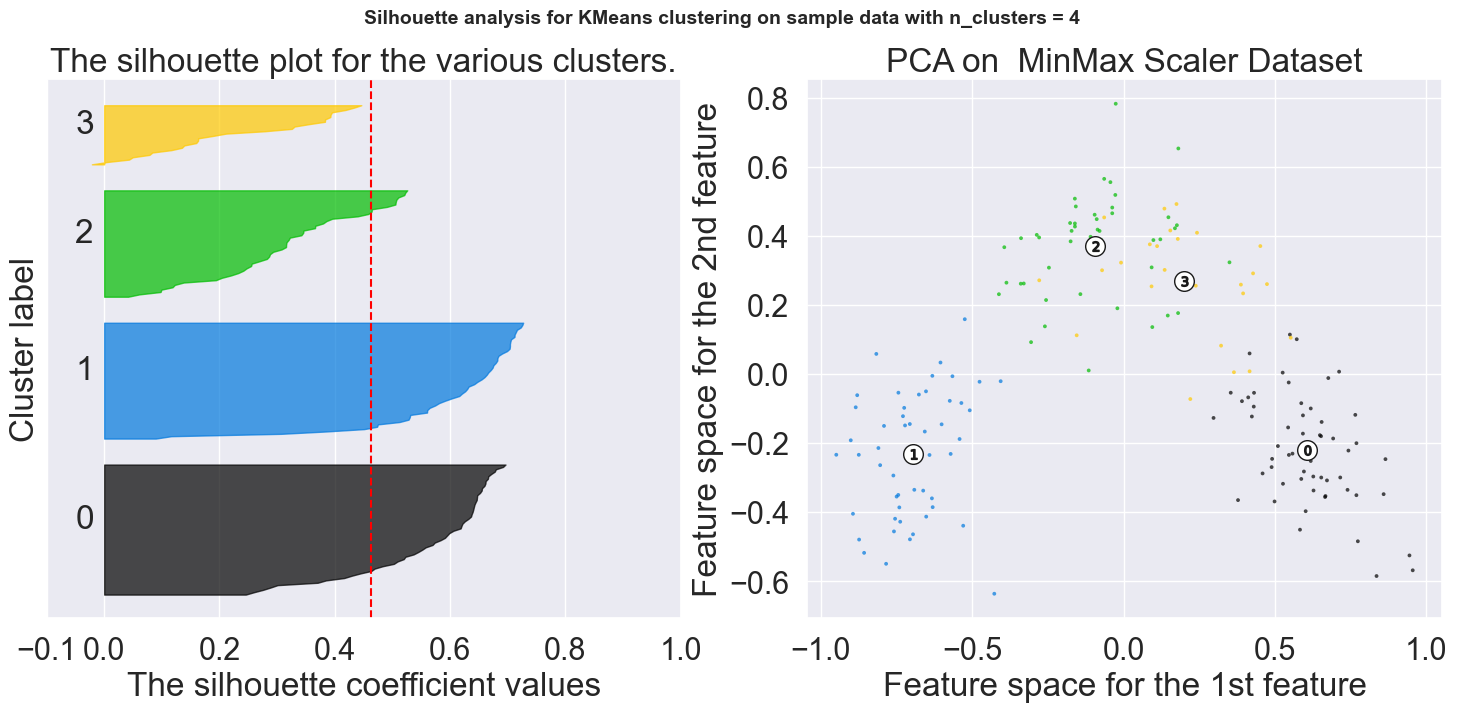

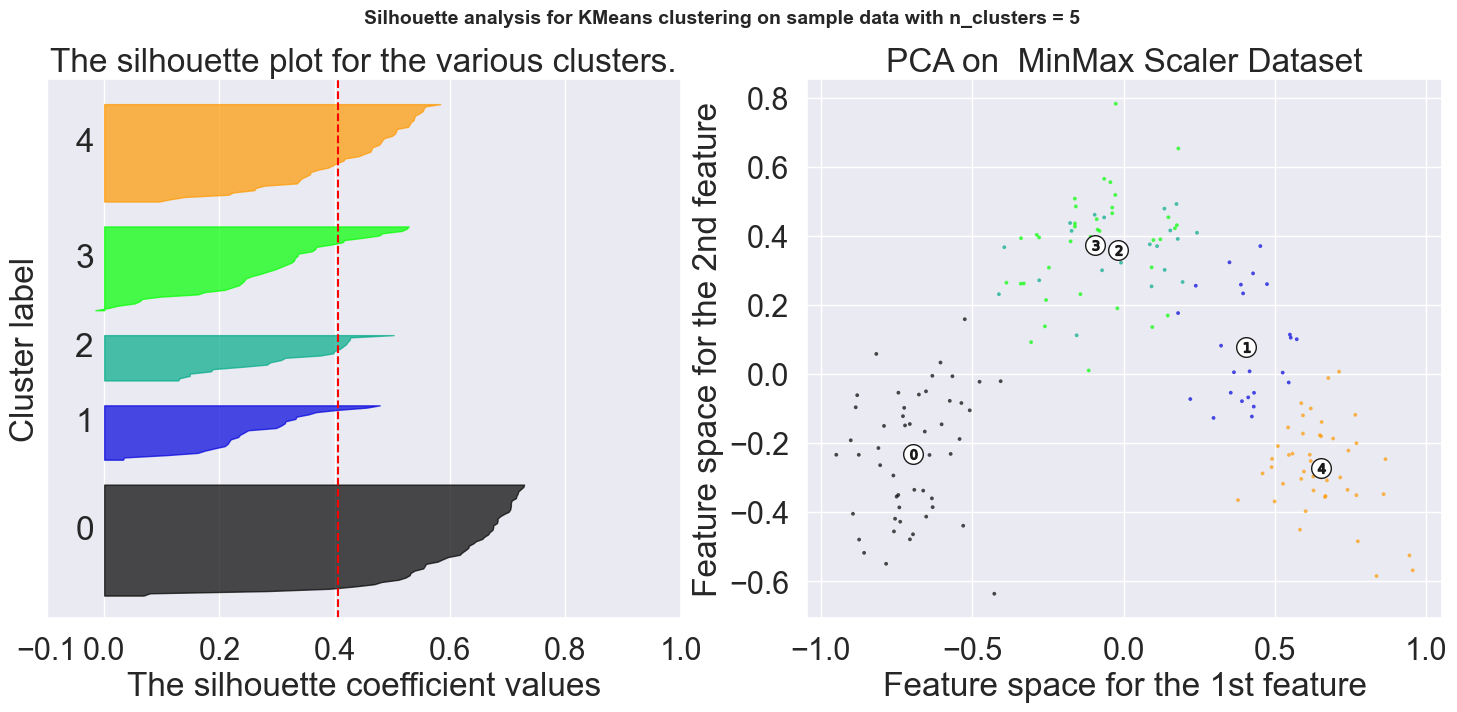

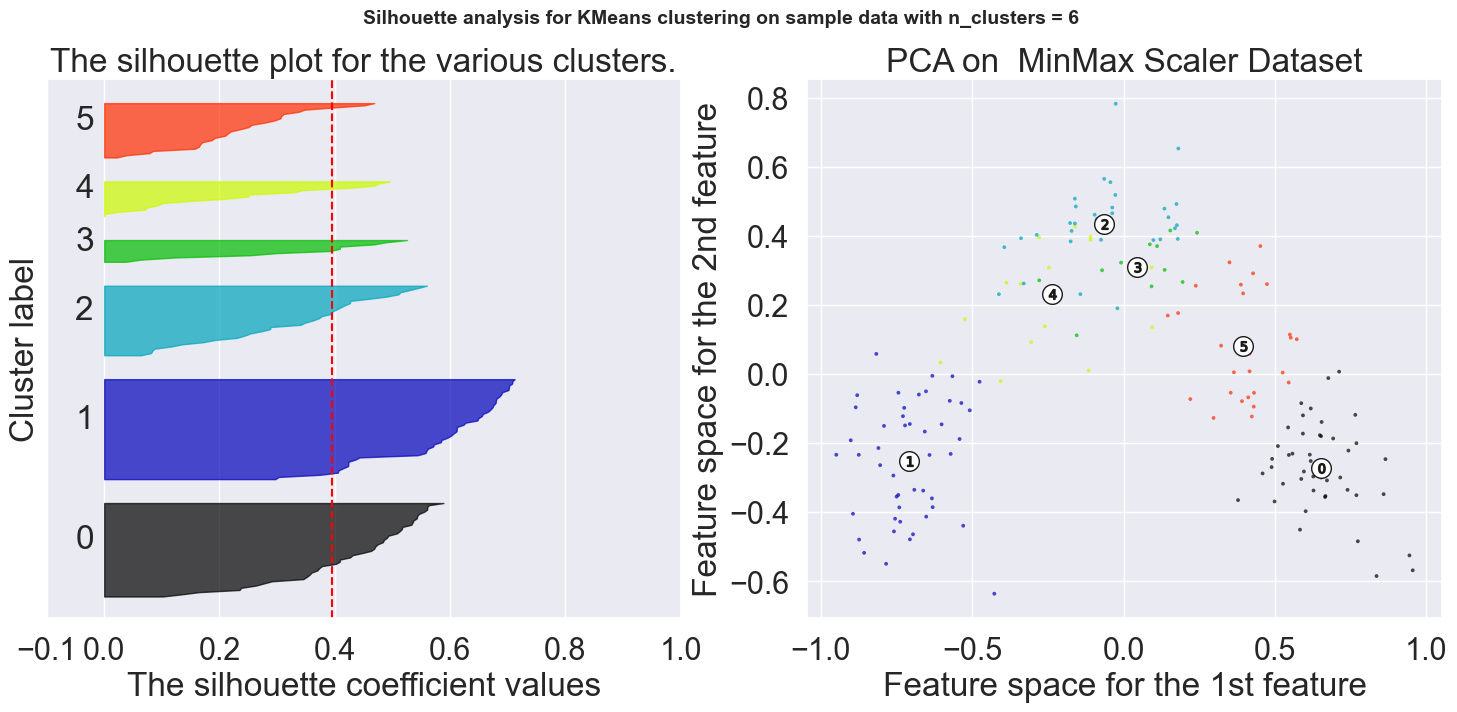

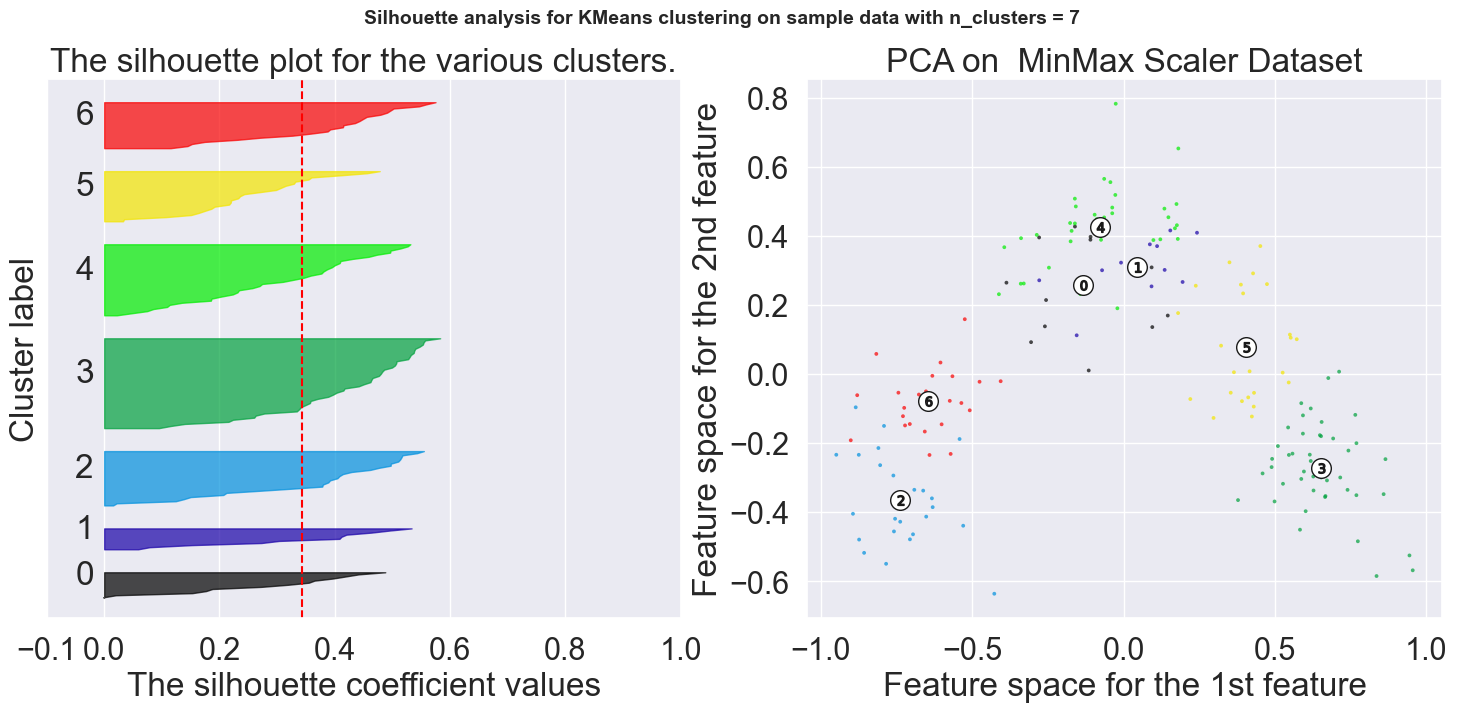

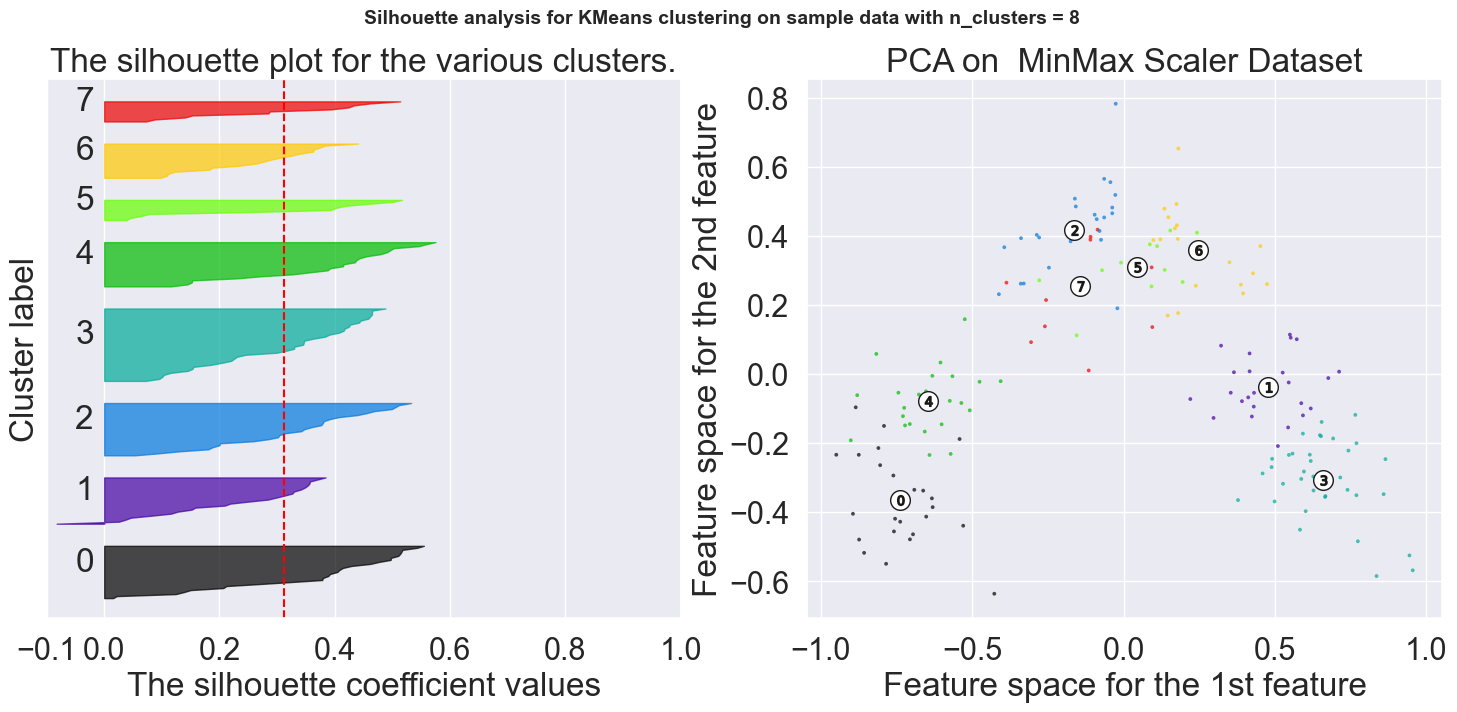

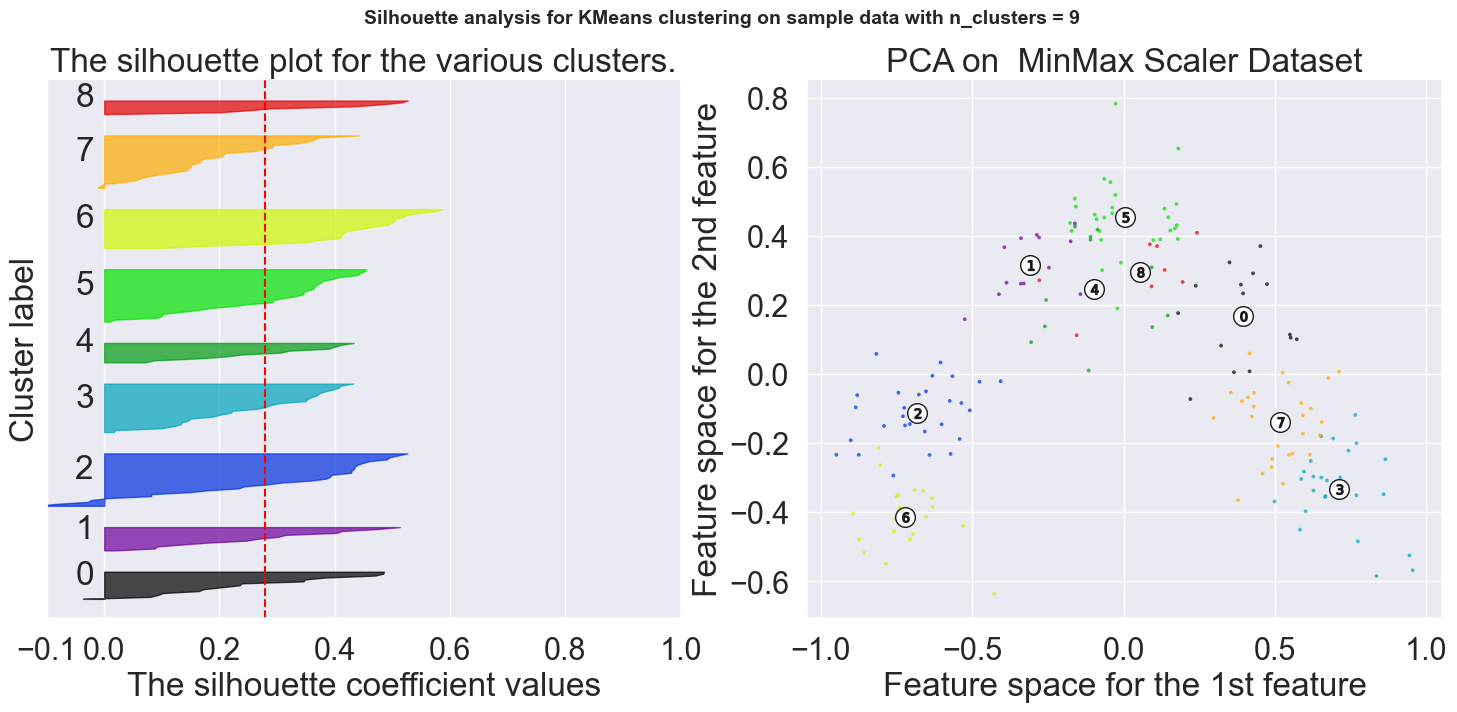

In [61]:
range_n_clusters = [2,3,4,5,6,7,8,9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pca_minmax_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(pca_minmax_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sil(pca_minmax_df, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pca_minmax_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(pca_minmax_df.iloc[:,0], pca_minmax_df.iloc[:,1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:,0], centers[:,1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("PCA on  MinMax Scaler Dataset")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

####  Conclusion:
According the the silhouette score of:

+ The PCA on MinMax Scaler Applied data, the ideal <b>number of clusters</b> is <b>3</b>, with a score higher than other options, of <b>0.52</b>, but if you notice the number of cluster 4 has also the best variation within cluster and between cluster with zero to no values going towards -1 and no overlapping in cluster segregation than the consecutive rest

+ If we check <b>silhouette score</b> with <b>PCA on Normalize data kmeans model 0.52>0.48</b> than of PCA on Standard Scaler Dataset. 

+ <b>Best score always close to +1.

## 7.5 Build KMeans Cluster algorithm using K=3 and PCA on MinMaxScaler Applied Dataset<a class="anchor" id="7.5"></a>

[Table of Contents](#0.1)

In [62]:
# we have found good number of cluster = 3
# model building using cluster numbers = 3

model_kmeans = KMeans(n_clusters=3, random_state=0, init='k-means++')
y_predict_kmeans = model_kmeans.fit_predict(pca_minmax_df)
y_predict_kmeans.shape

(178,)

In [63]:
# these are nothing but cluster labels...

y_predict_kmeans

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [64]:
model_kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [65]:
# cluster centres associated with each lables

model_kmeans.cluster_centers_

array([[-0.69579292, -0.23298991,  0.00190367],
       [-0.02383121,  0.35770859,  0.01239953],
       [ 0.58649203, -0.19289148, -0.01473472]])

In [66]:
# within-cluster sum of squared

# The lower values of inertia are better and zero is optimal.
# Inertia is the sum of squared error for each cluster. 
# Therefore the smaller the inertia the denser the cluster(closer together all the points are)

model_kmeans.inertia_

18.71706192569448

In [67]:
#Assign clusters to the data set

df['Kmeans_label'] = model_kmeans.labels_

In [68]:
# Group data by Clusters (K=3)
df.groupby('Kmeans_label').agg(['mean'])

Alcohol     Malic       Ash Alcalinity   Magnesium   Phenols  \
                   mean      mean      mean       mean        mean      mean   
Kmeans_label                                                                   
0             13.144000  3.346200  2.425600  21.330000  98.640000   1.677200   
1             12.233333  1.905000  2.251212  20.218182  93.469697   2.247273   
2             13.701774  1.981129  2.441613  17.245161  107.306452  2.844355   

             Flavanoids Nonflavanoids Proanthocyanins     Color       Hue  \
                   mean          mean            mean      mean      mean   
Kmeans_label                                                                
0             0.807000   0.450400      1.156400        7.264400  0.686200   
1             2.069091   0.363485      1.602727        3.025758  1.058576   
2             2.972581   0.288710      1.928710        5.442258  1.068548   

              Dilution      Proline          ID  
                  mean         mean        mean  
Kmeans_label                                     
0             1.698800  622.440000   152.380000  
1             2.792727  508.696970   95.530303   
2             3.155161  1100.822581  32.370968

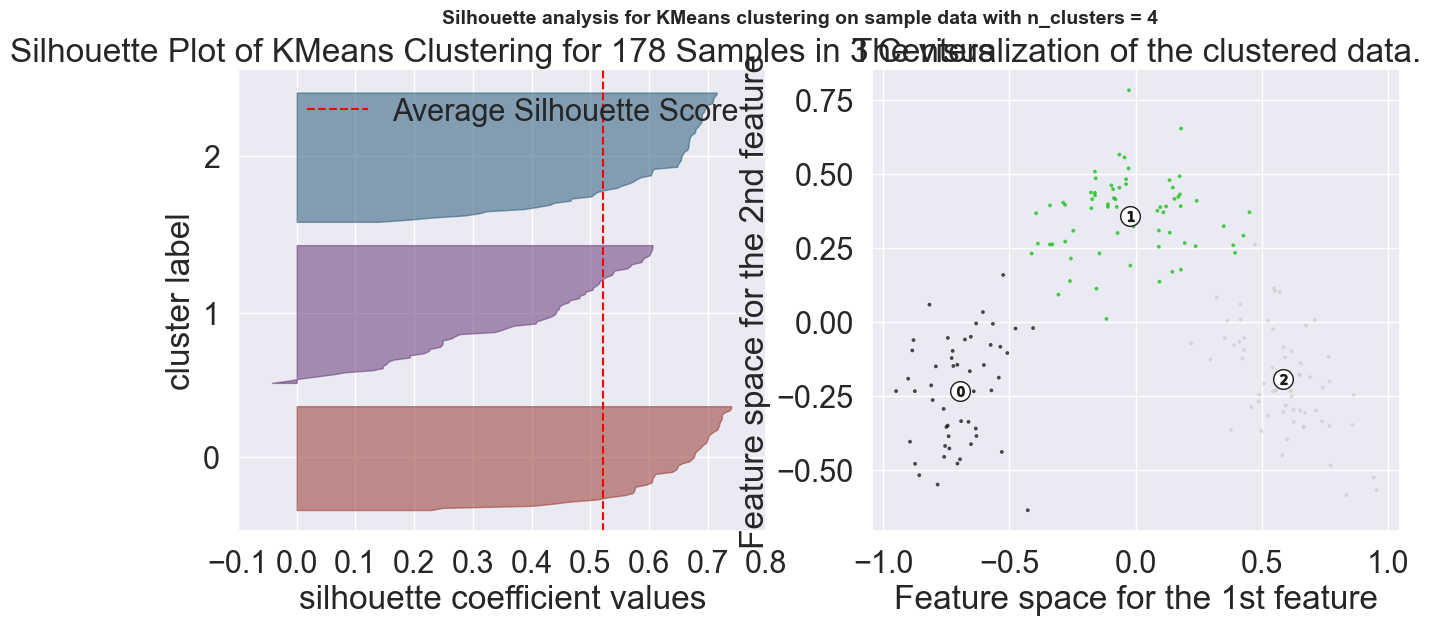

In [69]:
from yellowbrick.cluster import SilhouetteVisualizer

fig,(ax1,ax2) = plt.subplots(1,2,sharey=False)
fig.set_size_inches(15,6)



sil_visualizer1 = SilhouetteVisualizer(model_kmeans,ax= ax1, colors=['#922B21','#5B2C6F','#1B4F72'])
sil_visualizer1.fit(pca_minmax_df)


# 2nd Plot showing the actual clusters formed

import matplotlib.cm as cm
colors1 = cm.nipy_spectral(model_kmeans.labels_.astype(float) / 2) # 3 is number of clusters
ax2.scatter(pca_minmax_df.iloc[:, 0], pca_minmax_df.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors1, edgecolor='k')

# Labeling the clusters
centers1 = model_kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers1[:, 0], centers1[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers1):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')


ax2.set_title(label ="The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % 4),fontsize=14, fontweight='bold')

sil_visualizer1.show()
plt.show()

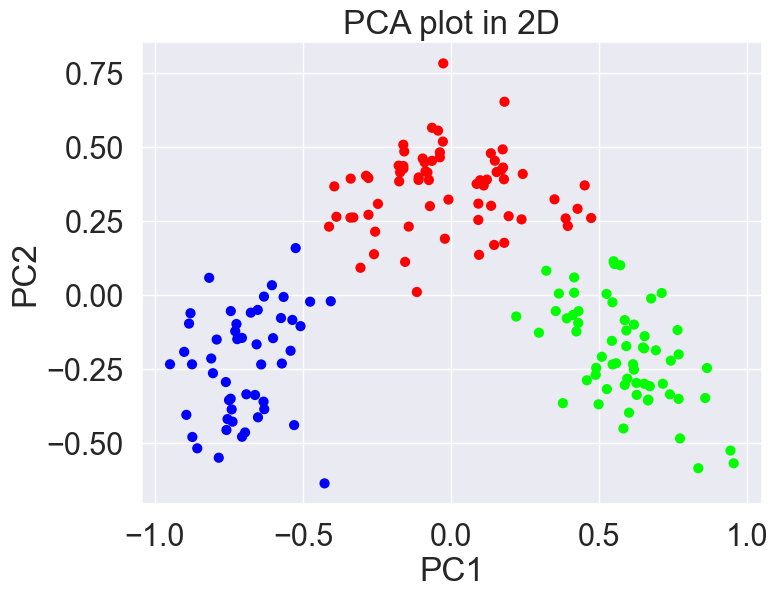

In [70]:
# Figure size
plt.figure(figsize=(8,6))

# Scatterplot
plt.scatter(pca_minmax_df.iloc[:,0], pca_minmax_df.iloc[:,1], c=data['Kmeans_label'], cmap="brg", s=40)

# Aesthetics
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### We can now clearly see the 3 number of clusters formed

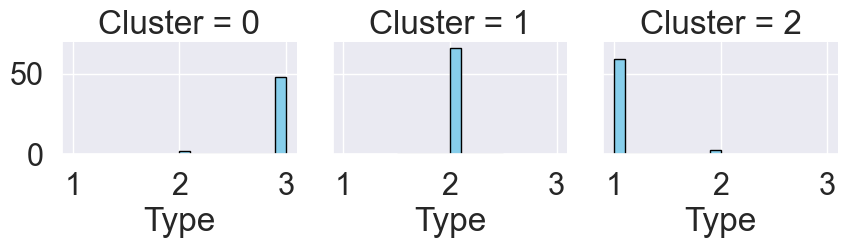

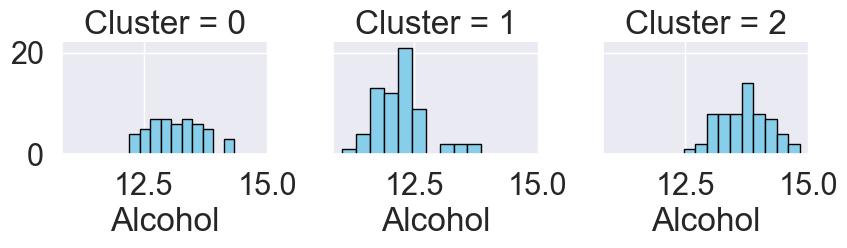

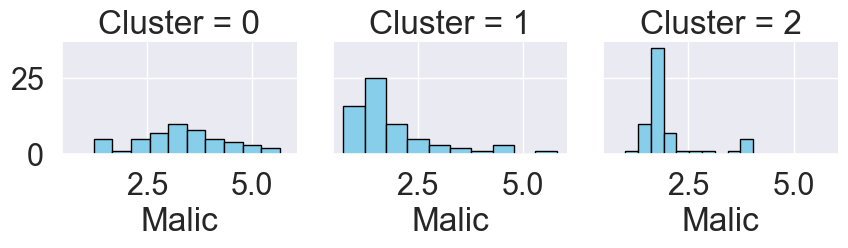

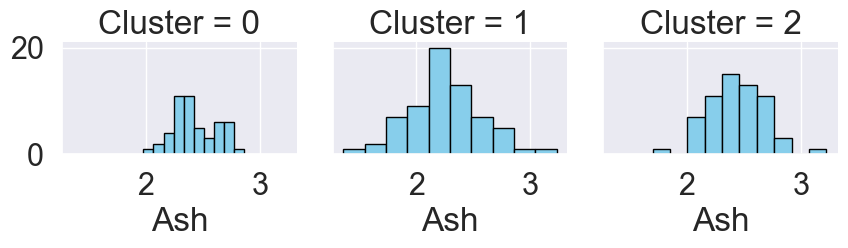

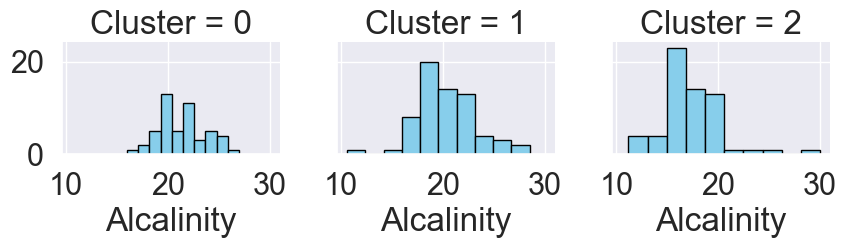

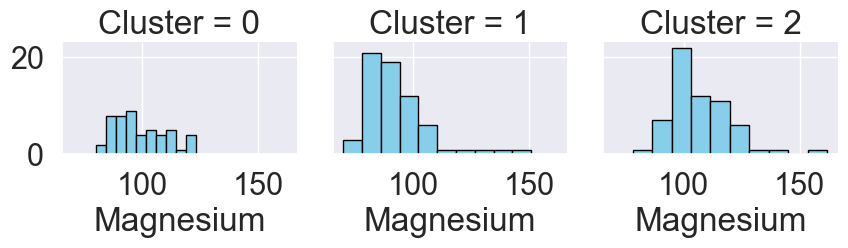

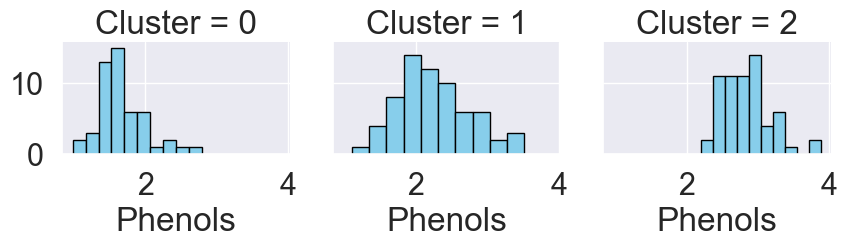

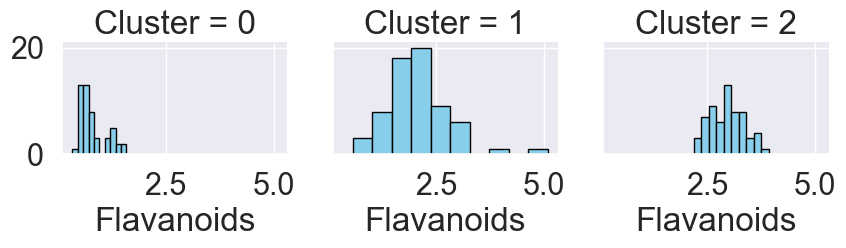

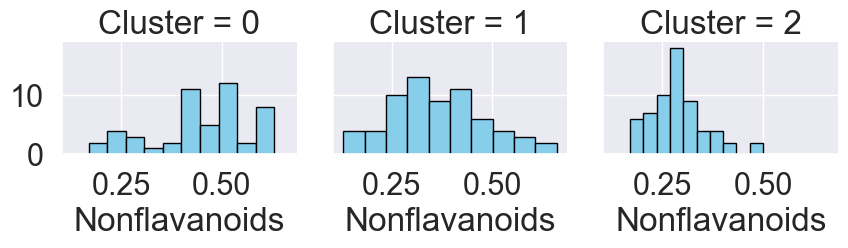

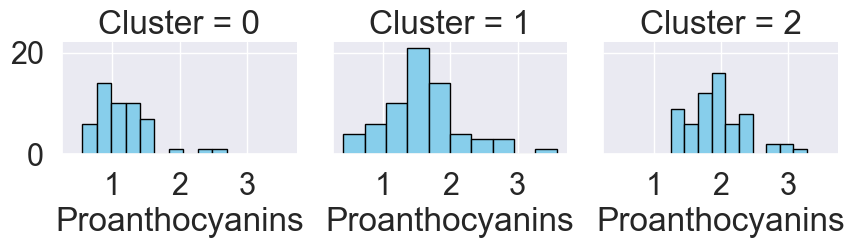

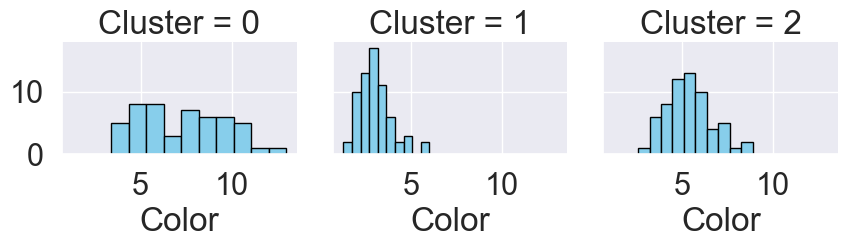

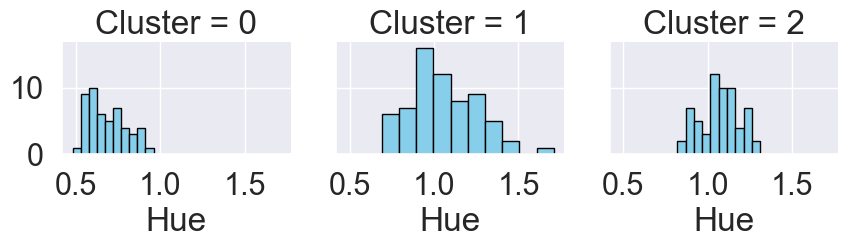

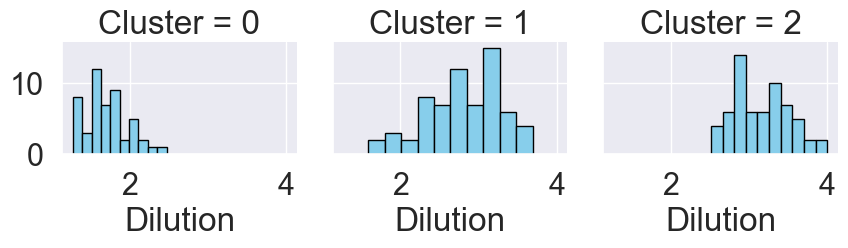

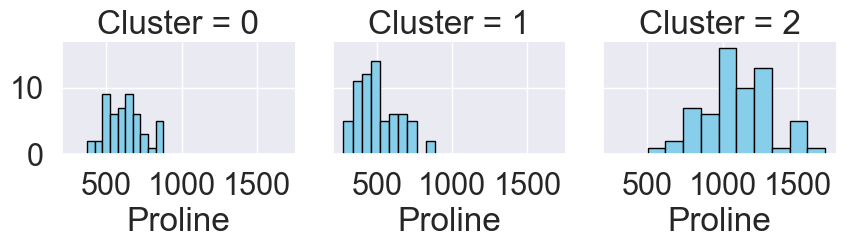

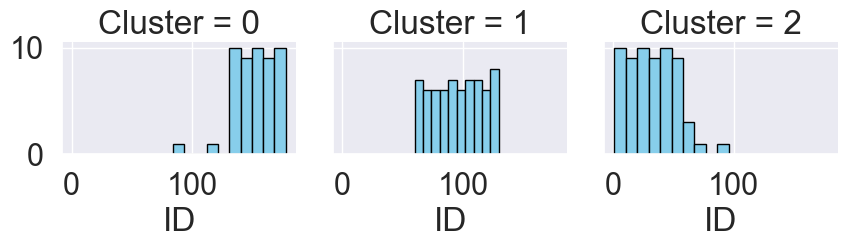

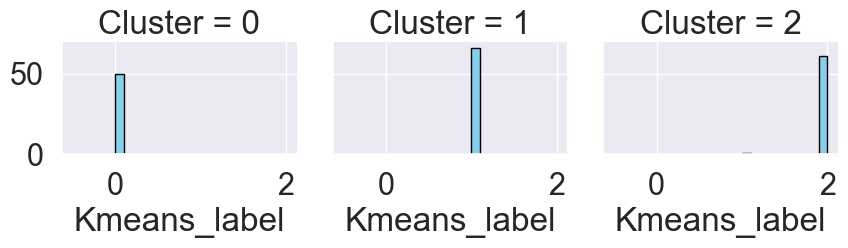

In [71]:
df1 = data.copy()
df1['Cluster'] = model_kmeans.labels_

aux=df1.columns.tolist()
aux[0:len(aux)-1]

sns.set(style="darkgrid", rc={'figure.figsize':(13,8)}, font_scale=2)

for cluster in aux[0:len(aux)-1]:
    grid = sns.FacetGrid(df1, col="Cluster")
    grid.map(plt.hist, cluster, color="skyblue", lw=1, edgecolor="black")

In [72]:
# Sorting elements based on cluster label assigned and taking average for insights.

cluster1 = pd.DataFrame(df1.loc[df1.Cluster==0].mean(),columns= ['Cluster1_avg'])
cluster2 = pd.DataFrame(df1.loc[df1.Cluster==1].mean(),columns= ['Cluster2_avg'])
cluster3 = pd.DataFrame(df1.loc[df1.Cluster==2].mean(),columns= ['Cluster2_avg'])

In [73]:
avg_df = pd.concat([cluster1,cluster2,cluster3],axis=1)
avg_df

Cluster1_avg  Cluster2_avg  Cluster2_avg
Type             2.9600        2.000000      1.048387    
Alcohol          13.1440       12.233333     13.701774   
Malic            3.3462        1.905000      1.981129    
Ash              2.4256        2.251212      2.441613    
Alcalinity       21.3300       20.218182     17.245161   
Magnesium        98.6400       93.469697     107.306452  
Phenols          1.6772        2.247273      2.844355    
Flavanoids       0.8070        2.069091      2.972581    
Nonflavanoids    0.4504        0.363485      0.288710    
Proanthocyanins  1.1564        1.602727      1.928710    
Color            7.2644        3.025758      5.442258    
Hue              0.6862        1.058576      1.068548    
Dilution         1.6988        2.792727      3.155161    
Proline          622.4400      508.696970    1100.822581 
ID               152.3800      95.530303     32.370968   
Kmeans_label     0.0000        1.000000      1.983871    
Cluster          0.0000        1.000000      2.000000

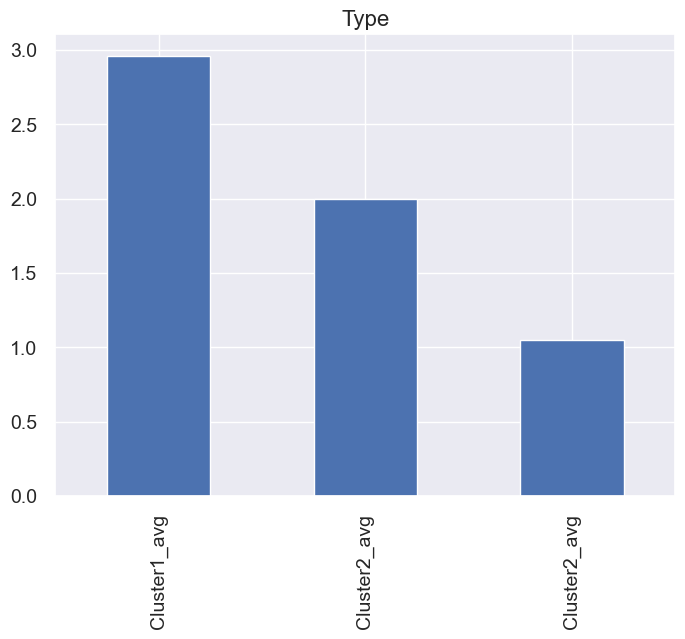

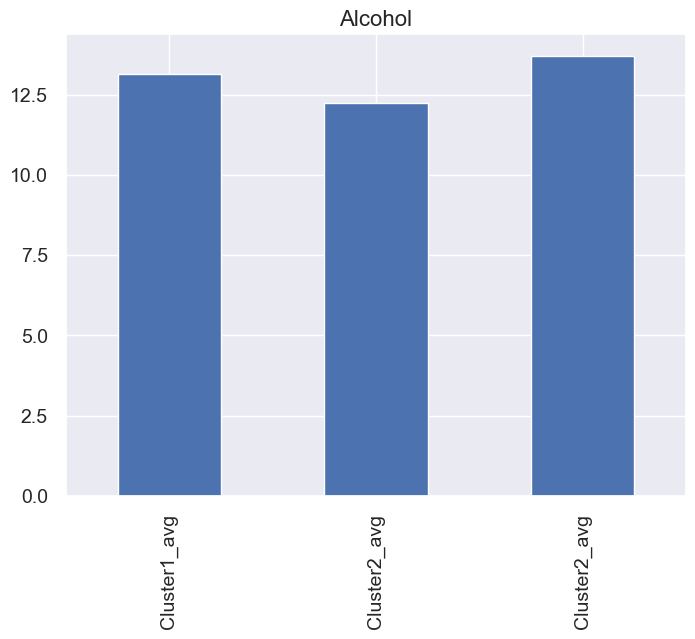

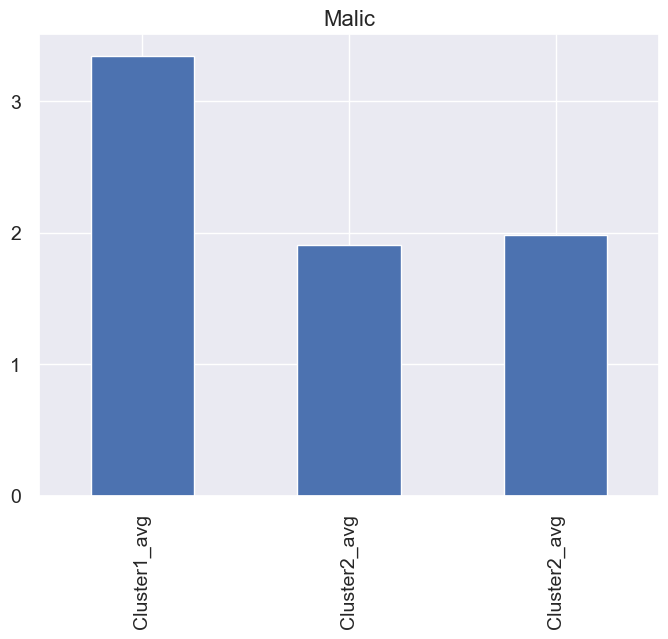

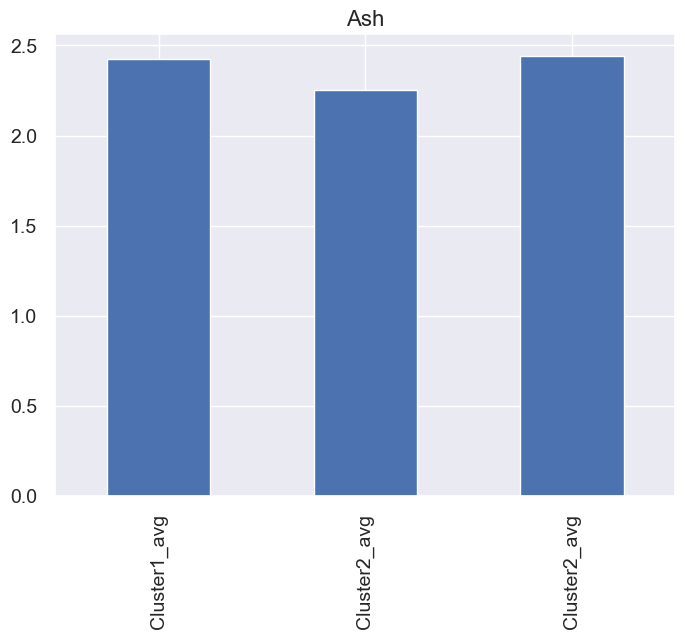

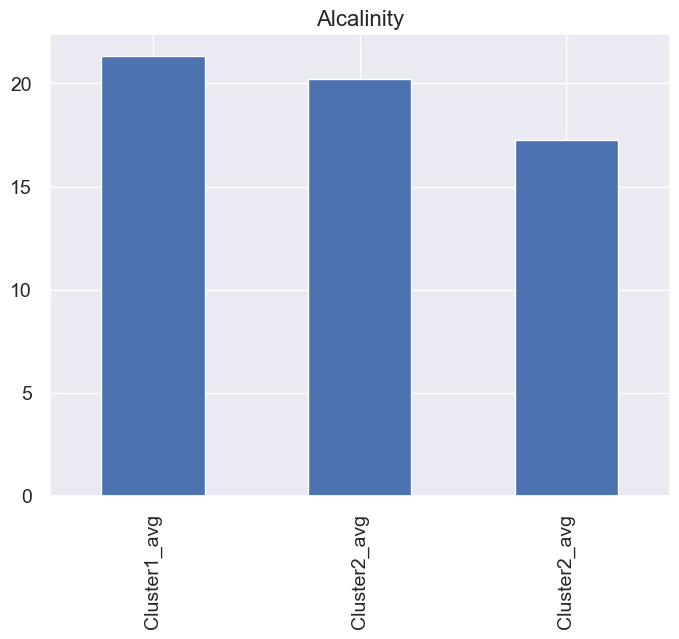

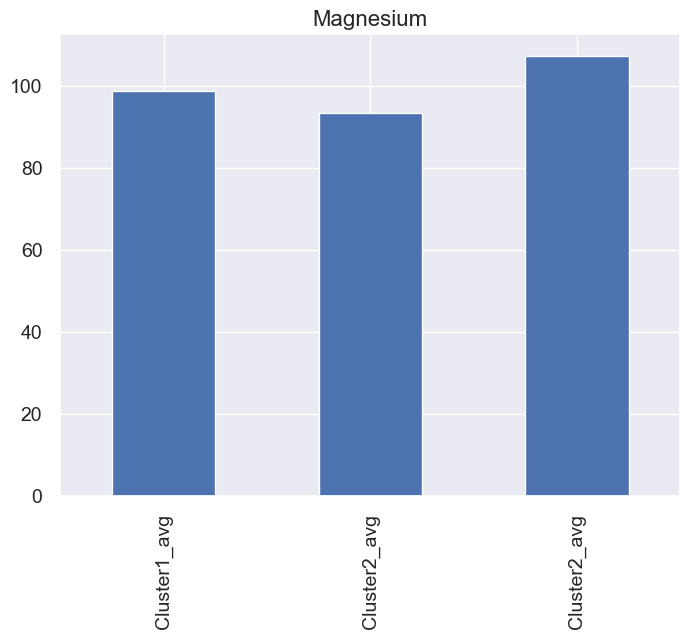

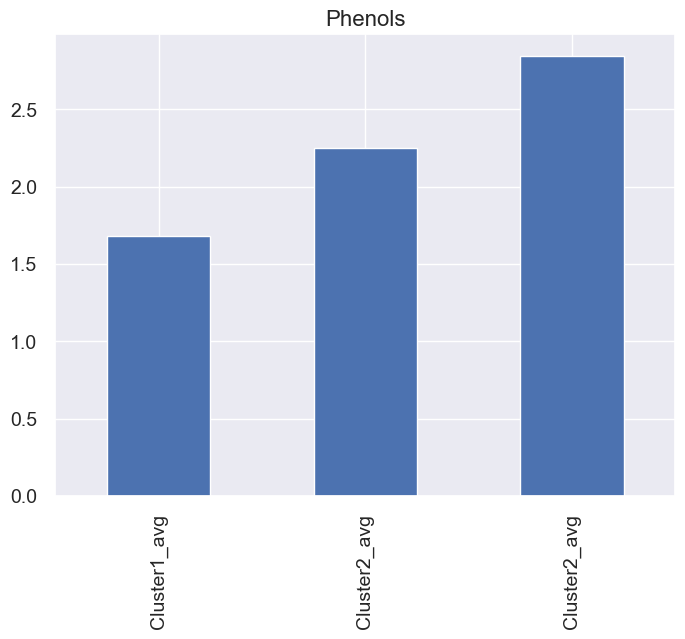

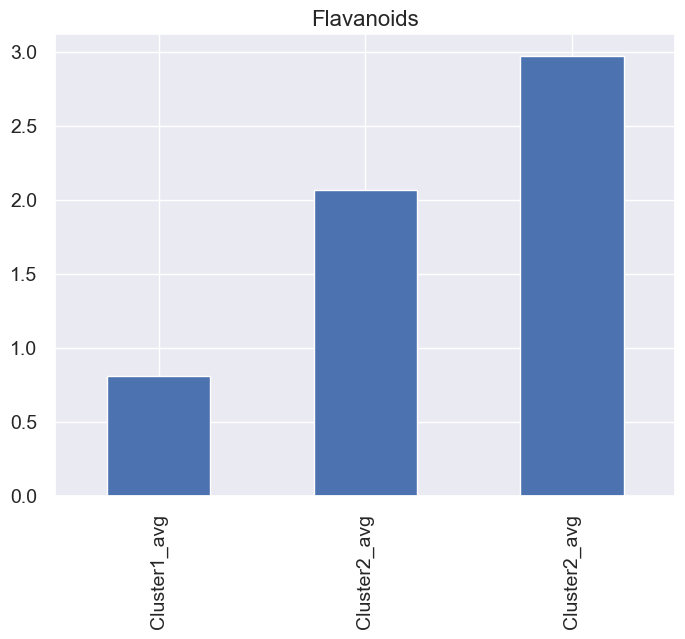

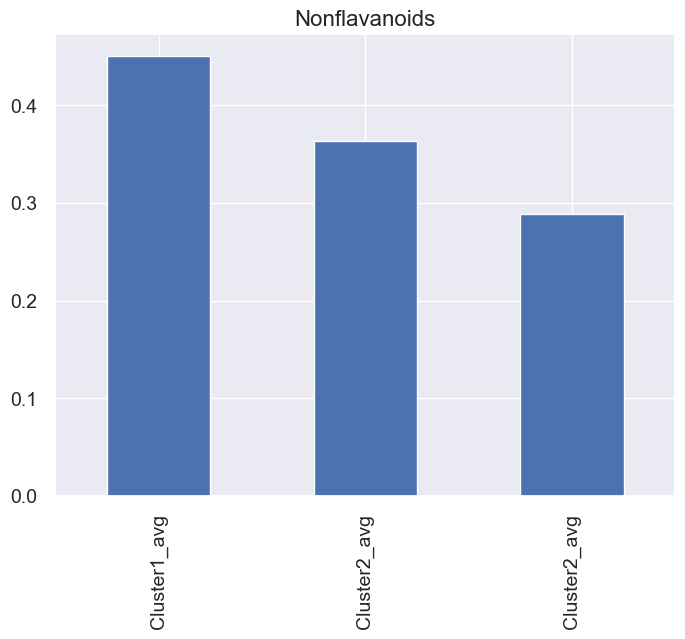

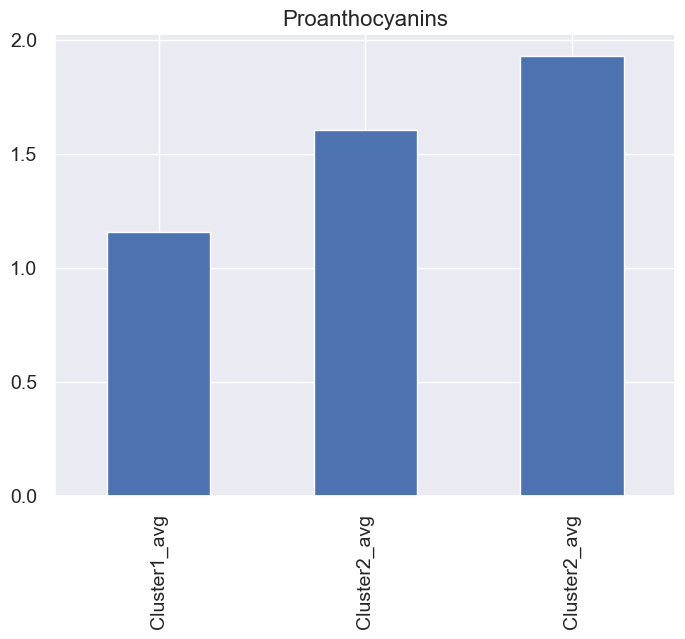

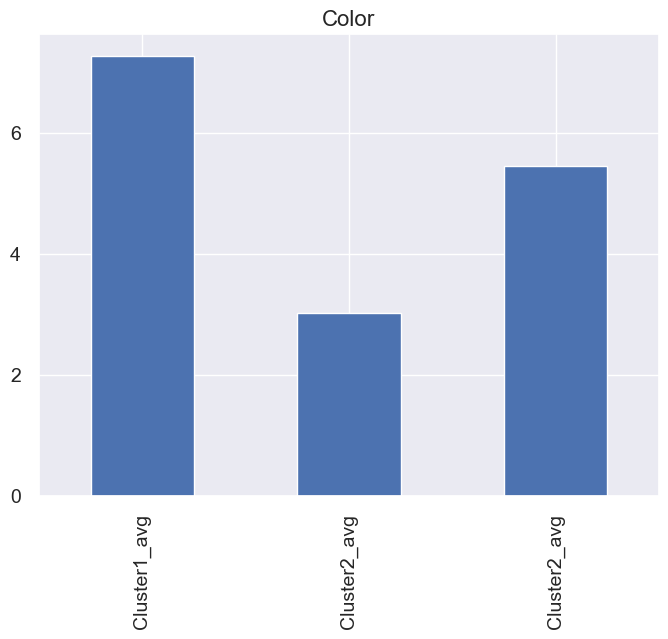

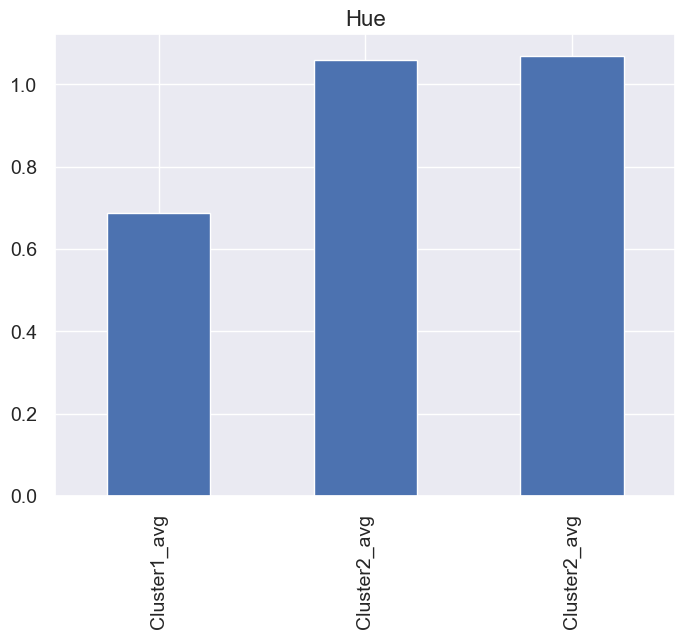

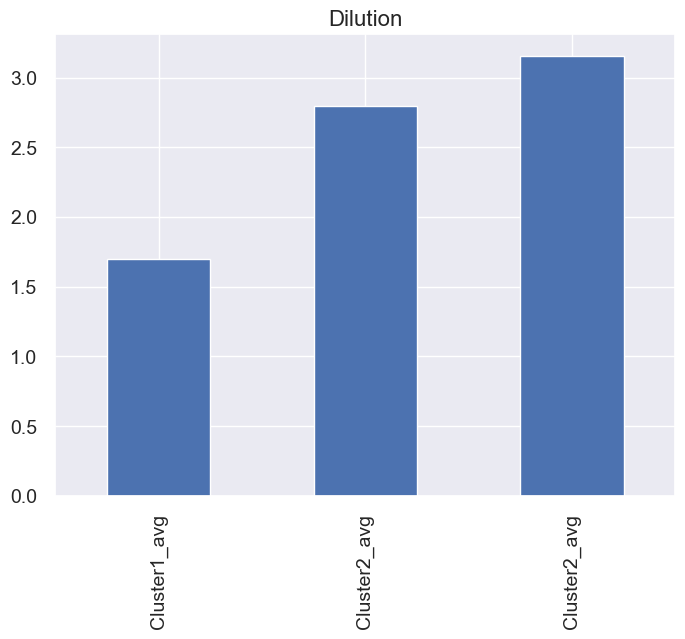

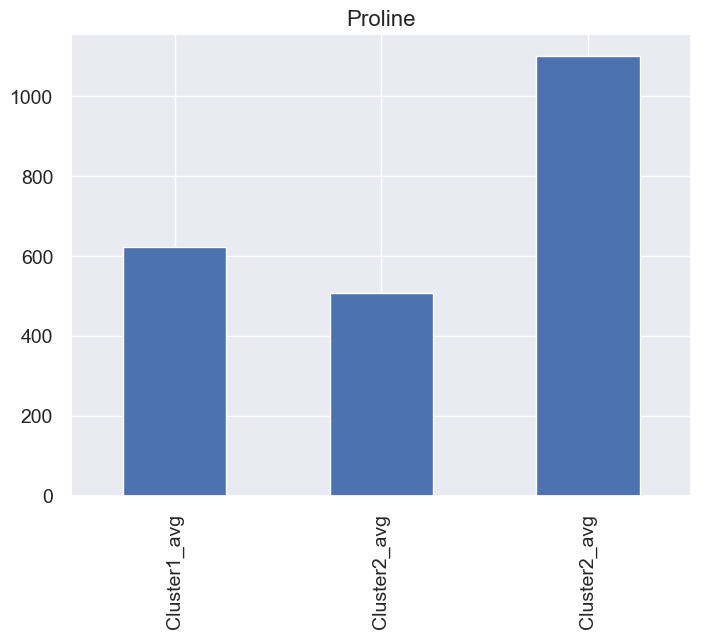

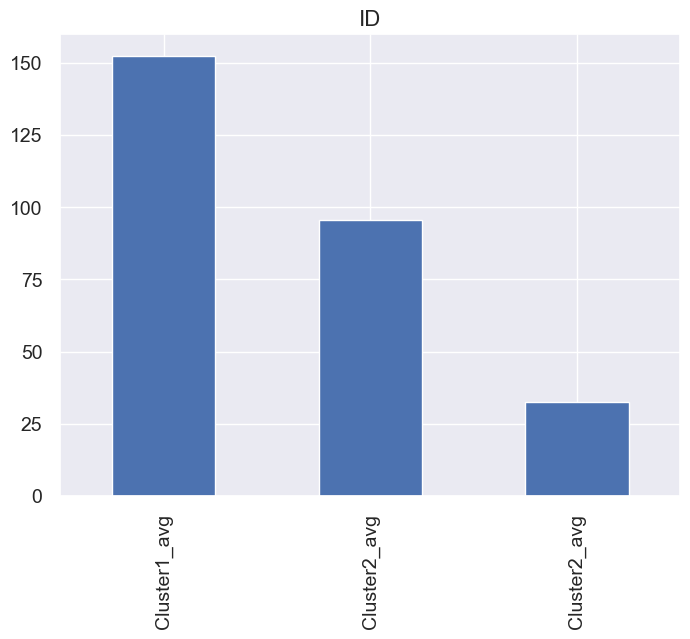

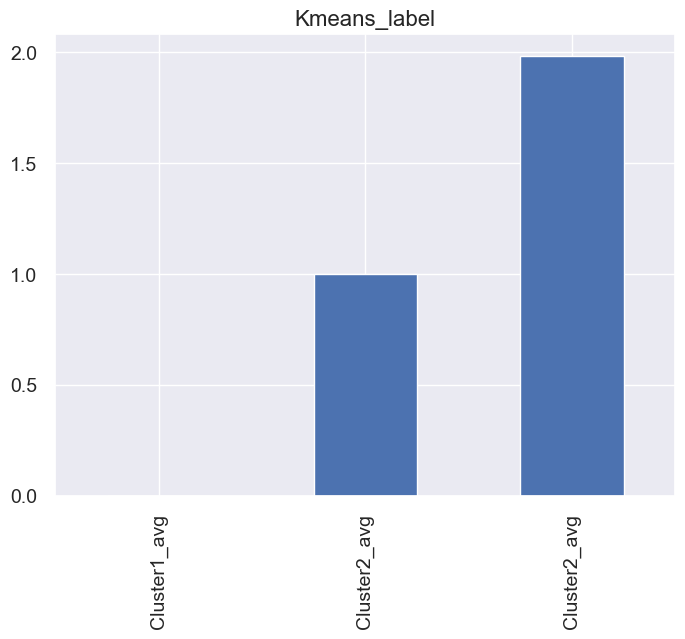

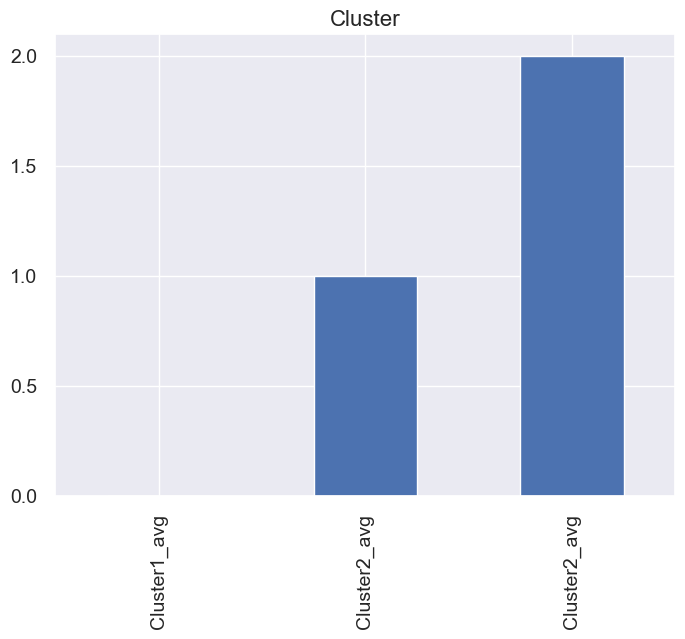

In [74]:
# Extract and plot one Column data .xs method
for i , row in avg_df.iterrows():
    fig = plt.subplots(figsize=(8,6))
    j = avg_df.xs(i ,axis = 0)
    plt.title(i, fontsize=16, fontweight=20)
    j.plot(kind='bar',fontsize=14)
    plt.show()
    print()

### 7.6 Comparing Kmeans Clusters with the Original Classified Dataset using "Type" Feature<a class="anchor" id="7.6"></a>

[Table of Contents](#0.1)

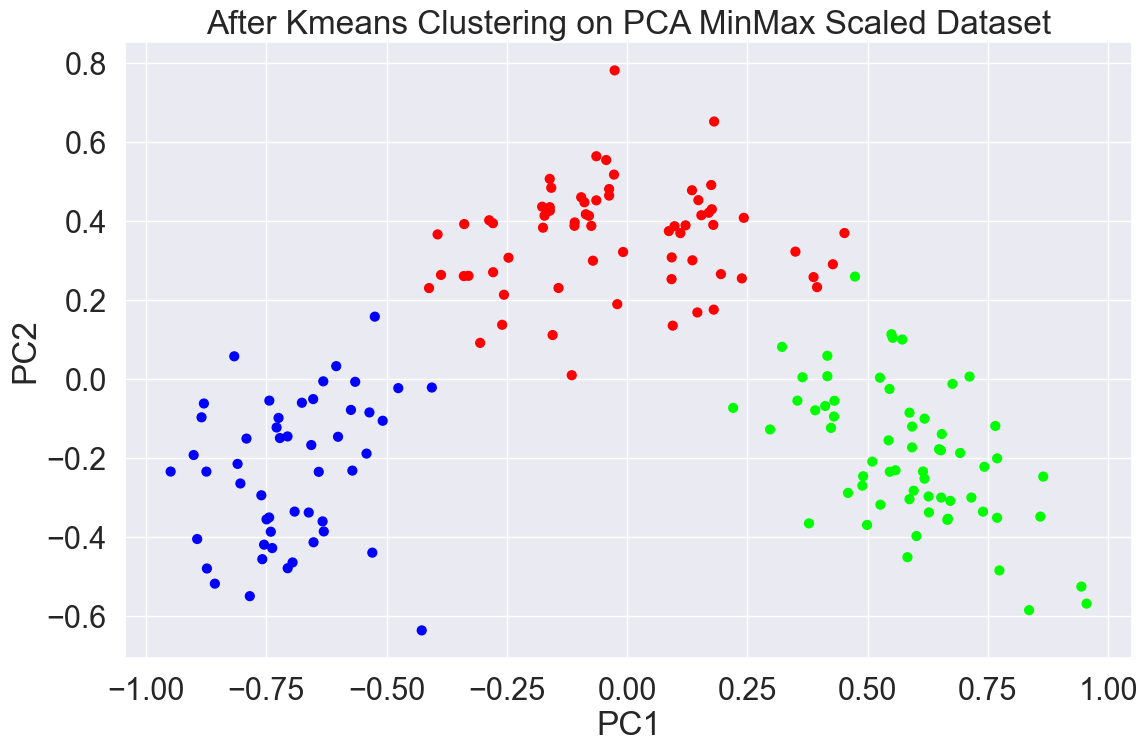

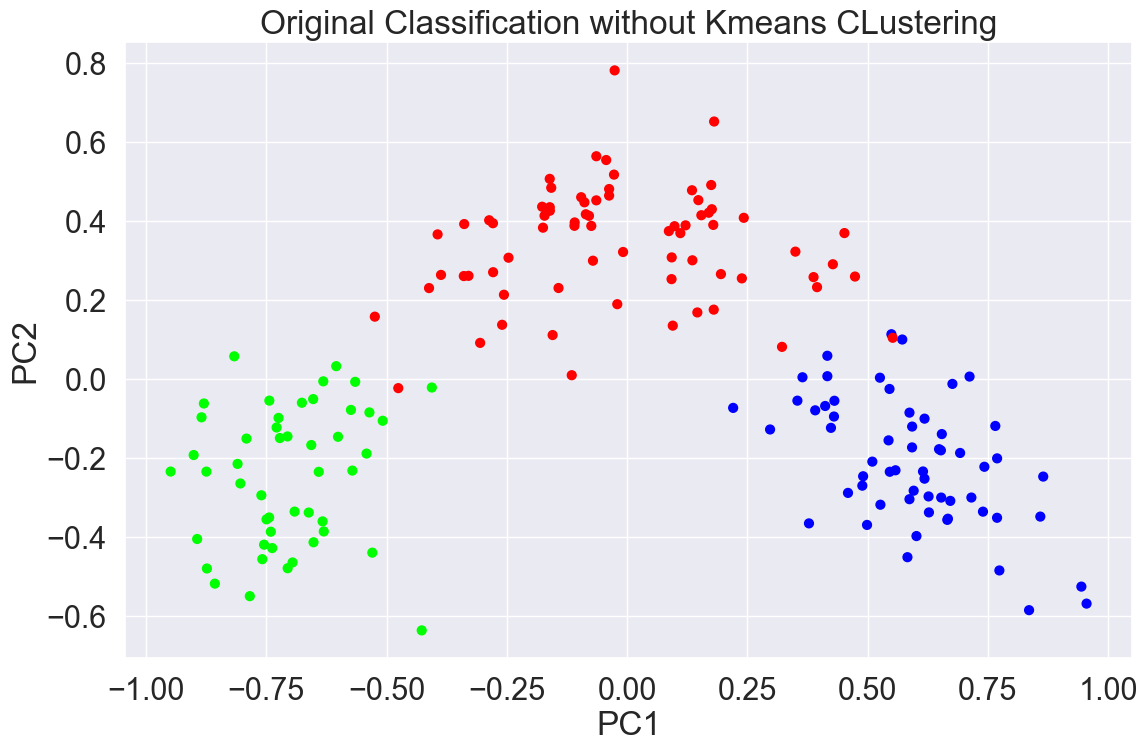

In [75]:
# Scatterplot
plt.scatter(pca_minmax_df.iloc[:,0], pca_minmax_df.iloc[:,1], c=df['Kmeans_label'], cmap="brg", s=40)

# Aesthetics
plt.title('After Kmeans Clustering on PCA MinMax Scaled Dataset')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Scatterplot
plt.scatter(pca_minmax_df.iloc[:,0], pca_minmax_df.iloc[:,1], c=data['Type'], cmap="brg", s=40)

# Aesthetics
plt.title('Original Classification without Kmeans CLustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [76]:
# Group data by Clusters (K=3)
display('After Applying PCA and Kmens CLustering on Dataset',df.groupby('Kmeans_label').agg(['mean']),'Original Classified Dataset',data.groupby('Type').agg(['mean']))

'After Applying PCA and Kmens CLustering on Dataset'

Alcohol     Malic       Ash Alcalinity   Magnesium   Phenols  \
                   mean      mean      mean       mean        mean      mean   
Kmeans_label                                                                   
0             13.144000  3.346200  2.425600  21.330000  98.640000   1.677200   
1             12.233333  1.905000  2.251212  20.218182  93.469697   2.247273   
2             13.701774  1.981129  2.441613  17.245161  107.306452  2.844355   

             Flavanoids Nonflavanoids Proanthocyanins     Color       Hue  \
                   mean          mean            mean      mean      mean   
Kmeans_label                                                                
0             0.807000   0.450400      1.156400        7.264400  0.686200   
1             2.069091   0.363485      1.602727        3.025758  1.058576   
2             2.972581   0.288710      1.928710        5.442258  1.068548   

              Dilution      Proline          ID  
                  mean         mean        mean  
Kmeans_label                                     
0             1.698800  622.440000   152.380000  
1             2.792727  508.696970   95.530303   
2             3.155161  1100.822581  32.370968

'Original Classified Dataset'

Alcohol     Malic       Ash Alcalinity   Magnesium   Phenols  \
           mean      mean      mean       mean        mean      mean   
Type                                                                   
1     13.744746  2.010678  2.455593  17.037288  106.338983  2.840169   
2     12.278732  1.932676  2.244789  20.238028  94.549296   2.258873   
3     13.153750  3.333750  2.437083  21.416667  99.312500   1.678750   

     Flavanoids Nonflavanoids Proanthocyanins     Color       Hue  Dilution  \
           mean          mean            mean      mean      mean      mean   
Type                                                                          
1     2.982373   0.290000      1.899322        5.528305  1.062034  3.157797   
2     2.080845   0.363662      1.630282        3.086620  1.056282  2.785352   
3     0.781458   0.447500      1.153542        7.396250  0.682708  1.683542   

          Proline     ID Kmeans_label  
             mean   mean         mean  
Type                                   
1     1115.711864  30.0   2.0          
2     519.507042   95.0   1.0          
3     629.895833   154.5  0.0

### Observation: 
+ The Type 2 has been perfectly clustered and rest has negliglable amount of difference
+ We have perfectly clustered the data into Three Types as compared to classification of three types of Wine was indicated in the Original Dataset in 'Type' Column

## 7.7 t-SNE<a class="anchor" id="7.7"></a>

[Table of Contents](#0.1)

<b>t-SNE</b> (pronounced tiz-knee), which stands for <b>t-distributed Stochastic Neighbor Embedding</b> was proposed much more recently by Laurens van der Maaten and Geoffrey Hinton in their 2008 paper. This works in a similar way to PCA but has some key differences:

+ Firstly, this is a <b>stochastic method</b>. So if you run multiple t-SNE plots on the same dataset it can look different.
+ Another difference is that this is an <b>iterative method</b>. It works by repeatedly moving datapoints closer or further away from each other depending on how 'similar' they are.
+ The new representation is <b>non-linear</b>. This makes it harder to interpret but it can be very effective at 'unravelling' highly non-linear data.


The main downside to t-SNE is that is <b>very slow</b> compared to the other dimensionality techniques. This is because it makes calculations on a pair-wise basis, which does not scale well with large datasets.

In [77]:
# t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(minmax_df)

# Convert to data frame
tsne_df = pd.DataFrame(data = X_tsne, columns = ['tsne comp. 1', 'tsne comp. 2'])

# Shape and preview
print(tsne_df.shape)
tsne_df.head()

(178, 2)


tsne comp. 1  tsne comp. 2
0 -3.348062      13.831959   
1 -7.023921      8.565639    
2 -8.406693      12.755151   
3 -6.403421      14.939221   
4 -3.813755      8.270494

##### t-SNE plot in 2D coloured by class

Like PCA, t-SNE is an <b>unsupervised algorithm</b>, however we will use the same k-Means clusters from before to colour code the data points.

Text(0, 0.5, 'tsne component 2')

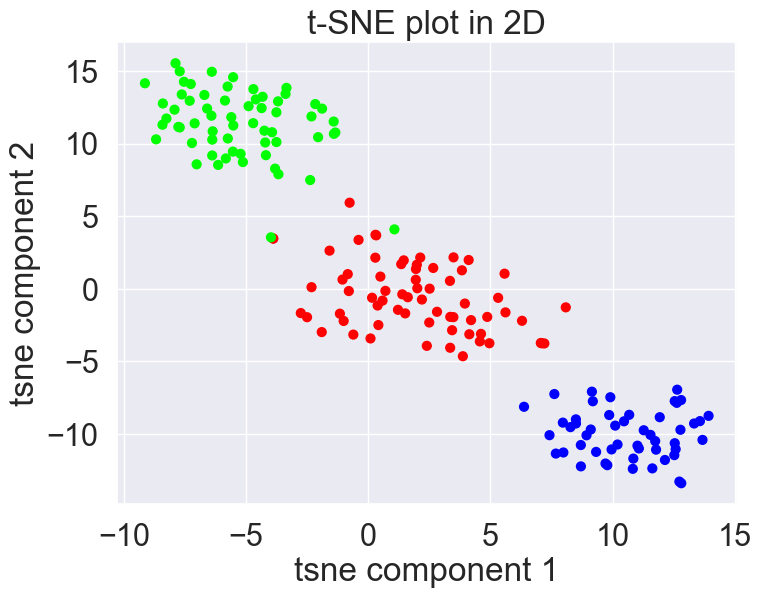

In [78]:
# Figure size
plt.figure(figsize=(8,6))

# Scatterplot
plt.scatter(tsne_df.iloc[:,0], tsne_df.iloc[:,1], c=df['Kmeans_label'], cmap="brg", s=40)

# Aesthetics
plt.title('t-SNE plot in 2D')
plt.xlabel('tsne component 1')
plt.ylabel('tsne component 2')

## 8 Hierarchical Clustering Algorithm<a class="anchor" id="8"></a>

[Table of Contents](#0.1)

### What is Hierarchical Clustering?
+ Hierarchical clustering is a type of unsupervised machine learning algorithm used to cluster unlabeled data points. Like K-means clustering, hierarchical clustering also groups together the data points with similar characteristics.One of the major considerations in using the K-means algorithm is deciding the value of K beforehand. The hierarchical clustering algorithm does not have this restriction.The output of the hierarchical clustering algorithm is quite different from the K-mean algorithm as well. It results in an inverted tree-shaped structure, called the dendrogram.

#### Types Of Hierarchical Clustering:
##### There are two types of hierarchical clustering:

+ <b>Agglomerative</b>: The data points are clustered using a bottom-up approach starting with individual data points.
+ <b>Divisive</b>: The top-down approach is followed where all the data points are treated as one big cluster and the clustering process involves dividing the one big cluster into several small clusters.

#### The key operation in hierarchical agglomerative clustering is to repeatedly combine the two nearest clusters into a larger cluster. There are three key questions that need to be answered first:

How many numbers of cluster. Also deciding which transformation data we will use to build model.

Qiuck Notes:

linkage{“ward”, “complete”, “average”, “single”}, default=”ward” Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

ward minimizes the variance of the clusters being merged.

average uses the average of the distances of each observation of the two sets.

complete or maximum linkage uses the maximum distances between all observations of the two sets.

single uses the minimum of the distances between all observations of the two sets.

### 8.1 Dendogram on PCA MinMaxScaler Applied Dataset<a class="anchor" id="8.1"></a>

<b>Single Linkage:

In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.
![Filter Method](https://www.saedsayad.com/images/Clustering_single.png)

<b>Complete Linkage

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points.
![Filter Method](https://www.saedsayad.com/images/Clustering_complete.png)

<b>Average Linkage:

In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other.
![Filter Method](https://www.saedsayad.com/images/Clustering_average.png)
    

<b>Ward´s Linkage:

Ward´s linkage is a method for hierarchical cluster analysis . The idea has much in common with analysis of variance (ANOVA). The linkage function specifying the distance between two clusters is computed as the increase in the "error sum of squares" (ESS) after fusing two clusters into a single cluster.
![Filter Method](https://cdn.shortpixel.ai/spai/w_325+q_lossy+ret_img+to_auto/https://www.statistics.com/wp-content/uploads/2019/06/glossary-uploads-images-glossary-math00210.gif)

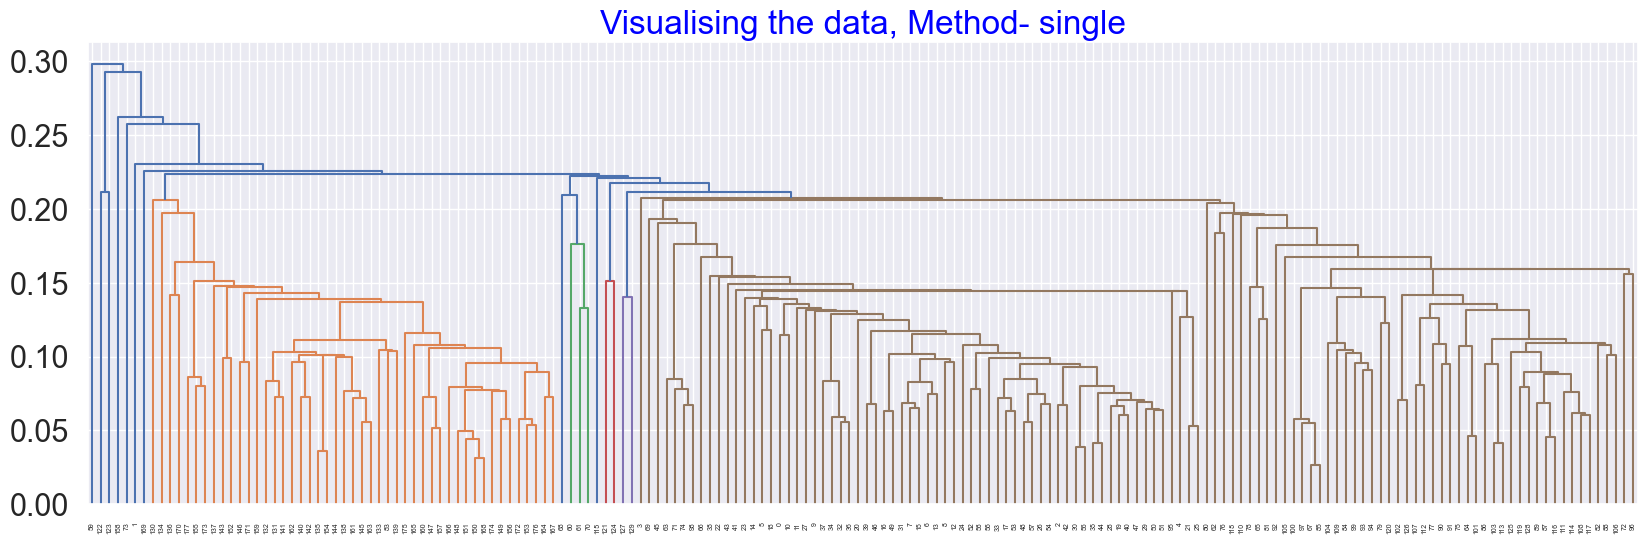

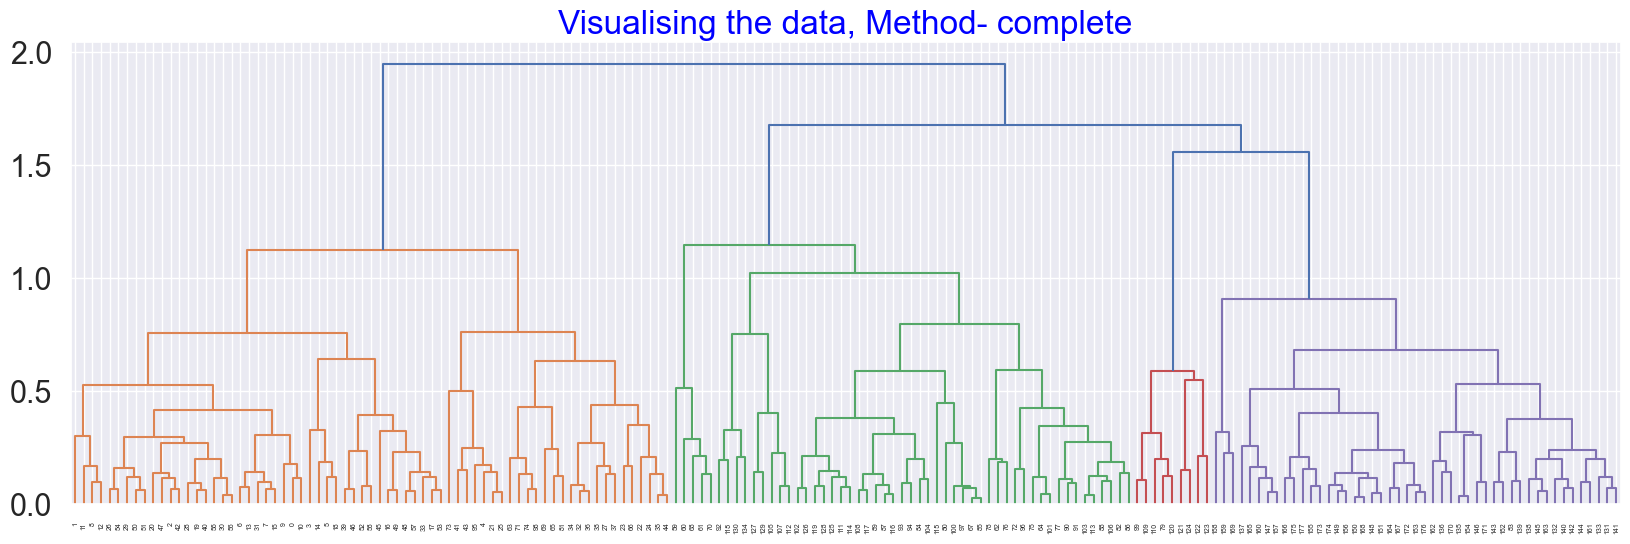

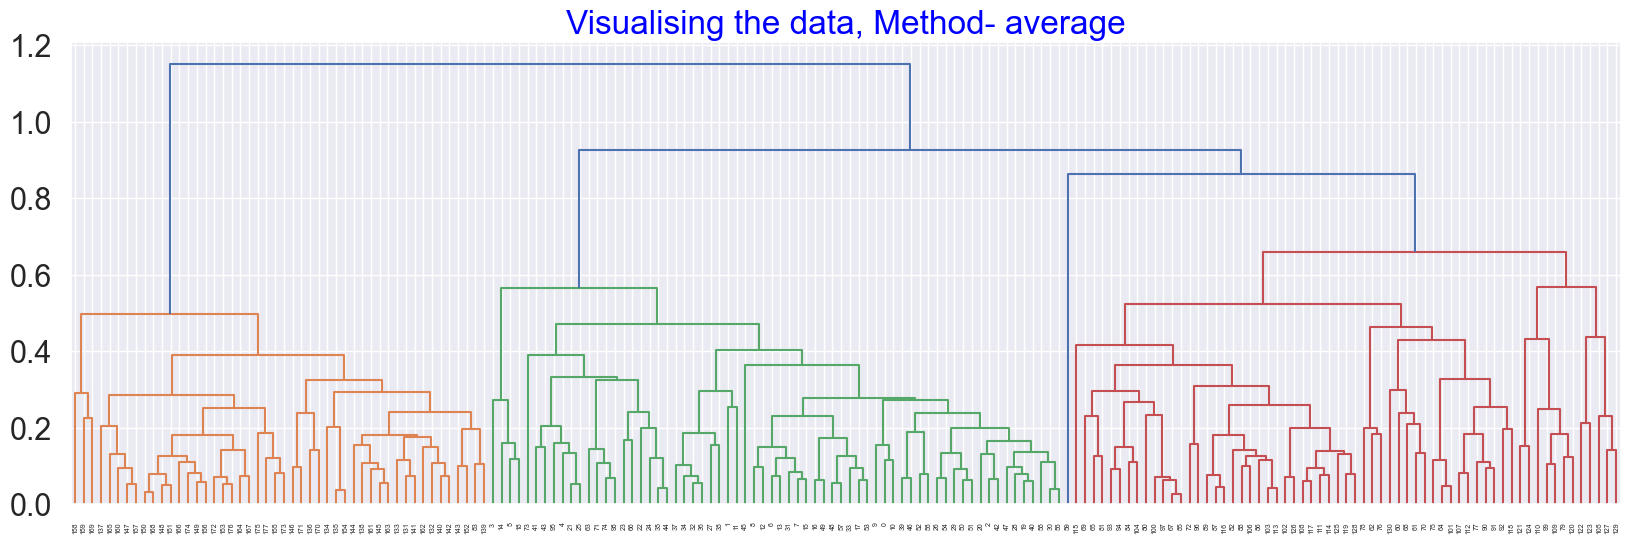

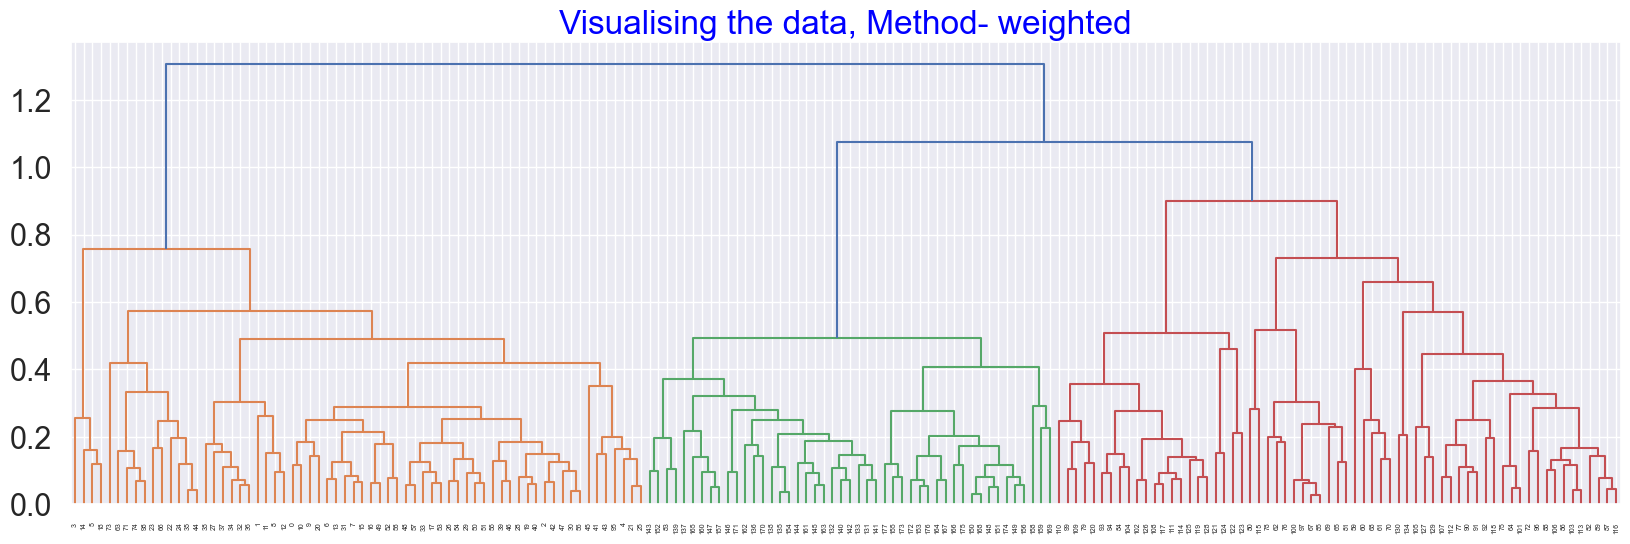

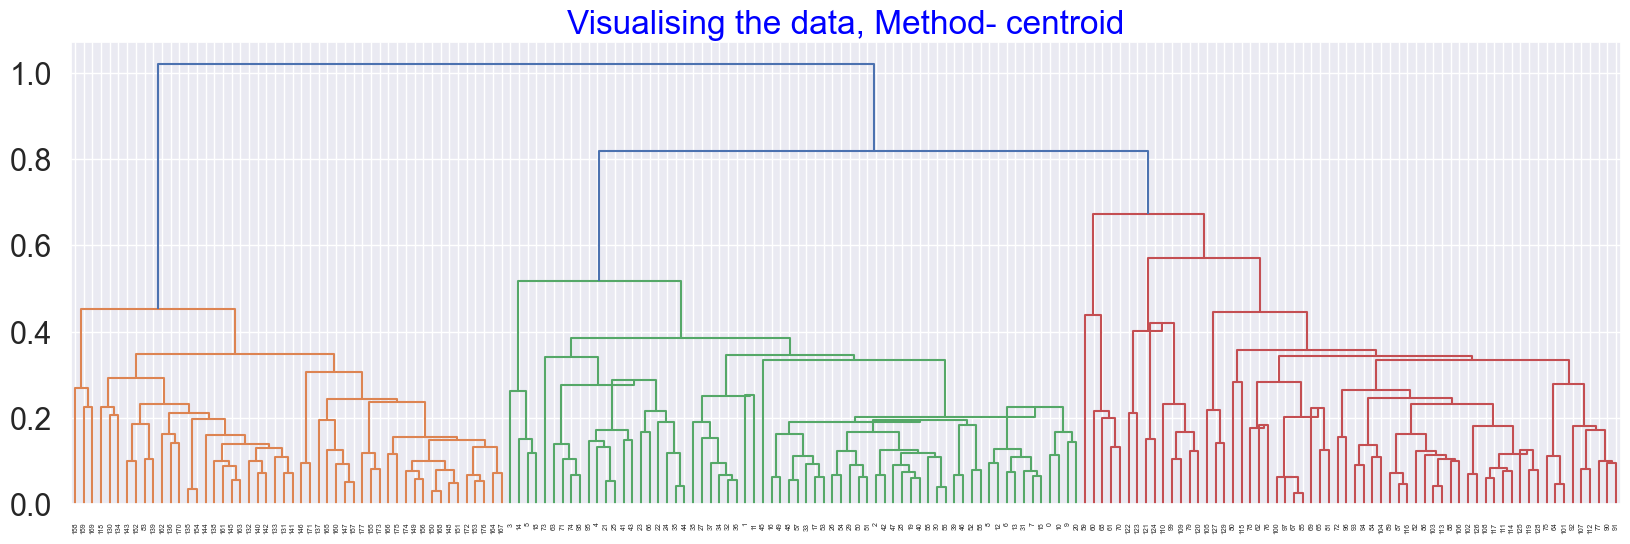

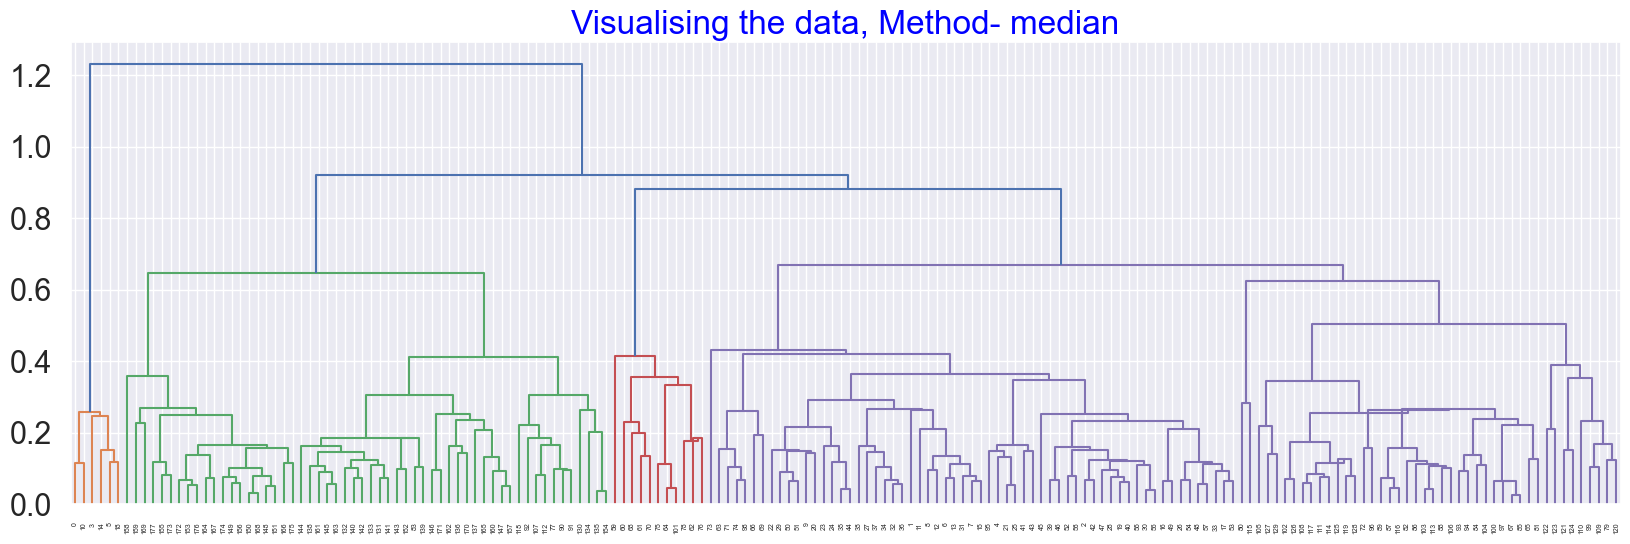

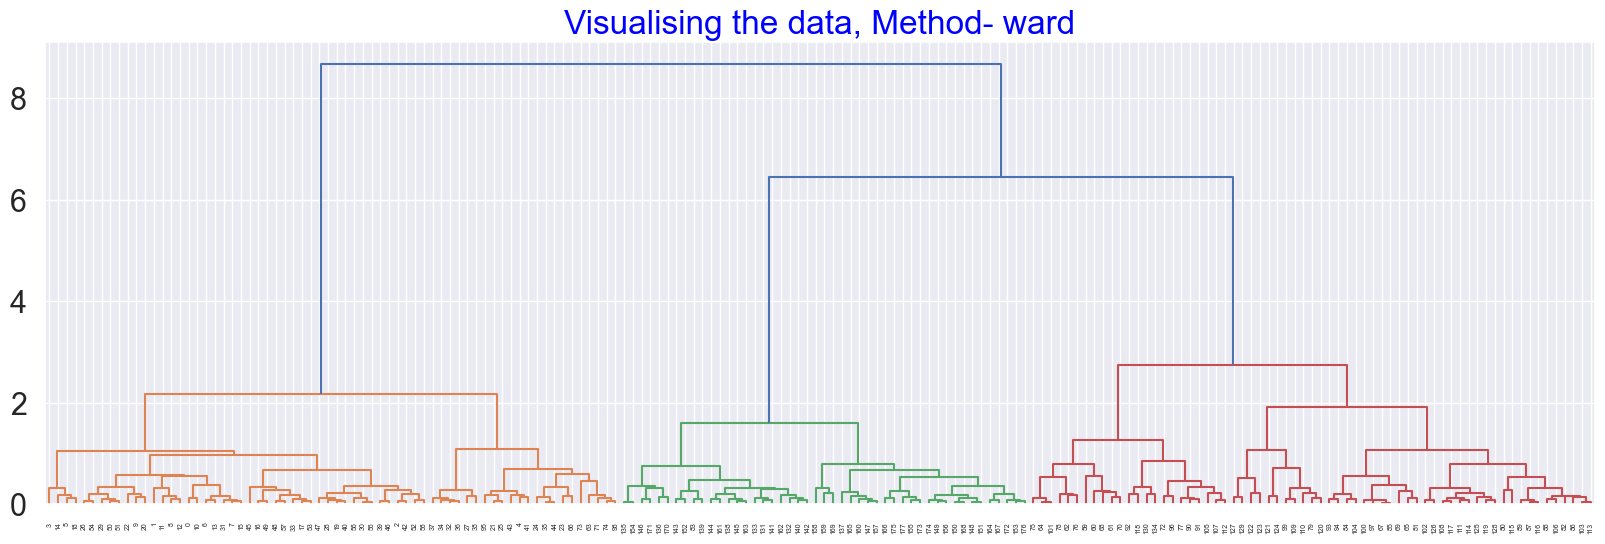

In [79]:
# Applying Dendrogram on data. Or you may apply it on Standardized/normalized indepedent variable data.
# Here diffrent linkage method from hyperparameter is used to see diff between methods for understanding. 
# Ward method is commanly used since it is simpler to visualize understanding.
# Find number of cluster's using color coding of dendrogram. Each color indicates one cluster.

for methods in ['single','complete','average','weighted','centroid','median','ward']: 
    plt.figure(figsize =(20, 6)) 
    
    dict = {'fontsize':24,'fontweight' :16, 'color' : 'blue'}
    
    plt.title('Visualising the data, Method- {}'.format(methods),fontdict = dict) 
    Dendrogram1 = sch.dendrogram(sch.linkage(pca_minmax_df, method = methods,optimal_ordering=False))

[Table of Contents](#0.1)

### 8.2 Silhouette Score method for PCA MinMax Scaled Data <a class="anchor" id="8.2"></a>

#### 8.2(A) Applying Different Linkages using Euclidean Method for distance Calculation<a class="anchor" id="8.2A"></a>

In [80]:
n_clusters = [2,3,4,5,6,7,8]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # by default it takes linkage 'ward'
        hie_labels1 = hie_cluster1.fit_predict(pca_minmax_df)
        silhouette_score1 = sil(pca_minmax_df, hie_labels1)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score1)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.4436935150655508
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.4448273929121037
For n_clusters = 2 The average silhouette_score with linkage- average : 0.45988022636848064
For n_clusters = 2 The average silhouette_score with linkage- single : 0.1934738767787822

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.512478461893362
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.45525090342803287
For n_clusters = 3 The average silhouette_score with linkage- average : 0.5163908228025497
For n_clusters = 3 The average silhouette_score with linkage- single : -0.004466488818666093

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.4562664176188692
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.46813138010224753
For n_clusters = 4 The average silhouette_score with linkage- average : 0.48406949417678735

#### 8.2(B) Applying Different Linkages using Different Distance Methods<a class="anchor" id="8.2A"></a>

In [81]:
n_clusters = [2,3,4,5,6,7,8]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["complete", "average", "single"]:
        for affinities in ["euclidean", "l1", "l2","manhattan", "cosine"]:
            hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,affinity=affinities,linkage=linkages) # by default it takes linkage 'ward'
            hie_labels1 = hie_cluster1.fit_predict(pca_minmax_df)
            silhouette_score1 = sil(pca_minmax_df, hie_labels1)
            print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages,"and Affinity-",affinities,':',silhouette_score1)
        print()

For n_clusters = 2 The average silhouette_score with linkage- complete and Affinity- euclidean : 0.4448273929121037
For n_clusters = 2 The average silhouette_score with linkage- complete and Affinity- l1 : 0.2159549731686994
For n_clusters = 2 The average silhouette_score with linkage- complete and Affinity- l2 : 0.4448273929121037
For n_clusters = 2 The average silhouette_score with linkage- complete and Affinity- manhattan : 0.2159549731686994
For n_clusters = 2 The average silhouette_score with linkage- complete and Affinity- cosine : 0.4448273929121037

For n_clusters = 2 The average silhouette_score with linkage- average and Affinity- euclidean : 0.45988022636848064
For n_clusters = 2 The average silhouette_score with linkage- average and Affinity- l1 : 0.45450203341693884
For n_clusters = 2 The average silhouette_score with linkage- average and Affinity- l2 : 0.45988022636848064
For n_clusters = 2 The average silhouette_score with linkage- average and Affinity- manhattan : 0.4545

For n_clusters = 7 The average silhouette_score with linkage- average and Affinity- euclidean : 0.3209570454682427
For n_clusters = 7 The average silhouette_score with linkage- average and Affinity- l1 : 0.34530706840485065
For n_clusters = 7 The average silhouette_score with linkage- average and Affinity- l2 : 0.3209570454682427
For n_clusters = 7 The average silhouette_score with linkage- average and Affinity- manhattan : 0.34530706840485065
For n_clusters = 7 The average silhouette_score with linkage- average and Affinity- cosine : 0.35163530034117596

For n_clusters = 7 The average silhouette_score with linkage- single and Affinity- euclidean : -0.39051703268877574
For n_clusters = 7 The average silhouette_score with linkage- single and Affinity- l1 : -0.31932337578906955
For n_clusters = 7 The average silhouette_score with linkage- single and Affinity- l2 : -0.39051703268877574
For n_clusters = 7 The average silhouette_score with linkage- single and Affinity- manhattan : -0.319323

#### The seperation in each Linkages and Distance Methods indicate that 3 is the optimal number for clusters.
+ For n_clusters = 3 The average silhouette_score with linkage- average and Affinity- l2 : 0.5163908228025497
+ For n_clusters = 3 The average silhouette_score with linkage- ward : and Affinity - Euclidean : 0.512478461893362

<b>Ward</b> method is actually a method that tries to minimize the variance within each cluster. In K-means when we were trying to minimize the wcss to plot our elbow method chart, here it’s almost the same the only difference is that instead of minimizing wcss we are minimizing the within-cluster variants. That is the variance within each cluster.

[Table of Contents](#0.1)

### 8.3 Dendrogram on Standard Scaler Applied on Data<a class="anchor" id="8.3"></a>

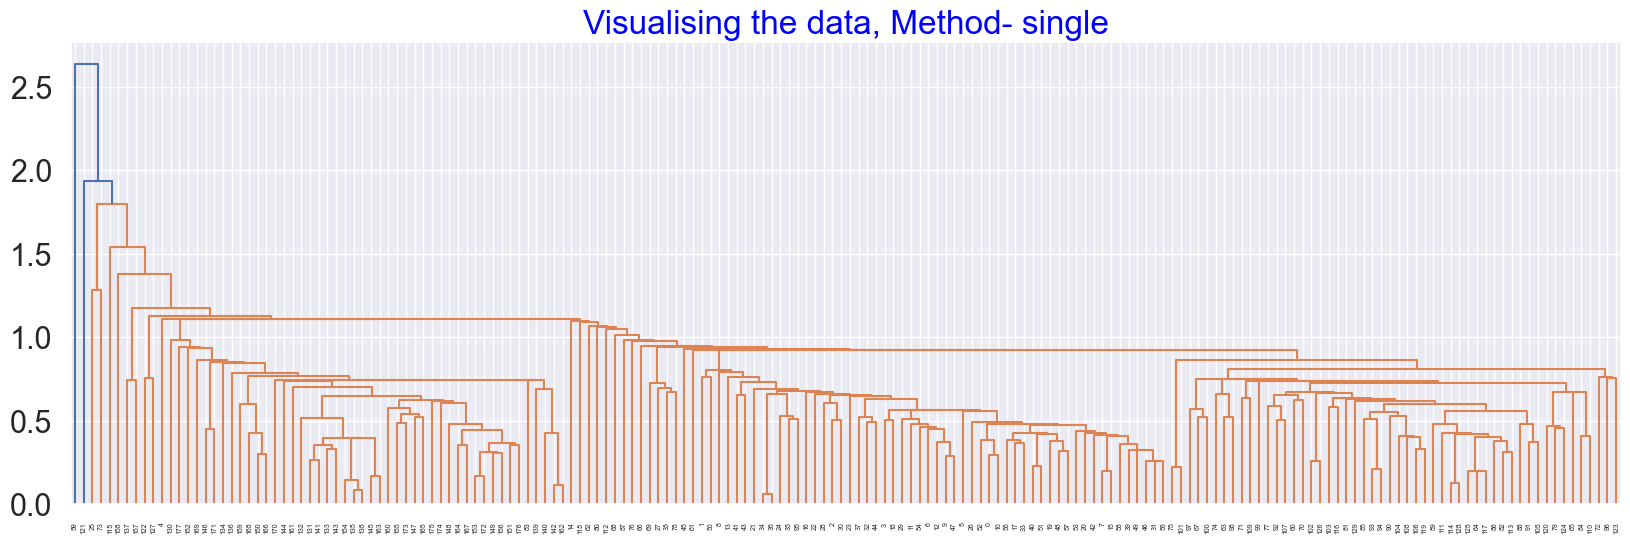

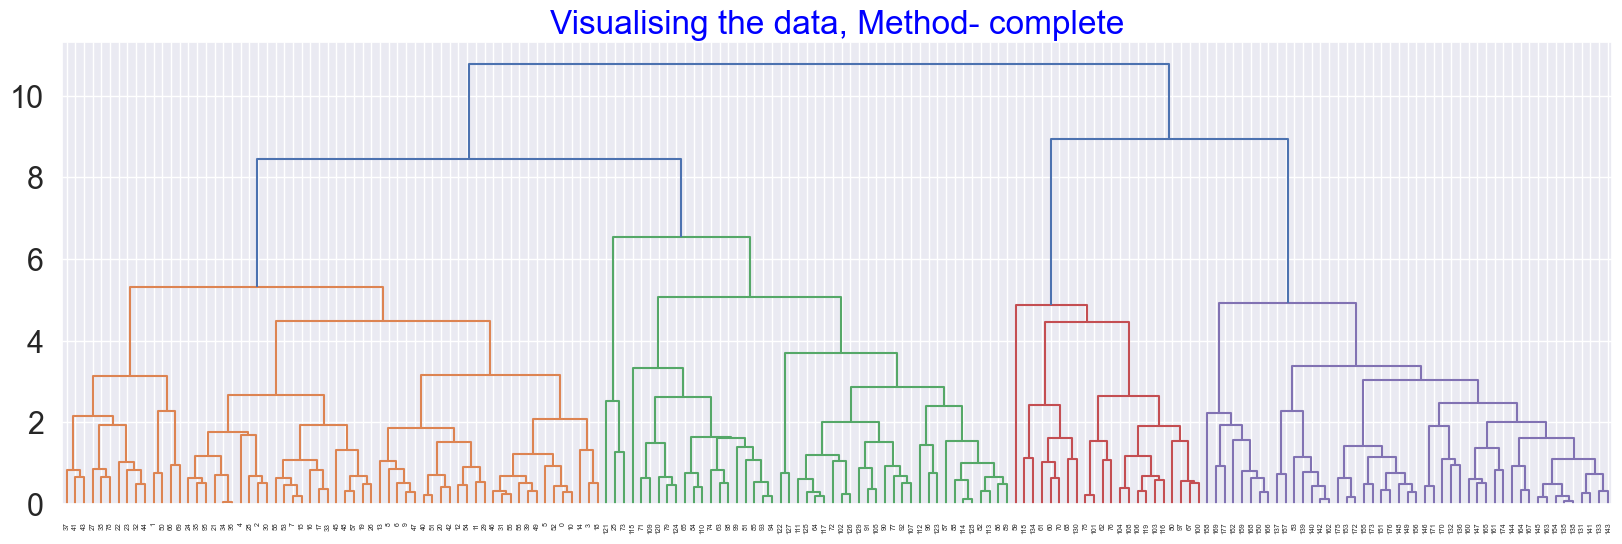

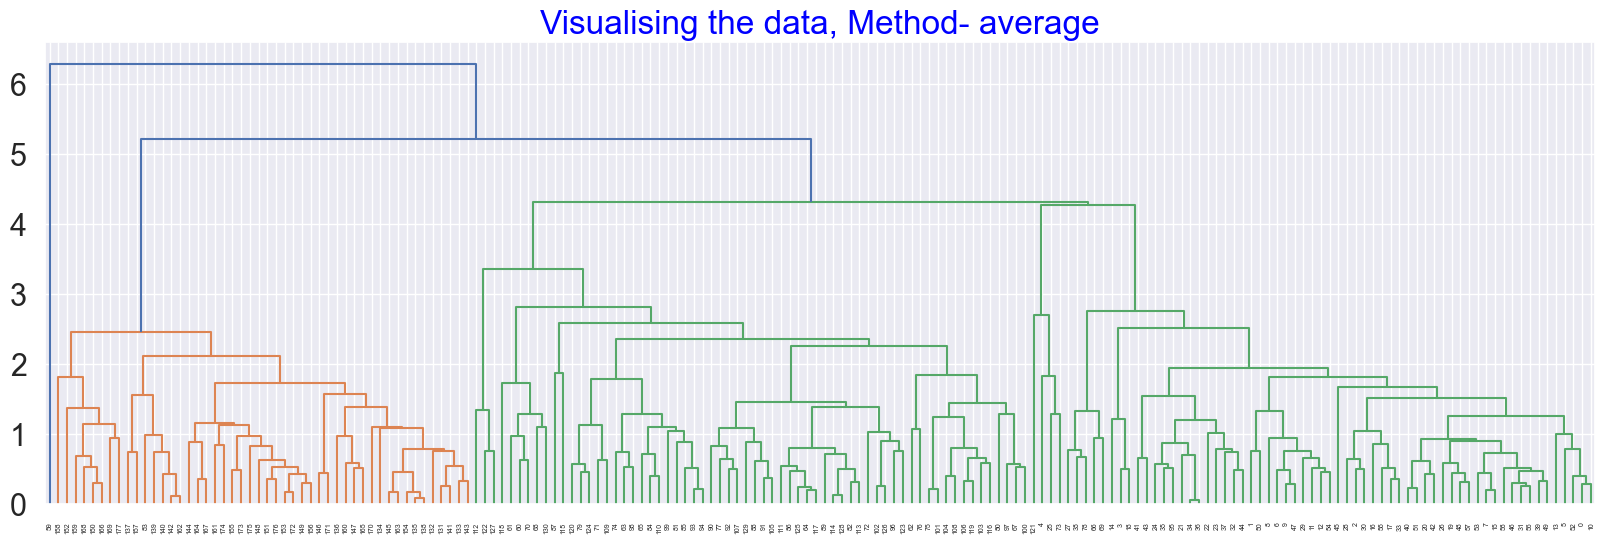

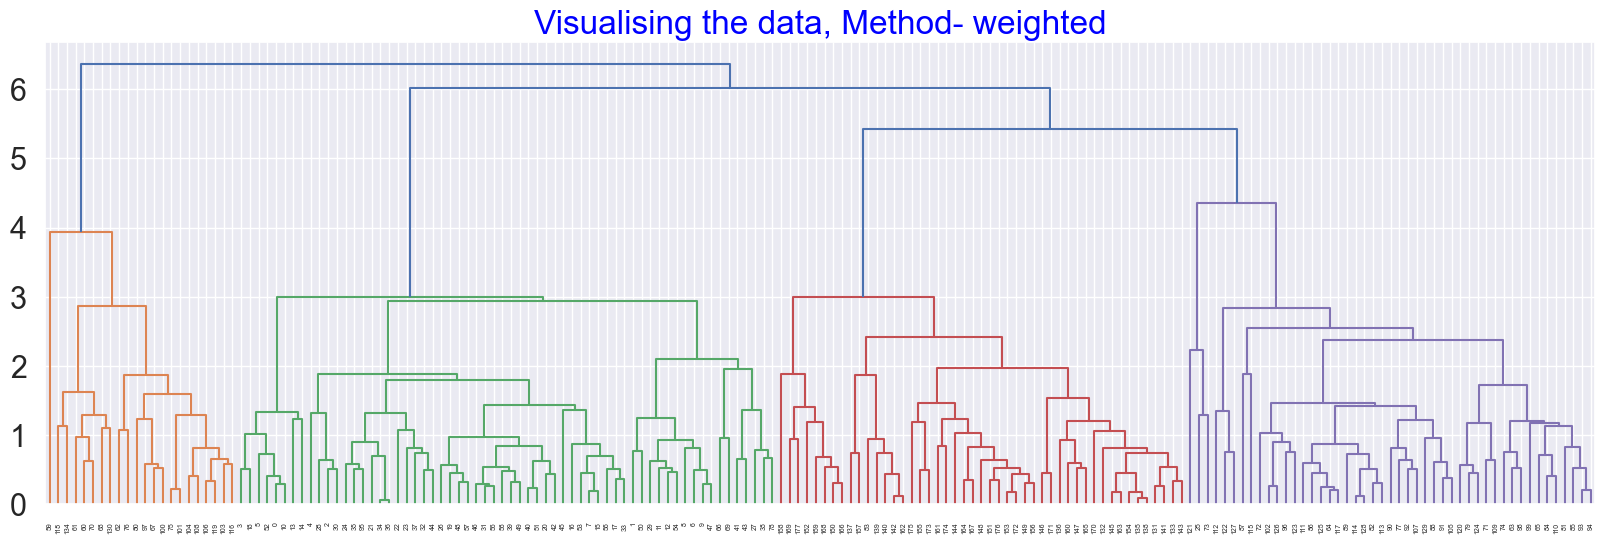

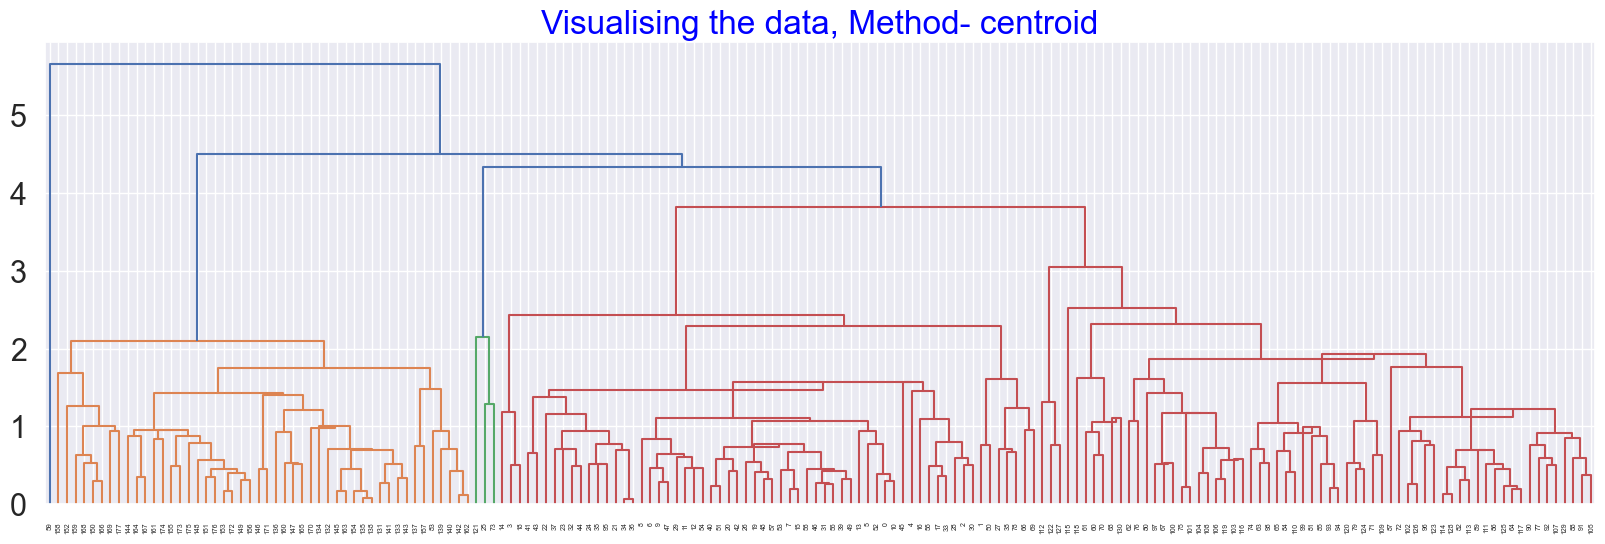

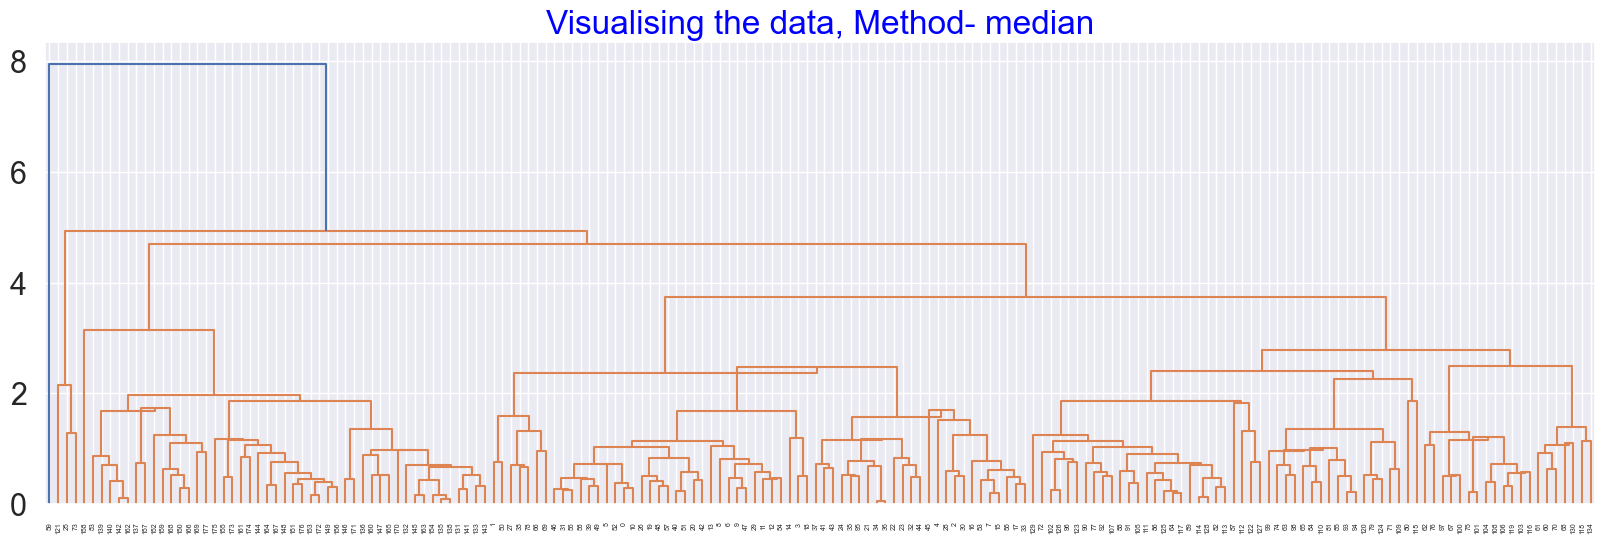

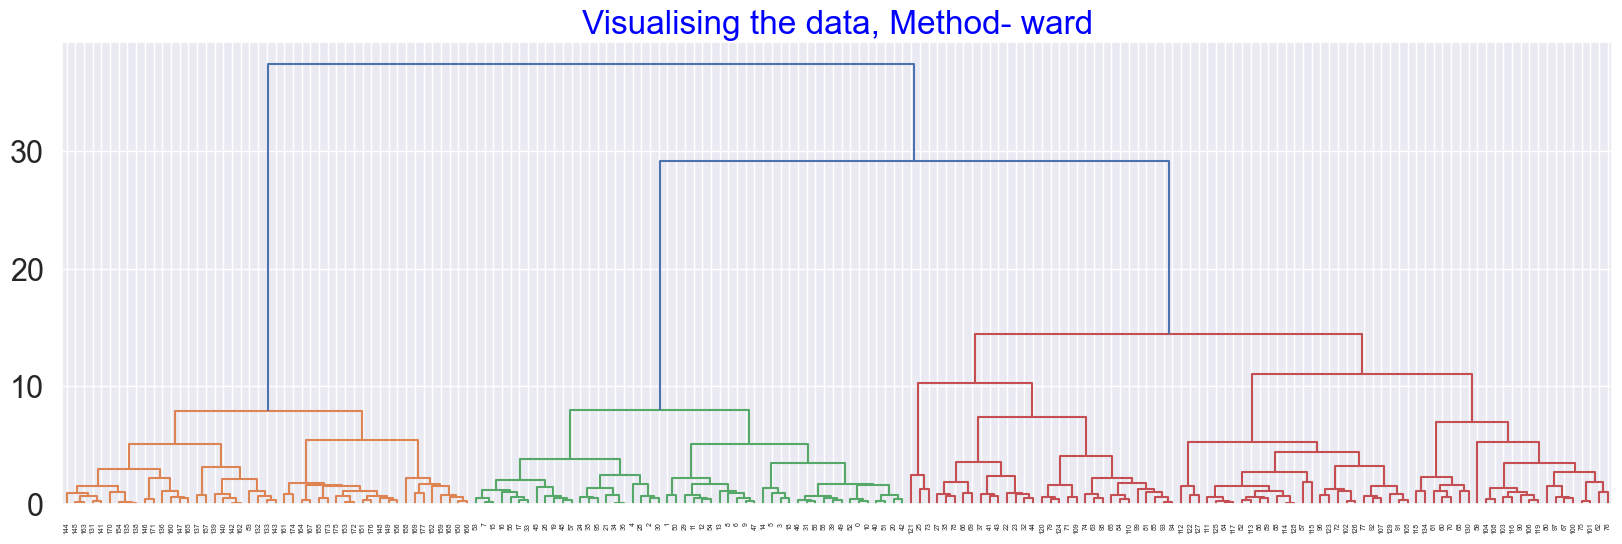

In [82]:
# Applying Dendrogram on data. Or you may apply it on Standardized/normalized indepedent variable data.
# Here diffrent linkage method from hyperparameter is used to see diff between methods for understanding. 
# Ward method is commanly used since it is simpler to visualize understanding.
# Find number of cluster's using color coding of dendrogram. Each color indicates one cluster.

for methods in ['single','complete','average','weighted','centroid','median','ward']: 
    plt.figure(figsize =(20, 6)) 
    
    dict = {'fontsize':24,'fontweight' :16, 'color' : 'blue'}
    
    plt.title('Visualising the data, Method- {}'.format(methods),fontdict = dict) 
    Dendrogram1 = sch.dendrogram(sch.linkage(pca_std_df, method = methods,optimal_ordering=False))

### 8.4 Silhouette Score method for PCA Standard Scaled Data <a class="anchor" id="8.4"></a>

#### 8.4(A) Applying Different Linkages using Euclidean Method for distance Calculation<a class="anchor" id="8.4A"></a>

In [83]:
n_clusters = [2,3,4,5,6,7,8]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # by default it takes linkage 'ward'
        hie_labels1 = hie_cluster1.fit_predict(pca_std_df)
        silhouette_score1 = sil(pca_std_df, hie_labels1)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score1)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.41877970090924654
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.3437278770757191
For n_clusters = 2 The average silhouette_score with linkage- average : 0.3485404154932637
For n_clusters = 2 The average silhouette_score with linkage- single : 0.3485404154932637

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.4355352661667812
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.29482654329265306
For n_clusters = 3 The average silhouette_score with linkage- average : 0.4025547835526692
For n_clusters = 3 The average silhouette_score with linkage- single : 0.25789382473384315

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.3739703958691178
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.4171188330984905
For n_clusters = 4 The average silhouette_score with linkage- average : 0.4689067590764211
Fo

#### 8.4(B) Applying Different Linkages using Different Distance Methods<a class="anchor" id="8.4B"></a>

In [84]:
n_clusters = [2,3,4,5,6,7,8]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["complete", "average", "single"]:
        for affinities in ["euclidean", "l1", "l2","manhattan", "cosine"]:
            hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,affinity=affinities,linkage=linkages) # by default it takes linkage 'ward'
            hie_labels1 = hie_cluster1.fit_predict(pca_std_df)
            silhouette_score1 = sil(pca_std_df, hie_labels1)
            print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages,"and Affinity-",affinities,':',silhouette_score1)
        print()

For n_clusters = 2 The average silhouette_score with linkage- complete and Affinity- euclidean : 0.3437278770757191
For n_clusters = 2 The average silhouette_score with linkage- complete and Affinity- l1 : 0.22011950029106112
For n_clusters = 2 The average silhouette_score with linkage- complete and Affinity- l2 : 0.3437278770757191
For n_clusters = 2 The average silhouette_score with linkage- complete and Affinity- manhattan : 0.22011950029106112
For n_clusters = 2 The average silhouette_score with linkage- complete and Affinity- cosine : 0.4246715959380682

For n_clusters = 2 The average silhouette_score with linkage- average and Affinity- euclidean : 0.3485404154932637
For n_clusters = 2 The average silhouette_score with linkage- average and Affinity- l1 : 0.3485404154932637
For n_clusters = 2 The average silhouette_score with linkage- average and Affinity- l2 : 0.3485404154932637
For n_clusters = 2 The average silhouette_score with linkage- average and Affinity- manhattan : 0.34854

For n_clusters = 7 The average silhouette_score with linkage- complete and Affinity- l1 : 0.3392719358370755
For n_clusters = 7 The average silhouette_score with linkage- complete and Affinity- l2 : 0.35000676099695144
For n_clusters = 7 The average silhouette_score with linkage- complete and Affinity- manhattan : 0.3392719358370755
For n_clusters = 7 The average silhouette_score with linkage- complete and Affinity- cosine : 0.3399075565759656

For n_clusters = 7 The average silhouette_score with linkage- average and Affinity- euclidean : 0.3473520304972636
For n_clusters = 7 The average silhouette_score with linkage- average and Affinity- l1 : 0.37453200215572025
For n_clusters = 7 The average silhouette_score with linkage- average and Affinity- l2 : 0.3473520304972636
For n_clusters = 7 The average silhouette_score with linkage- average and Affinity- manhattan : 0.37453200215572025
For n_clusters = 7 The average silhouette_score with linkage- average and Affinity- cosine : 0.34231833

<b>Conclusion</b>: Max score is with cluster numbers 4 in standard scaler transformation  transformation. 

+ For n_clusters = 4 The average silhouette_score with linkage- complete and Affinity- l1 : 0.4731230759943259
+ For n_clusters = 3 The average silhouette_score with linkage- ward : 0.435535266166781

+ Heirarchical clustering means creating a tree of clusters by iteratively grouping or separating data points. There are two types of hierarchical clustering: Agglomerative clustering Divisive clustering We now apply the Agglomerative clustering technique:Agglomerative clustering is kind of a bottom-up approach. Each data point is assumed to be a separate cluster at first. Then the similar clusters are iteratively combined

[Table of Contents](#0.1)

### 8.5 Run Hierarchical Clustering.(Agglomerative Clustering) For PCA on Standard Scaled Data <a class="anchor" id="8.5"></a>

<b>Ward</b> method is actually a method that tries to minimize the variance within each cluster. In K-means when we were trying to minimize the wcss to plot our elbow method chart, here it’s almost the same the only difference is that instead of minimizing wcss we are minimizing the within-cluster variants. That is the variance within each cluster.

In [85]:
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='complete', affinity='l1')
y_pred_hie = agg_clustering.fit_predict(pca_std_df)
print(y_pred_hie.shape)
y_pred_hie

(178,)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int64)

In [86]:
# Cluster numbers

agg_clustering.n_clusters_

4

In [87]:
# Clustering Score

(sil(pca_std_df, agg_clustering.labels_)*100).round(3)

47.312

### Putting Cluster lables into original dataset And analysis of the same

In [88]:
# Concating Labels with main dataset copy

df['Hierarchical_labels'] = agg_clustering.labels_
df.head()

Alcohol  Malic   Ash  Alcalinity  Magnesium  Phenols  Flavanoids  \
0  14.23    1.71   2.43  15.6        127        2.80     3.06         
1  13.20    1.78   2.14  11.2        100        2.65     2.76         
2  13.16    2.36   2.67  18.6        101        2.80     3.24         
3  14.37    1.95   2.50  16.8        113        3.85     3.49         
4  13.24    2.59   2.87  21.0        118        2.80     2.69         

   Nonflavanoids  Proanthocyanins  Color   Hue  Dilution  Proline  ID  \
0  0.28           2.29             5.64   1.04  3.92      1065     1    
1  0.26           1.28             4.38   1.05  3.40      1050     2    
2  0.30           2.81             5.68   1.03  3.17      1185     3    
3  0.24           2.18             7.80   0.86  3.45      1480     4    
4  0.39           1.82             4.32   1.04  2.93      735      5    

   Kmeans_label  Hierarchical_labels  
0  2             1                    
1  2             1                    
2  2             1                    
3  2             1                    
4  2             1

In [89]:
df.groupby('Hierarchical_labels').agg(['mean'])

Alcohol     Malic       Ash Alcalinity   Magnesium  \
                          mean      mean      mean       mean        mean   
Hierarchical_labels                                                         
0                    12.249516  1.972097  2.249839  20.193548  92.000000    
1                    13.622615  1.927692  2.395692  16.955385  106.738462   
2                    13.157708  3.386042  2.437083  21.510417  98.541667    
3                    12.533333  1.923333  3.016667  27.833333  127.333333   

                      Phenols Flavanoids Nonflavanoids Proanthocyanins  \
                         mean       mean          mean            mean   
Hierarchical_labels                                                      
0                    2.182419  1.959194   0.370645      1.529516         
1                    2.821385  2.942154   0.283077      1.946923         
2                    1.681667  0.788542   0.455833      1.167708         
3                    3.036667  3.550000   0.383333      1.916667         

                        Color       Hue  Dilution      Proline          ID  \
                         mean      mean      mean         mean        mean   
Hierarchical_labels                                                          
0                    2.937097  1.042516  2.740000  497.564516   97.403226    
1                    5.378308  1.070308  3.124308  1072.276923  35.400000    
2                    7.410833  0.684375  1.698542  627.500000   153.520833   
3                    4.310000  1.123333  3.463333  760.000000   74.000000    

                    Kmeans_label  
                            mean  
Hierarchical_labels               
0                    0.967742     
1                    1.923077     
2                    0.000000     
3                    1.666667

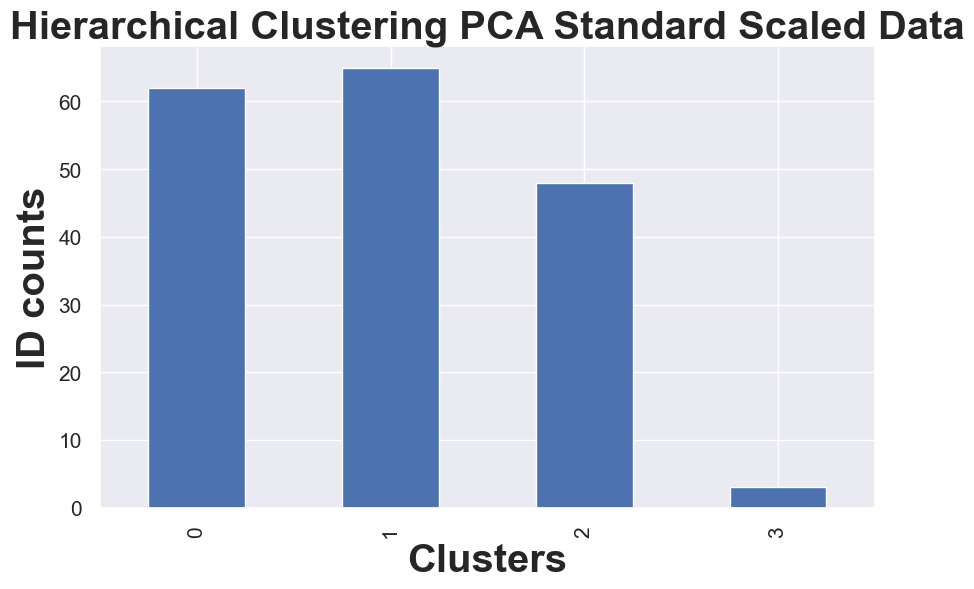

In [90]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['Hierarchical_labels']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('Hierarchical Clustering PCA Standard Scaled Data',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

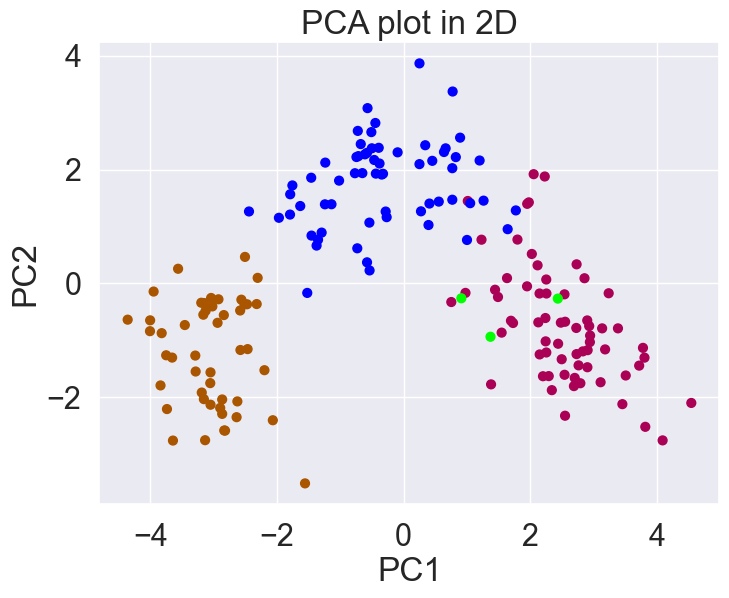

In [91]:
# Figure size
plt.figure(figsize=(8,6))

# Scatterplot
plt.scatter(pca_std_df.iloc[:,0], pca_std_df.iloc[:,1], c=df['Hierarchical_labels'], cmap="brg", s=40)

# Aesthetics
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### We cannot now clearly see the 4 number of clusters formed

### 8.5(A) Comparing Hierarchical Clusters with the Original Classified Dataset using "Type" Feature<a class="anchor" id="8.5A"></a>

[Table of Contents](#0.1)

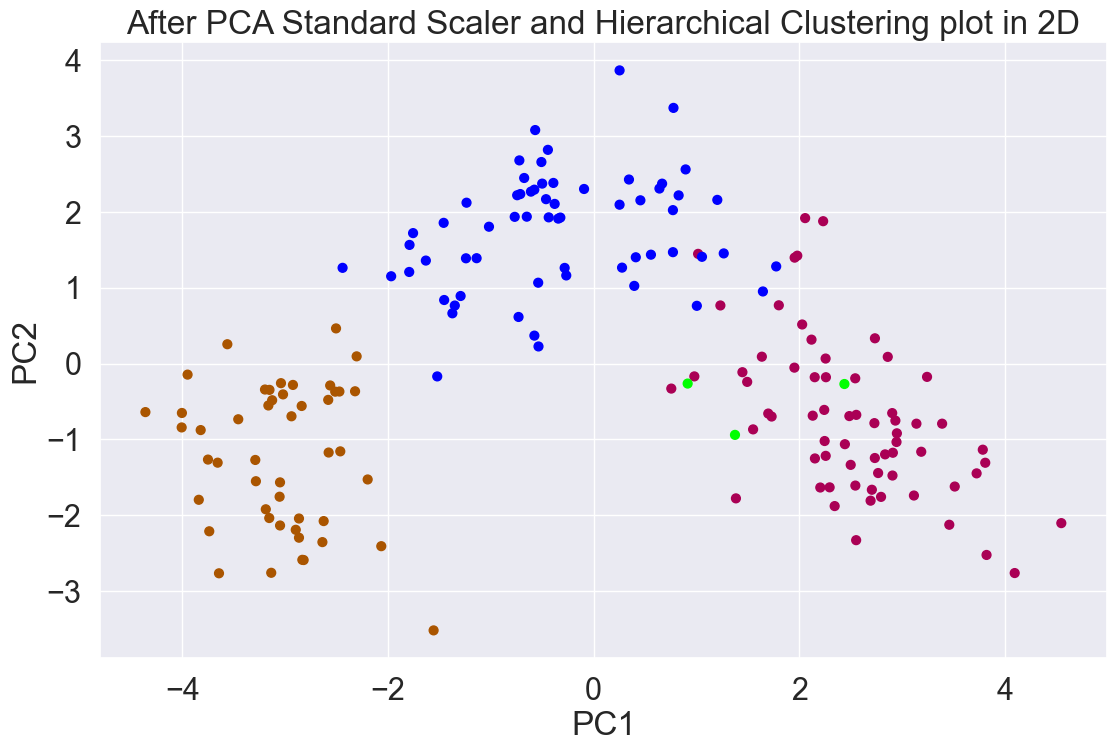

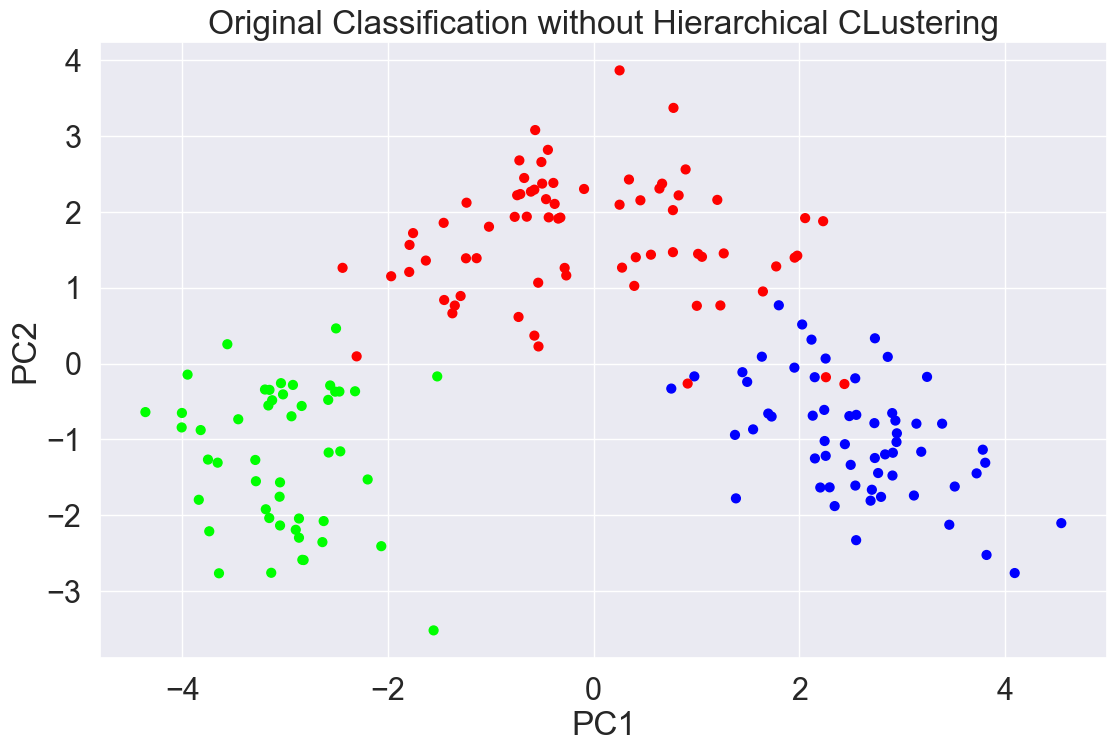

In [92]:
# Scatterplot
plt.scatter(pca_std_df.iloc[:,0], pca_std_df.iloc[:,1], c=df['Hierarchical_labels'], cmap="brg", s=40)

# Aesthetics
plt.title('After PCA Standard Scaler and Hierarchical Clustering plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Scatterplot
plt.scatter(pca_std_df.iloc[:,0], pca_std_df.iloc[:,1], c=data['Type'], cmap="brg", s=40)

# Aesthetics
plt.title('Original Classification without Hierarchical CLustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [93]:
# Group data by Clusters (Clusters=4)
display('After Applying Hierarchical Clustering on PCA Standard Scaled Dataset',df.groupby('Hierarchical_labels').agg(['mean']),'Original Classified Dataset',data.groupby('Type').agg(['mean']))

'After Applying Hierarchical Clustering on PCA Standard Scaled Dataset'

Alcohol     Malic       Ash Alcalinity   Magnesium  \
                          mean      mean      mean       mean        mean   
Hierarchical_labels                                                         
0                    12.249516  1.972097  2.249839  20.193548  92.000000    
1                    13.622615  1.927692  2.395692  16.955385  106.738462   
2                    13.157708  3.386042  2.437083  21.510417  98.541667    
3                    12.533333  1.923333  3.016667  27.833333  127.333333   

                      Phenols Flavanoids Nonflavanoids Proanthocyanins  \
                         mean       mean          mean            mean   
Hierarchical_labels                                                      
0                    2.182419  1.959194   0.370645      1.529516         
1                    2.821385  2.942154   0.283077      1.946923         
2                    1.681667  0.788542   0.455833      1.167708         
3                    3.036667  3.550000   0.383333      1.916667         

                        Color       Hue  Dilution      Proline          ID  \
                         mean      mean      mean         mean        mean   
Hierarchical_labels                                                          
0                    2.937097  1.042516  2.740000  497.564516   97.403226    
1                    5.378308  1.070308  3.124308  1072.276923  35.400000    
2                    7.410833  0.684375  1.698542  627.500000   153.520833   
3                    4.310000  1.123333  3.463333  760.000000   74.000000    

                    Kmeans_label  
                            mean  
Hierarchical_labels               
0                    0.967742     
1                    1.923077     
2                    0.000000     
3                    1.666667

'Original Classified Dataset'

Alcohol     Malic       Ash Alcalinity   Magnesium   Phenols  \
           mean      mean      mean       mean        mean      mean   
Type                                                                   
1     13.744746  2.010678  2.455593  17.037288  106.338983  2.840169   
2     12.278732  1.932676  2.244789  20.238028  94.549296   2.258873   
3     13.153750  3.333750  2.437083  21.416667  99.312500   1.678750   

     Flavanoids Nonflavanoids Proanthocyanins     Color       Hue  Dilution  \
           mean          mean            mean      mean      mean      mean   
Type                                                                          
1     2.982373   0.290000      1.899322        5.528305  1.062034  3.157797   
2     2.080845   0.363662      1.630282        3.086620  1.056282  2.785352   
3     0.781458   0.447500      1.153542        7.396250  0.682708  1.683542   

          Proline     ID Kmeans_label  
             mean   mean         mean  
Type                                   
1     1115.711864  30.0   2.0          
2     519.507042   95.0   1.0          
3     629.895833   154.5  0.0

### Observation:
As you can see the most of the data is in the first three clusters and very little amount of data in the last cluster so it must been that clusters are overlapping or may be that the data belonging to clusters may be wrong/incorrect.

[Table of Contents](#0.1)

### 8.6 Run Hierarchical Clustering.(Agglomerative Clustering) For PCA on MinMaxScaled Data <a class="anchor" id="8.6"></a>

<b>Ward</b> method is actually a method that tries to minimize the variance within each cluster. In K-means when we were trying to minimize the wcss to plot our elbow method chart, here it’s almost the same the only difference is that instead of minimizing wcss we are minimizing the within-cluster variants. That is the variance within each cluster.

In [94]:
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='average', affinity='l2')
y_pred_hie = agg_clustering.fit_predict(pca_minmax_df)
print(y_pred_hie.shape)
y_pred_hie

(178,)


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

In [95]:
# Cluster numbers

agg_clustering.n_clusters_

3

In [96]:
# Clustering Score

(sil(pca_minmax_df, agg_clustering.labels_)*100).round(3)

51.639

### Putting Cluster lables into original dataset And analysis of the same

In [97]:
# Concating Labels with main dataset copy

df['Hierarchical_labels'] = agg_clustering.labels_
df.head()

Alcohol  Malic   Ash  Alcalinity  Magnesium  Phenols  Flavanoids  \
0  14.23    1.71   2.43  15.6        127        2.80     3.06         
1  13.20    1.78   2.14  11.2        100        2.65     2.76         
2  13.16    2.36   2.67  18.6        101        2.80     3.24         
3  14.37    1.95   2.50  16.8        113        3.85     3.49         
4  13.24    2.59   2.87  21.0        118        2.80     2.69         

   Nonflavanoids  Proanthocyanins  Color   Hue  Dilution  Proline  ID  \
0  0.28           2.29             5.64   1.04  3.92      1065     1    
1  0.26           1.28             4.38   1.05  3.40      1050     2    
2  0.30           2.81             5.68   1.03  3.17      1185     3    
3  0.24           2.18             7.80   0.86  3.45      1480     4    
4  0.39           1.82             4.32   1.04  2.93      735      5    

   Kmeans_label  Hierarchical_labels  
0  2             2                    
1  2             2                    
2  2             2                    
3  2             2                    
4  2             2

In [98]:
df.groupby('Hierarchical_labels').agg(['mean'])

Alcohol     Malic       Ash Alcalinity   Magnesium  \
                          mean      mean      mean       mean        mean   
Hierarchical_labels                                                         
0                    12.226094  1.964219  2.244531  20.076563  93.890625    
1                    13.157708  3.386042  2.437083  21.510417  98.541667    
2                    13.637424  1.933788  2.433485  17.465152  106.287879   

                      Phenols Flavanoids Nonflavanoids Proanthocyanins  \
                         mean       mean          mean            mean   
Hierarchical_labels                                                      
0                    2.157969  1.987656   0.372812      1.565781         
1                    1.681667  0.788542   0.455833      1.167708         
2                    2.874242  2.971970   0.282879      1.923030         

                        Color       Hue  Dilution      Proline          ID  \
                         mean      mean      mean         mean        mean   
Hierarchical_labels                                                          
0                    2.994687  1.042437  2.746875  503.125000   97.578125    
1                    7.410833  0.684375  1.698542  627.500000   153.520833   
2                    5.347879  1.073636  3.144697  1070.106061  35.106061    

                    Kmeans_label  
                            mean  
Hierarchical_labels               
0                    0.968750     
1                    0.000000     
2                    1.939394

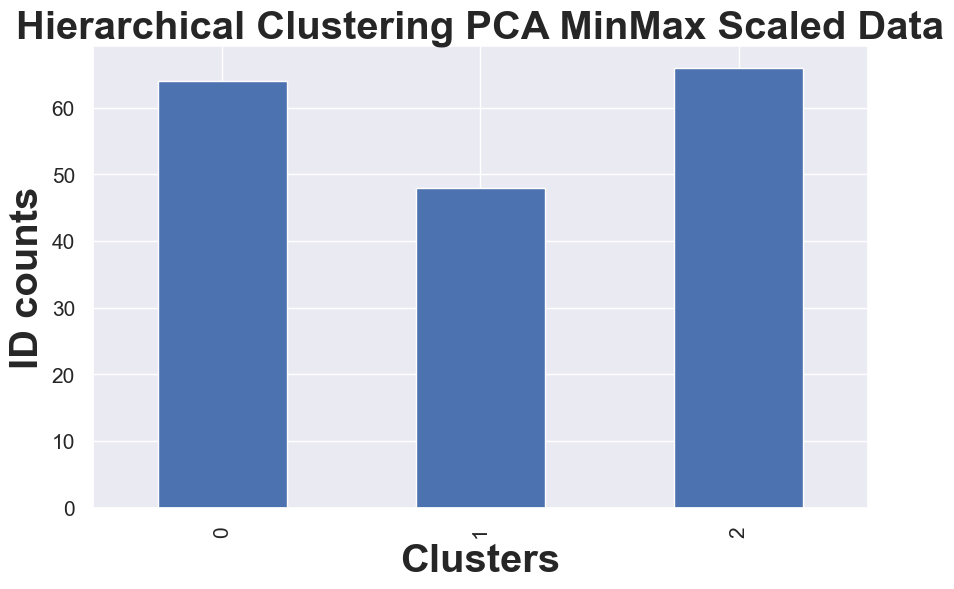

In [99]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['Hierarchical_labels']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('Hierarchical Clustering PCA MinMax Scaled Data',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

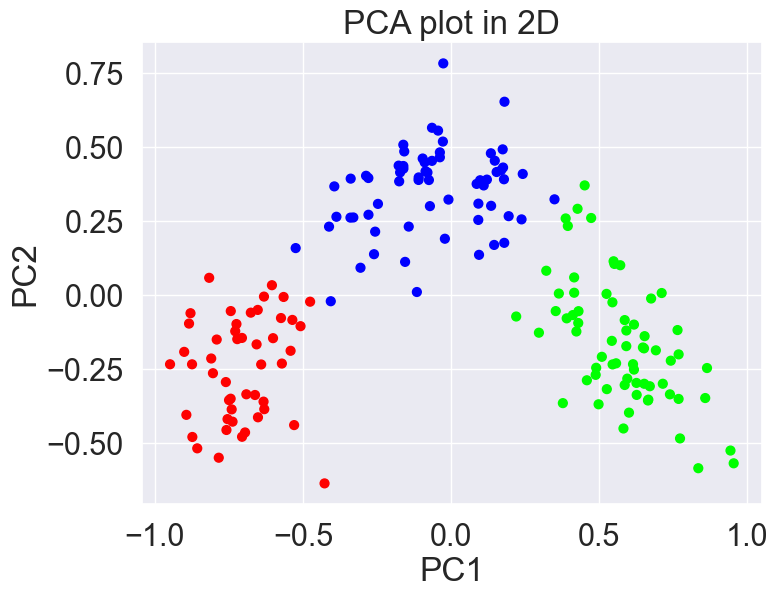

In [100]:
# Figure size
plt.figure(figsize=(8,6))

# Scatterplot
plt.scatter(pca_minmax_df.iloc[:,0], pca_minmax_df.iloc[:,1], c=df['Hierarchical_labels'], cmap="brg", s=40)

# Aesthetics
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### We can now clearly see the 3 number of clusters formed

In [ ]:
df1 = data.copy()
df1.rename({"Hierarchical_labels":'Cluster'}, axis=1,inplace=True)

aux=df1.columns.tolist()
aux[0:len(aux)-1]

sns.set(style="darkgrid", rc={'figure.figsize':(13,8)}, font_scale=2)

for cluster in aux[0:len(aux)-1]:
    grid = sns.FacetGrid(df1, col=cluster)
    grid.map(plt.hist, cluster, color="skyblue", lw=1, edgecolor="black")

In [ ]:
# Sorting elements based on cluster label assigned and taking average for insights.

cluster1 = pd.DataFrame(df1.loc[df1.Cluster==0].mean(),columns= ['Cluster1_avg'])
cluster2 = pd.DataFrame(df1.loc[df1.Cluster==1].mean(),columns= ['Cluster2_avg'])
cluster3 = pd.DataFrame(df1.loc[df1.Cluster==2].mean(),columns= ['Cluster2_avg'])

In [ ]:
avg_df = pd.concat([cluster1,cluster2,cluster3],axis=1)
avg_df

In [ ]:
# Extract and plot one Column data .xs method
for i , row in avg_df.iterrows():
    fig = plt.subplots(figsize=(8,6))
    j = avg_df.xs(i ,axis = 0)
    plt.title(i, fontsize=16, fontweight=20)
    j.plot(kind='bar',fontsize=14)
    plt.show()
    print()

### 8.6(A) Comparing Hierarchical Clusters with the Original Classified Dataset using "Type" Feature<a class="anchor" id="8.6A"></a>

[Table of Contents](#0.1)

In [ ]:
# Scatterplot
plt.scatter(pca_minmax_df.iloc[:,0], pca_minmax_df.iloc[:,1], c=df['Hierarchical_labels'], cmap="brg", s=40)

# Aesthetics
plt.title('After Hierarchical Clustering on PCA MinMax Scaled Dataset')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Scatterplot
plt.scatter(pca_minmax_df.iloc[:,0], pca_minmax_df.iloc[:,1], c=data['Type'], cmap="brg", s=40)

# Aesthetics
plt.title('Original Classification without Hierarchical CLustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
# Group data by Clusters (K=3)
display('After Applying Hierarchical CLustering on  PCA MinMax Scaled Dataset',df.groupby('Hierarchical_labels').agg(['mean']),'Original Classified Dataset',data.groupby('Type').agg(['mean']))

### Observation: 
+ The 3 clusters has been clustered but has a negliglable amount of difference compared to original classified Feature
+ We have perfectly clustered the data into Three Types as compared to classification of three types of Wine was indicated in the Original Dataset in 'Type' Column

# 9. Conclusion:<a class="anchor" id="9"></a>

##### I have applied EDA to analyze dataset.Discovered correlation between diff variables and found colinearity.
##### Applied Standardazation & MinMaxScalar transformation on the data to use Principle componets analysis effectively.
##### I have used & analyzed two clustering techniques here..i) KMeans  ii) Hierarchical Clusterig

##### By applying clustering on diff. PCA obtained with diff transformation data shows fluctuation in model score. So finally the Standard Scaler found less score so not used for further model building.